OVERVIEW:
The data required for this project can be found at this link: 
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/cfhtls/dfspt.html
One must download the DeepVarFull.tar.gz file and drag it/download it into the Jupyter notebook or project to work with it. The data should contain approximately 28000 files to be extracted in which each file represents an astronomical object. There is information about the object within each file, like its magnitude measurements and the filters in which the measurements were taken, etc.. Each of the astronomical objects had several brightness measurements taken in each of the six filters ('U','G','R','I1','I2', and 'Z' are our names for them).
In the code below, you will find that we have combined the fourth and fifth filters (i1 and i2) into a single filter, thus having more magnitude measurements than the other filters.

In [168]:
#import statements
import numpy as np
import math
import pandas as pd
import os
import warnings
from astropy.stats import sigma_clip
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy.ma as ma
import copy
from matplotlib import rc
import numpy.ma as ma
import matplotlib as mpl
import sys
import sklearn.metrics
from astropy.table import Table, QTable
from itertools import chain
from astropy.io import ascii


from gatspy import datasets, periodic
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

rc('font', family='serif')
rc('mathtext', fontset='cm')

%matplotlib notebook

full_file_list = os.listdir('full') # creates a Python list containing the file paths for every object's time series

In [2]:
'''
#sorting function
def sort_file_list(file_list):
    def get_order(file):
        temp_file_name = file.split(".")
        #print(temp_file_name)
        if("-" in temp_file_name[1]):
            obj_index = temp_file_name[1].split("-")
        else:
            obj_index = temp_file_name[1].split("+")
        #print(obj_index[1])
        #print(obj_index)
        return obj_index[1]
    file_list.sort(key=get_order)
    return file_list


full_file_list = sort_file_list(full_file_list)
#print(full_file_list)
'''

'\n#sorting function\ndef sort_file_list(file_list):\n    def get_order(file):\n        temp_file_name = file.split(".")\n        #print(temp_file_name)\n        if("-" in temp_file_name[1]):\n            obj_index = temp_file_name[1].split("-")\n        else:\n            obj_index = temp_file_name[1].split("+")\n        #print(obj_index[1])\n        #print(obj_index)\n        return obj_index[1]\n    file_list.sort(key=get_order)\n    return file_list\n\n\nfull_file_list = sort_file_list(full_file_list)\n#print(full_file_list)\n'

In [3]:
'''
Run this cell if you do not have the gatspy module downloaded, otherwise keep it commented
'''
#downloading gatsby
#!{sys.executable} -m pip install gatspy

'\nRun this cell if you do not have the gatspy module downloaded, otherwise keep it commented\n'

The following code is the basis for all the analysis.

In [4]:
def load_one_timeseries(file_name):
    """
    Function to access light curve data for one object.
    
    Parameters
    ---
    file_name : str
        File path to CFHTLS time series data file (eg. 'CFHTLS-VAR-J022359.77-041810.1.mjdmag')
        
    Returns
    ---
    field : str
        CFHTLS field (D1, D2, D3, or D4) object is found in
    timestamps : ndarray
        Array of recorded times for each measurement
    mags : ndarray
        Array of measured magnitude for each measurement
    magerrs : ndarray
        Array of measurement error in magnitude for each measurement
    expnums : ndarray
        Array of the MegaCam exposure number in which each measurement can be found
    int_filters : ndarray
        Array of integers representing each CFHTLS filter indicating what filter each magnitude was measured in
        (u = 0, g = 1, r = 2, i1 = 3, i2 = 4, z = 5 - there were two different I-band filters)
    num_entries : int
        Total number of measurements
    
    """
    timestamps = []
    mags = []
    magerrs = []
    expnums = []
    filters = []

    with open('full/'+file_name) as data_file:
        first_line = data_file.readline()
        field = (first_line.split())[2]
        for line in data_file:
            if not line.startswith('#'):
                data = line.split()
                timestamps.append(data[0])
                mags.append(data[1])
                magerrs.append(data[2])
                expnums.append(data[3])
                filters.append(data[8])

    timestamps = np.asarray(timestamps, dtype=float)
    mags = np.asarray(mags, dtype=float)
    magerrs = np.asarray(magerrs, dtype=float)
    expnums = np.asarray(expnums, dtype=int)

    int_filters = np.empty(len(filters), dtype=int)
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        int_filters[np.where(np.asarray(filters)=='U')[0]] = 0
        int_filters[np.where(np.asarray(filters)=='G')[0]] = 1
        int_filters[np.where(np.asarray(filters)=='R')[0]] = 2
        int_filters[np.where(np.asarray(filters)=='I')[0]] = 3
        int_filters[np.where(np.asarray(filters)=='I2')[0]] = 4
        int_filters[np.where(np.asarray(filters)=='Z')[0]] = 5
        
    num_entries = len(timestamps)
    
    return field, timestamps, mags, magerrs, expnums, int_filters, num_entries

In [5]:
def get_num_measurements(file_list, by_filter=False):
    """
    Function to obtain the number of measurements in each time series file.
    
    Parameters
    ---
    file_list : list of str
        List of file paths (eg. one created by os.listdir(folder_path))
    by_filter : bool
        Defaults to False. Set to true to return an array containing number of measurements per filter
        
    Returns
    ---
    num_measurements : ndarray
        Array containing number of time series measurements per object
        If by_filter=False, Nx1 array, where N = number of objects
        If by_filter=True, NxM array, where N = number of objects and M = number of filters
    
    """
    if by_filter==False:
        num_measurements = np.empty(len(file_list))
        for i, fname in enumerate(file_list):
            _, _, _, _, _, _, num = load_one_timeseries(fname)
            num_measurements[i] = num
    elif by_filter==True:
        num_measurements = np.empty((len(file_list), 6))
        for i, fname in enumerate(file_list):
            _, _, _, _, _, filters, _ = load_one_timeseries(fname)
            for j in range(6):
                num_measurements[i,j] = np.sum(filters==j)
    return num_measurements

In [6]:
num_measurements = get_num_measurements(full_file_list)

In [7]:
file_list = (np.asarray(full_file_list))[num_measurements>15]

In [8]:
num_measurements_by_filter = get_num_measurements(file_list, by_filter=True)

In [9]:
#there must be at least 15 measurements per band for an object for us to use it
file_list = file_list[np.all(num_measurements_by_filter>=15, axis=1)]

In [10]:
def get_rms_by_median(magnitudes, bool_array):
    true_mags =  [mag_val for (mag_val,bool_val) in zip(magnitdues,bool_array) if bool_val == True]
    median = np.median(true_magnitudes)
    return math.sqrt(np.mean([((i - median) * (i-median) for i in true_mags)]))
    
    
def convert_i1_to_i2(i1_magnitudes): #converts i1 magnitudes to i2
                     
    i2_magnitudes = []
    x = range(len(i1_magnitudes))
    for i in x:
        conversion = 0.04 * (medians[i, 1] - medians[i, 3]) + i1_magnitudes[i] - 0.076
        i2_magnitudes.append(conversion)
    return i2_magnitudes  
    
  
def get_medians(file_list):
    medians = np.empty((len(file_list), 6))
    for i, fname in enumerate(file_list):
        _, _, mags, _, _, filters, _ = load_one_timeseries(fname)
        for j in range(6):
            medians[i,j] = np.median(mags[filters==j])
    return medians

def get_boolean_array_5 (boolean_array, magnitudes,sigma_val):
    """
    Function that returns boolean values indicating whether measurement was sigma clipped (true = not sigma clipped; false = sigma clipped)
    Parameters
    ---
    boolean_array: array of true false values (i.e.: u_boolean, r_boolean)
    magnitudes: array of magnitudes (i.e.: u_mags, r_mags)
    Returns
    ---
    new_boolean_array: array of true false values
    """
    true_mags = []
    true_mags = [boolean_array[i] for i in range(len(magnitudes)) if boolean_array[i] == True]
    rms = get_rms_by_median(magnitudes, boolean_array)
    for i in range (len(magnitudes)):
        if boolean_array[i] == True:
            if abs((magnitudes[i] - np.median(true_mags))/rms) > sigma_val:
                boolean_array[i] = False
    return boolean_array

                     
medians = get_medians(file_list)

    

In [11]:
#downloading data
magnitudes_raw_data = []
filters_raw_data = []
fnames = []
fields = []
mjds = []
magerrs = []
for fname in file_list:
    field, mjd, magnitudes, magerr, _, filters, _ = load_one_timeseries(fname)
    magnitudes_raw_data.append(magnitudes)
    filters_raw_data.append(filters)
    fnames.append(fname)
    fields.append(field)
    mjds.append(mjd)
    magerrs.append(magerr)
    
    

In [12]:
#creating 6 empty lists for each object, each object is an element in the overall 3d list
all_mags = []
for i in range(len(magnitudes_raw_data)):
    all_mags.append([[],[],[],[],[],[]])
    
all_mjd = []
for i in range(len(mjds)):
    all_mjd.append([[],[],[],[],[],[]])
    
all_magerrs = []
for i in range(len(mjds)):
    all_magerrs.append([[],[],[],[],[],[]])




In [13]:
#deleting '.mjdmag' from file name of each object
for i, fname in enumerate(fnames):
    fnames[i] = fname.replace(".mjdmag", "")

In [14]:
#getting the indec of specific objects
for i in range(len(fnames)):
    if fnames[i] == "CFHTLS-VAR-J100002.68+023140.5":
        print("503: " + str(i))
        
    if fnames[i] == "CFHTLS-VAR-J221527.94-180359.8":
        print("15615: " + str(i))
        
    if fnames[i] == "CFHTLS-VAR-J221636.70-173440.8":
        print("48: " + str(i))

503: 8128
15615: 21719
48: 24518


In [15]:
#sort measurements by filter
for i in range(len(magnitudes_raw_data)):
    all_mags[i][0] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 0] #u
    all_mags[i][1] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 1] #g
    all_mags[i][2] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 2] #r
    all_mags[i][3] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 3] #i1
    all_mags[i][4] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 4] #i2
    all_mags[i][5] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 5] #z


#i_one_converted = convert_i1_to_i2(i_one_mags)
#i_two_mags.extend(i_one_converted)

for i in range(len(mjds)):
    all_mjd[i][0] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 0]
    all_mjd[i][1] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 1]
    all_mjd[i][2] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 2]
    all_mjd[i][3] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 3]
    all_mjd[i][4] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 4]
    all_mjd[i][5] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 5]
    
for i in range(len(magerrs)):
    all_magerrs[i][0] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 0]
    all_magerrs[i][1] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 1]
    all_magerrs[i][2] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 2]
    all_magerrs[i][3] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 3]
    all_magerrs[i][4] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 4]
    all_magerrs[i][5] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 5]

In [16]:
#convert i1 to i2 through predefined function 'convert_i1_to_i2'
for i in range(len(all_mags)):
    i_one_converted = convert_i1_to_i2(all_mags[i][3])
    all_mags[i][4].extend(i_one_converted)
    
for i in range(len(all_mjd)):
    i_one_mjd = all_mjd[i][3]
    all_mjd[i][4].extend(i_one_mjd)
    
for i in range(len(all_magerrs)):
    i_one_magerr = all_magerrs[i][3]
    all_magerrs[i][4].extend(i_one_magerr)
   


In [17]:
#remove original i1 measurements from 3d list
for i in range(len(all_mags)):
    all_mags[i].remove(all_mags[i][3])
    
for i in range(len(all_mjd)):
    all_mjd[i].remove(all_mjd[i][3])
    
for i in range(len(all_magerrs)):
    all_magerrs[i].remove(all_magerrs[i][3])

In [18]:
#create a copy of all_mags
all_mags_2 = []
for i in range(len(all_mags)):
    all_mags_2.append([[],[],[],[],[]])


for i in range(len(all_mags)):
    for j in range(len(all_mags[i])):
            all_mags_2[i][j] = copy.deepcopy(all_mags[i][j])

In [19]:
all_mags_copy = copy.deepcopy(all_mags)

In [20]:
#5 sigma clip all_mags 
for i in range(len(all_mags)):
    all_mags[i][0] = sigma_clip(all_mags[i][0],sigma=4,maxiters=3,masked=False,copy=False)
    all_mags[i][1] = sigma_clip(all_mags[i][1],sigma=4,maxiters=3,masked=False,copy=False)
    all_mags[i][2] = sigma_clip(all_mags[i][2],sigma=4,maxiters=3,masked=False,copy=False)
    all_mags[i][3] = sigma_clip(all_mags[i][3],sigma=4,maxiters=3,masked=False,copy=False)
    all_mags[i][4] = sigma_clip(all_mags[i][4],sigma=4,maxiters=3,masked=False,copy=False)
    



In [21]:
#5 sigma clip all_mags_copy and RETURN MASKED
for i in range(len(all_mags_copy)):
    all_mags_copy[i][0] = sigma_clip(all_mags_copy[i][0],sigma=4,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][1] = sigma_clip(all_mags_copy[i][1],sigma=4,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][2] = sigma_clip(all_mags_copy[i][2],sigma=4,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][3] = sigma_clip(all_mags_copy[i][3],sigma=4,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][4] = sigma_clip(all_mags_copy[i][4],sigma=4,maxiters=3,masked=True,copy=False)
    

In [22]:
#deleting corresponding sigma-clipped out data in all_mjd and all_magerrs
for i in range(len(all_mags_copy)):
    for j in range(len(all_mags_copy[i])):
        temp_mask = ma.getmaskarray(all_mags_copy[i][j])
        all_mjd[i][j] = np.delete(all_mjd[i][j], temp_mask)
        all_magerrs[i][j] = np.delete(all_magerrs[i][j], temp_mask)

In [23]:
#4.5 sigma clip all_mags_2
for i in range(len(all_mags_2)):
    all_mags_2[i][0] = sigma_clip(all_mags_2[i][0],sigma=4.5,maxiters=3,masked=False,copy=False)
    all_mags_2[i][1] = sigma_clip(all_mags_2[i][1],sigma=4.5,maxiters=3,masked=False,copy=False)
    all_mags_2[i][2] = sigma_clip(all_mags_2[i][2],sigma=4.5,maxiters=3,masked=False,copy=False)
    all_mags_2[i][3] = sigma_clip(all_mags_2[i][3],sigma=4.5,maxiters=3,masked=False,copy=False)
    all_mags_2[i][4] = sigma_clip(all_mags_2[i][4],sigma=4.5,maxiters=3,masked=False,copy=False)

In [24]:
#separating objects by field
#these lists have indicies of objects
fields_1 = [i for i in range(len(fields)) if fields[i] == "D1"]
fields_2 = [i for i in range(len(fields)) if fields[i] == "D2"]
fields_3 = [i for i in range(len(fields)) if fields[i] == "D3"]
fields_4 = [i for i in range(len(fields)) if fields[i] == "D4"]

In [25]:
#separating measurements of objects by fields
D1 = [all_mags[i] for i in range(len(all_mags)) if i in fields_1]
D2 = [all_mags[i] for i in range(len(all_mags)) if i in fields_2]
D3 = [all_mags[i] for i in range(len(all_mags)) if i in fields_3]
D4 = [all_mags[i] for i in range(len(all_mags)) if i in fields_4]

In [26]:
#separating 4.5 sigma clipped measurements of objects by fields
D1_sigma = [all_mags_2[i] for i in range(len(all_mags_2)) if i in fields_1]
D2_sigma = [all_mags_2[i] for i in range(len(all_mags_2)) if i in fields_2]
D3_sigma = [all_mags_2[i] for i in range(len(all_mags_2)) if i in fields_3]
D4_sigma = [all_mags_2[i] for i in range(len(all_mags_2)) if i in fields_4]

In [27]:
#sorting file names by field
D1_fnames = [fnames[i] for i in range(len(fnames)) if i in fields_1]
D2_fnames = [fnames[i] for i in range(len(fnames)) if i in fields_2]
D3_fnames = [fnames[i] for i in range(len(fnames)) if i in fields_3]
D4_fnames = [fnames[i] for i in range(len(fnames)) if i in fields_4]

The following code is used to categorize objects into marginal, intermediate, extreme, or non variables.

In [28]:
def plot_rms_mags (band, mags, mags_for_median):
    """
    Function that plots median magnitude vs. decimal log rms for a given filter and given field.
    Parameters
    ---
    band: int for filter (0 = u, 1 = g, ..., 4 = z)
    mags: choose from D1, D2, D3, D4
    mags_for_median: choose from 4.5 sigma clipped mags; choose from D1_sigma, D2_sigma, D3_sigma, D4_sigma
    Returns
    ---
    Plot of median magnitudes vs. log rms for a specific band and specific field
    """
    all_true_mags = []
    median_mags = []
    medians = []
    all_rms = []
    all_rms_two = []
    medians_for_pink = []
    """
    for i in range(len(mags)):
        true_mags = [mags[i][band][j] for j in range(len(mags[i][band]))]
        all_true_mags.append(true_mags)
    for i in range(len(mags_for_median)):
        temp_mags_for_median = [mags_for_median[i][band][j] for j in range(len(mags_for_median[i][band]))]
        median_mags.append(temp_mags_for_median)
    for i in range(len(all_true_mags)):
        squared_differences = []
        median = np.median(all_true_mags[i])
        medians.append(median)
        for j in range(len(all_true_mags[i])):
            difference = all_true_mags[i][j] - median
            squared_differences.append(difference * difference)
            rms = np.mean(squared_differences) ** 0.5
        all_rms.append(rms)
    for i in range(len(median_mags)):
        squared_differences_two = []
        median_two = np.median(median_mags[i])
        medians_for_pink.append(median_two)
        for j in range(len(median_mags[i])):
            difference = median_mags[i][j] - median_two
            squared_differences_two.append(difference * difference)
            rms = np.mean(squared_differences_two) ** 0.5
        all_rms_two.append(rms)
    """
    #simplified
    for i in range(len(mags)):
        true_mags = [mags[i][band][j] for j in range(len(mags[i][band]))]
        all_true_mags.append(true_mags)
        temp_mags_for_median = [mags_for_median[i][band][j] for j in range(len(mags_for_median[i][band]))]
        median_mags.append(temp_mags_for_median)
    ####
    for i in range(len(all_true_mags)): #going through 5-sigma clipped mags (i is each object)
        squared_differences = []
        median = np.median(all_true_mags[i]) #median for 1 object's magnitudes in a specific filter (see: band parameter)
        medians.append(median) #medians = x-vals for blue dots
        differences = [all_true_mags[i][j] - median for j in range(len(all_true_mags[i]))]
        squared_differences.extend([i * i for i in differences])
        rms = np.mean(squared_differences) ** 0.5
        all_rms.append(rms)
        #second part
        squared_differences_two = []
        median_two = np.median(median_mags[i])
        medians_for_pink.append(median_two)
        differences_two = [median_mags[i][j] - median_two for j in range(len(median_mags[i]))]
        squared_differences_two.extend([i * i for i in differences_two])
        rms = np.mean(squared_differences_two) ** 0.5
        all_rms_two.append(rms)
    
    red_rms = []
    in_bin_medians = []
    bounds = np.arange(min(medians_for_pink), max(medians_for_pink), 0.2)
    for i in range(len(bounds) - 1):
        in_bin = []
        temp_rms = []
        for j in range(len(medians_for_pink)):
            if(bounds[i] < medians_for_pink[j] and bounds[i+1] > medians_for_pink[j]):
                in_bin.append(medians_for_pink[j])
                temp_rms.append(all_rms_two[j])
        in_bin_medians.append(np.median(in_bin))
        red_rms.append(np.median(temp_rms))
    nan_bool_x = np.isnan(in_bin_medians)
    nan_bool_y = np.isnan(red_rms)
    in_bin_medians = np.delete(in_bin_medians, nan_bool_x)
    red_rms = np.delete(red_rms, nan_bool_y)
    for_color = np.empty_like(red_rms)
    plt.figure(figsize = (9, 12))
    plt.scatter(medians,np.log10(all_rms), s = 0.05)
    plt.scatter(in_bin_medians,np.log10(red_rms), s = 13, c = "crimson")#c = for_color, cmap = 'PuRd'
    if band == 0:
        plt.ylabel(r'$\sigma_%s$' % 'u')
        plt.xlabel(r'$<%s>$' % 'u')
        if mags == D1:
            X = (in_bin_medians[6:len(in_bin_medians)-3])
            y = np.log10(red_rms[6:len(red_rms) - 3])
        elif mags == D2:
            X = (in_bin_medians[6:len(in_bin_medians)-5])
            y = np.log10(red_rms[6:len(red_rms) - 5])
        elif mags == D3:
            X = (in_bin_medians[10:len(in_bin_medians)-6])
            y = np.log10(red_rms[10:len(red_rms) - 6])
        elif mags == D4:
            X = (in_bin_medians[8:len(in_bin_medians)-6])
            y = np.log10(red_rms[8:len(red_rms) - 6])
    elif band == 1:
        plt.ylabel(r'$\sigma_%s$' % 'g')
        plt.xlabel(r'$<%s>$' % 'g')
        if mags == D1:
            X = (in_bin_medians[4:len(in_bin_medians)-2])
            y = np.log10(red_rms[4:len(red_rms) - 2])
        elif mags == D2:
            X = (in_bin_medians[8:len(in_bin_medians)-2])
            y = np.log10(red_rms[8:len(red_rms) - 2])
        elif mags == D3:
            X = (in_bin_medians[9:len(in_bin_medians)-1])
            y = np.log10(red_rms[9:len(red_rms)-1])
        elif mags == D4:
            X = (in_bin_medians[0:len(in_bin_medians)-8])
            y = np.log10(red_rms[0:len(red_rms)-8])
    elif band == 2:
        plt.ylabel(r'$\sigma_%s$' % 'r')
        plt.xlabel(r'$<%s>$' % 'r')
        if mags == D1:
            X = (in_bin_medians[9:len(in_bin_medians)-4])
            y = np.log10(red_rms[9:len(red_rms)-4])
        elif mags == D2:
            X = (in_bin_medians[9:len(in_bin_medians)-2])
            y = np.log10(red_rms[9:len(red_rms)-2])
        elif mags == D3:
            X = (in_bin_medians[12:len(in_bin_medians)-2])
            y = np.log10(red_rms[12:len(red_rms)-2])
        elif mags == D4:
            X = (in_bin_medians[17:len(in_bin_medians)-5])
            y = np.log10(red_rms[17:len(red_rms)-5])
    elif band == 3:
        plt.ylabel(r'$\sigma_%s$' % 'i')
        plt.xlabel(r'$<%s>$' % 'i')
        if mags == D1:
            X = (in_bin_medians[12:len(in_bin_medians)-3])
            y = np.log10(red_rms[12:len(red_rms)-3])
        elif mags == D2:
            X = (in_bin_medians[14:len(in_bin_medians)])
            y = np.log10(red_rms[14:len(red_rms)])
        elif mags == D3:
            X = (in_bin_medians[25:len(in_bin_medians)-1])
            y = np.log10(red_rms[25:len(red_rms)-1])
        elif mags == D4:
            X = (in_bin_medians[16:len(in_bin_medians)-5])
            y = np.log10(red_rms[16:len(red_rms)-5])
    elif band == 4:
        plt.ylabel(r'$\sigma_%s$' % 'z')
        plt.xlabel(r'$<%s>$' % 'z')
        if mags == D1:
            X = (in_bin_medians[10:len(in_bin_medians)-6])
            y = np.log10(red_rms[10:len(red_rms)-6])
        elif mags == D2:
            X = (in_bin_medians[15:len(in_bin_medians)-4])
            y = np.log10(red_rms[15:len(red_rms)-4])
        elif mags == D3:
            X = (in_bin_medians[14:len(in_bin_medians)-4])
            y = np.log10(red_rms[14:len(red_rms)-4])
        elif mags == D4:
            X = (in_bin_medians[14:len(in_bin_medians)-4])
            y = np.log10(red_rms[14:len(red_rms)-4])
    
    X = np.asarray(X).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    degree=4
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(X,y)
    plt.plot(X,polyreg.predict(X),color="black")
    plt.title("Polynomial regression with degree "+str(degree))
    #degree=61
    #polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    #polyreg.fit(X,y)
    #plt.plot(X,polyreg.predict(X),color="black")
    #plt.title("Polynomial regression with degree "+str(degree))
    #print("RMSE: " + str(sklearn.metrics.mean_squared_error(y,polyreg.predict(X))))
    plt.show()
    return medians, all_rms

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


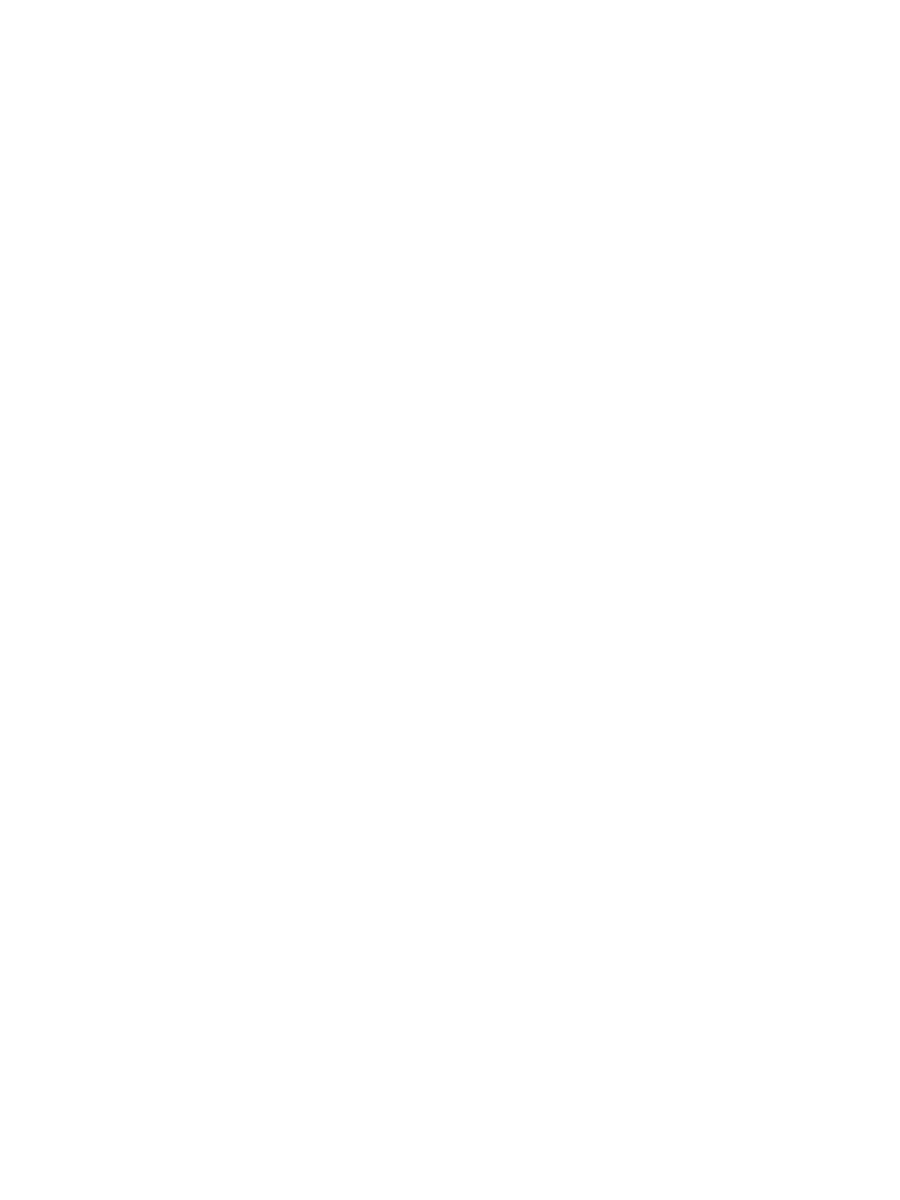

In [29]:
D1_u_medians, D1_u_rms = plot_rms_mags(0, D1, D1_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


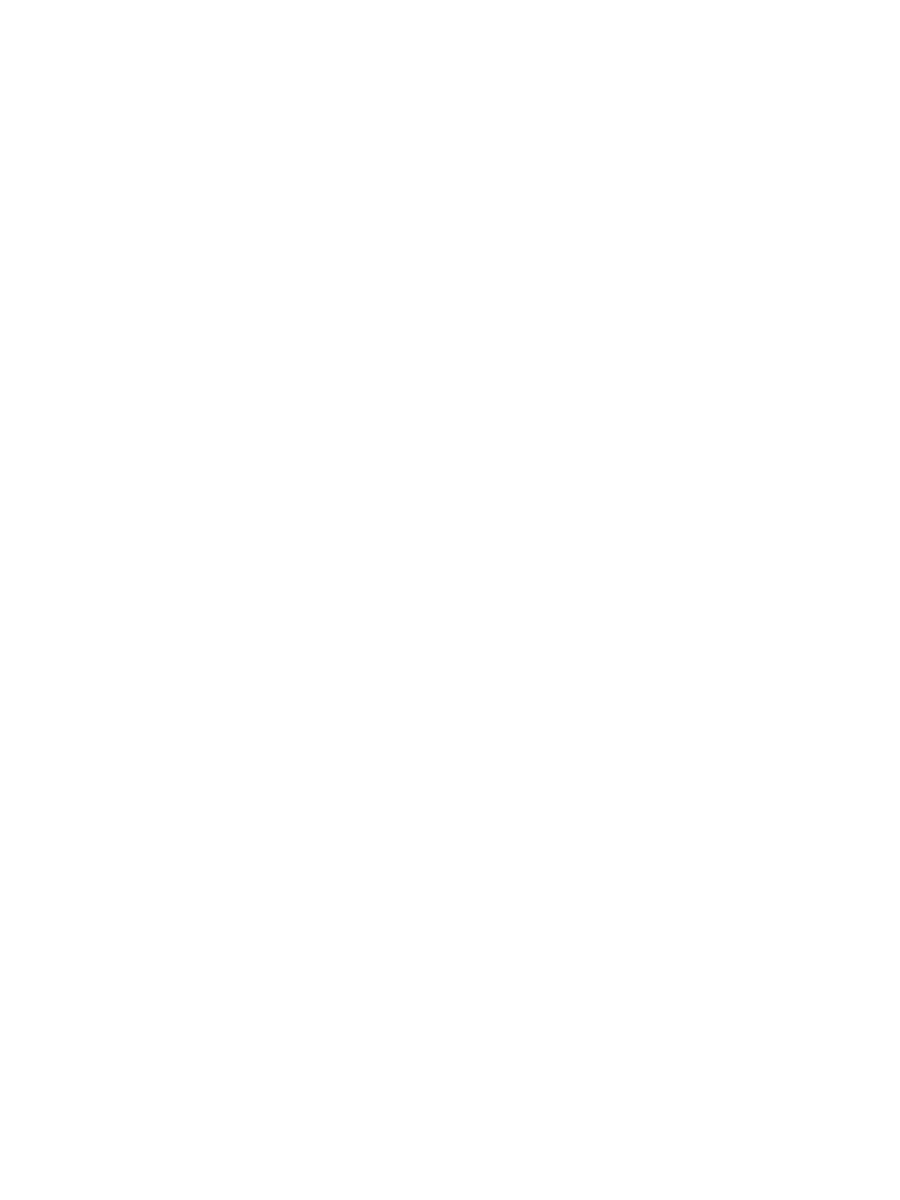

In [30]:
D1_g_medians, D1_g_rms = plot_rms_mags(1, D1, D1_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


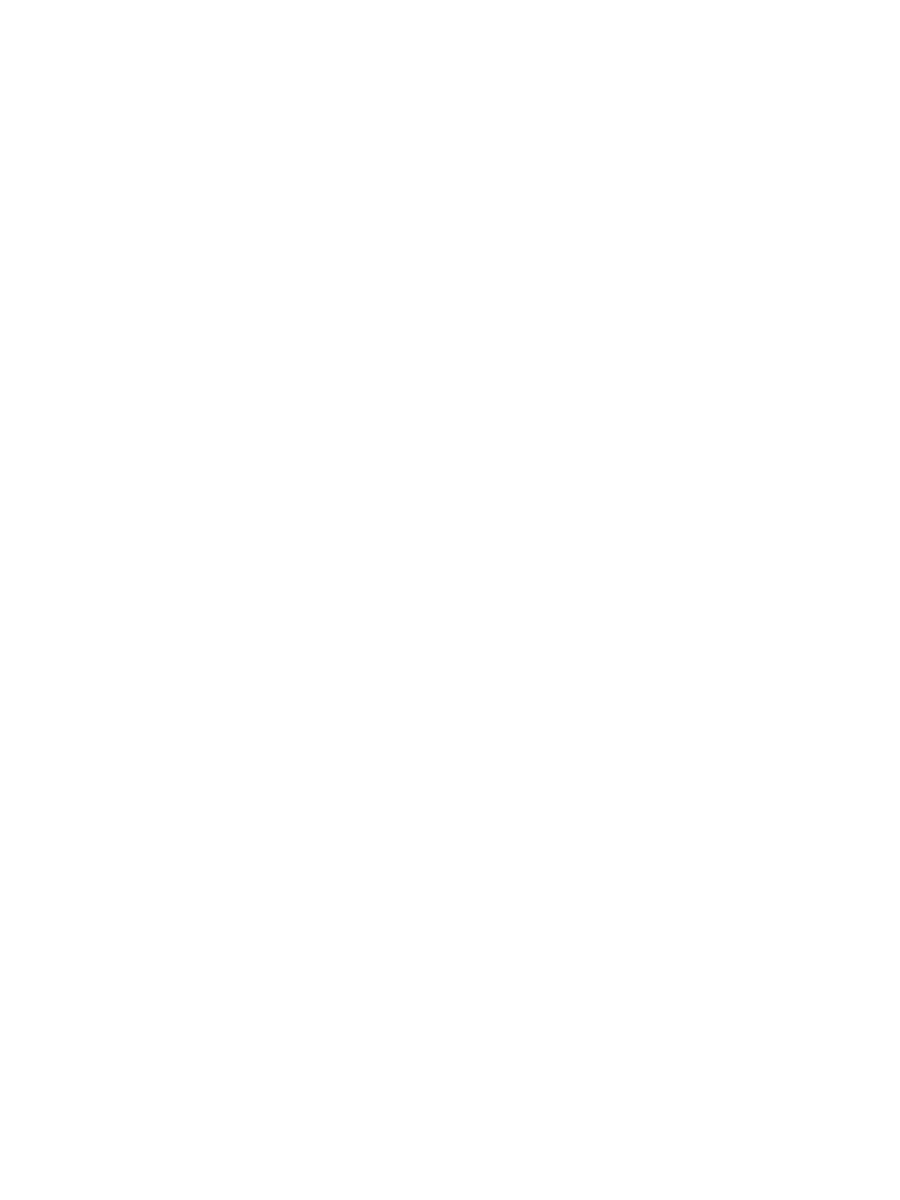

In [31]:
D1_r_medians, D1_r_rms = plot_rms_mags(2, D1, D1_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


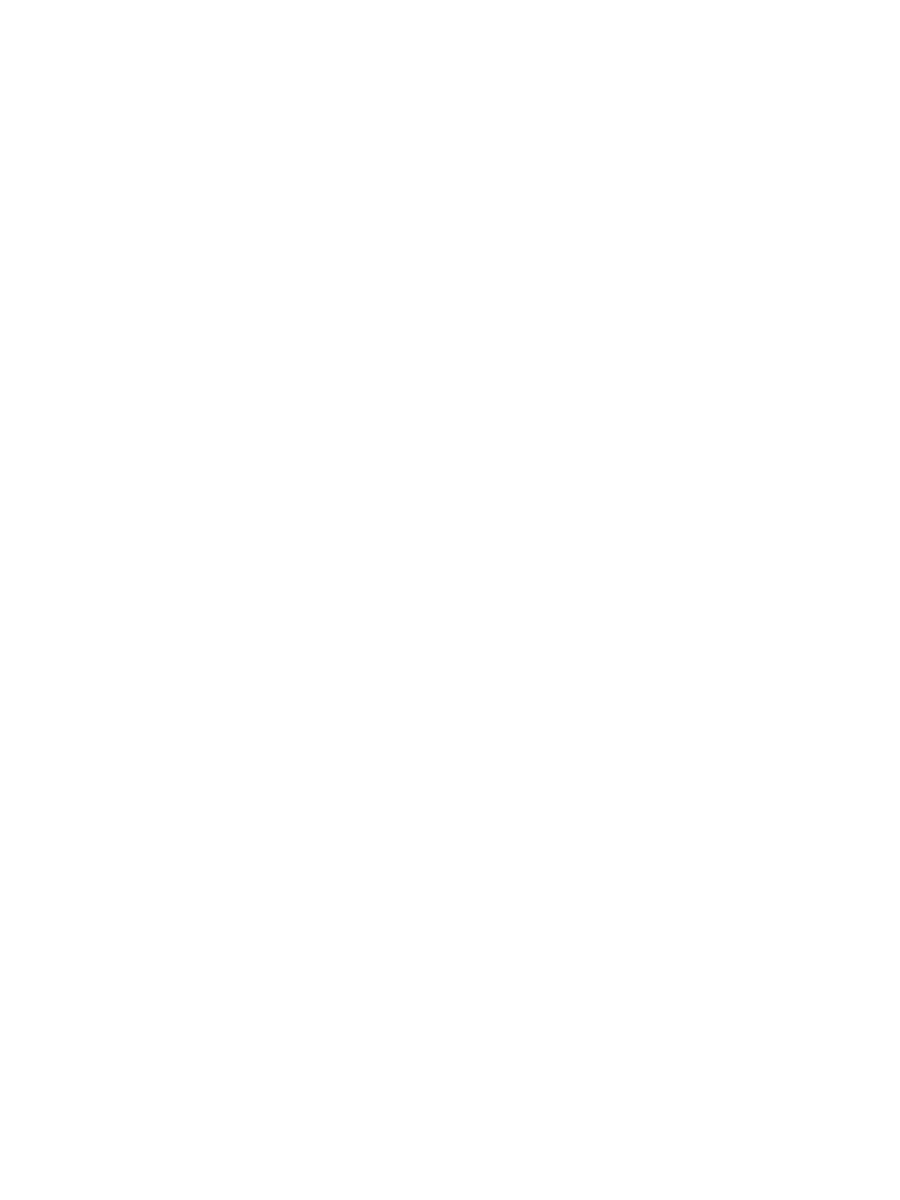

In [32]:
D1_i_medians, D1_i_rms = plot_rms_mags(3, D1, D1_sigma)

<IPython.core.display.Javascript object>


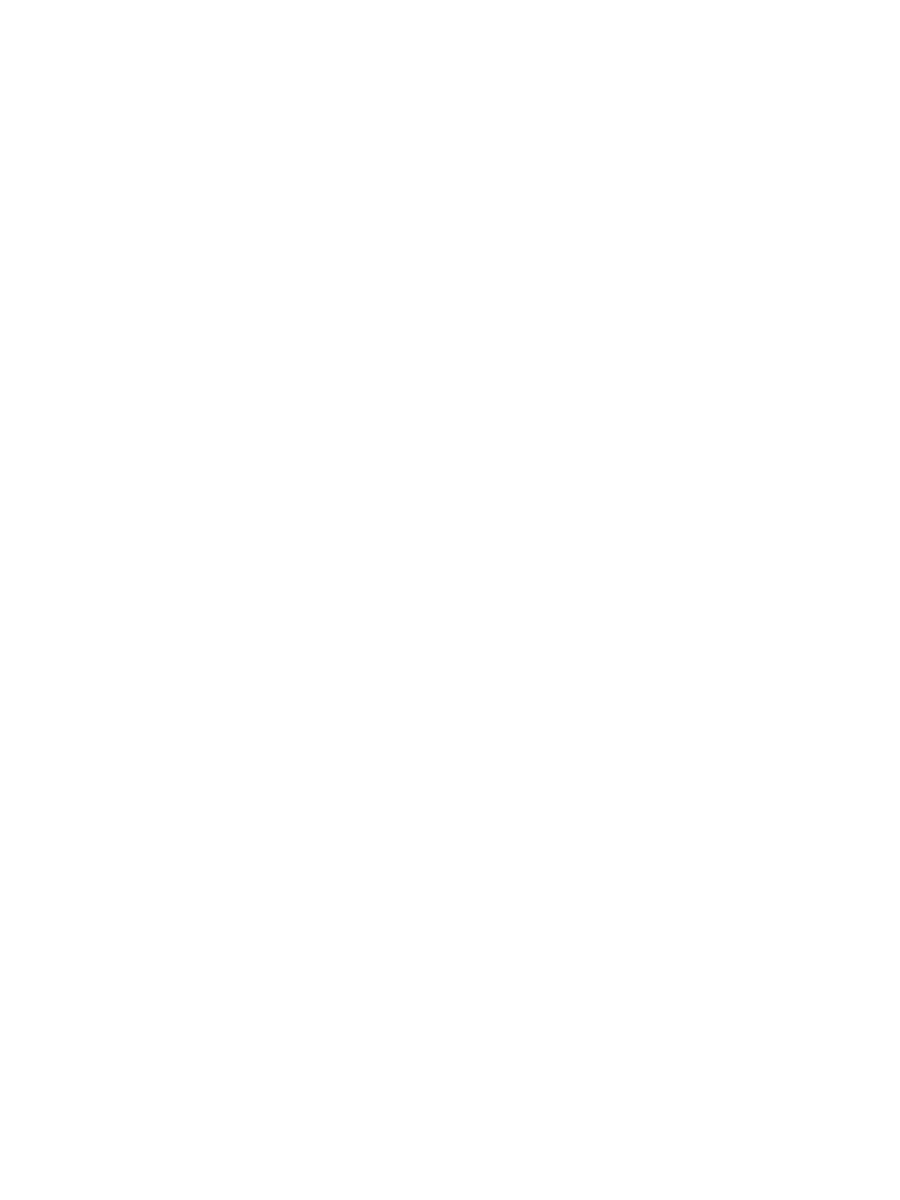

In [33]:
D1_z_medians, D1_z_rms = plot_rms_mags(4, D1, D1_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


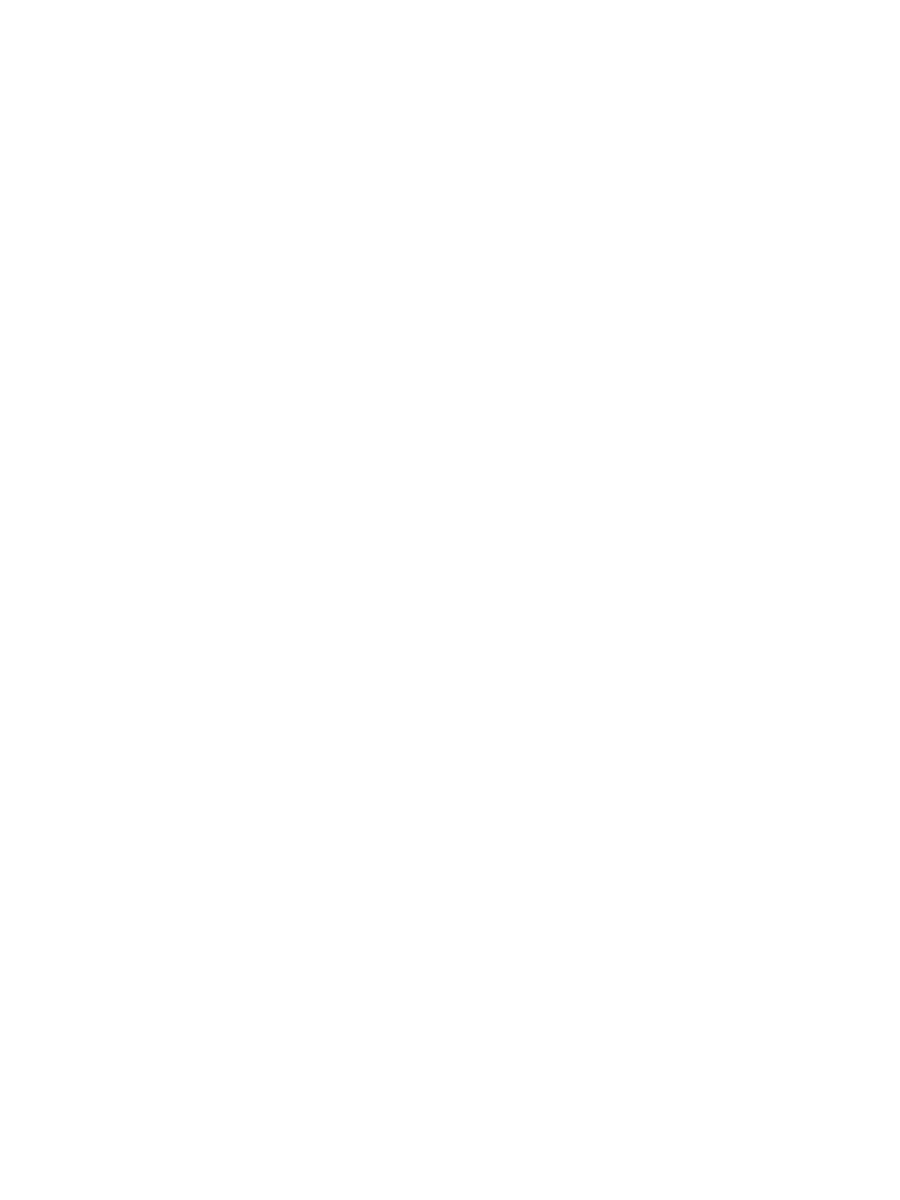

In [34]:
D2_u_medians, D2_u_rms = plot_rms_mags(0, D2, D2_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


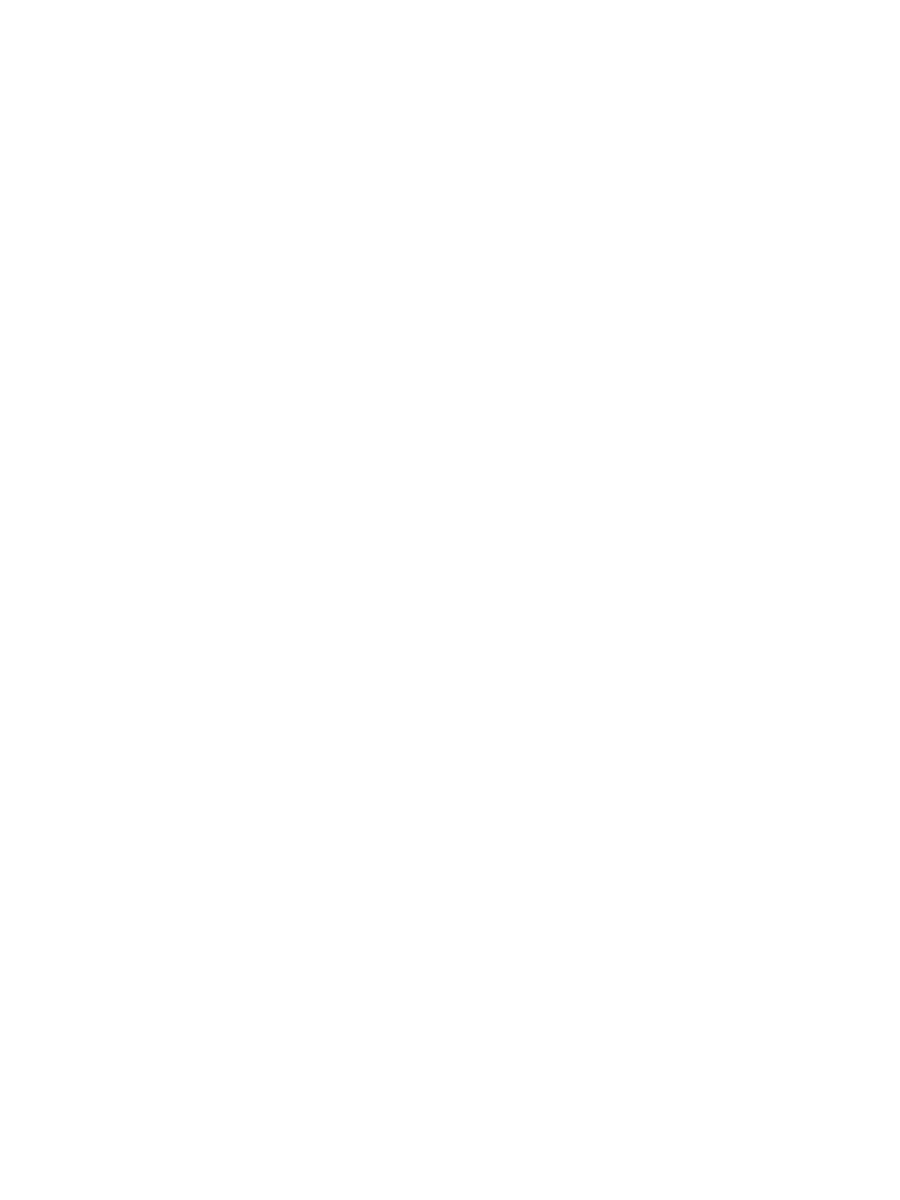

In [35]:
D2_g_medians, D2_g_rms = plot_rms_mags(1, D2, D2_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


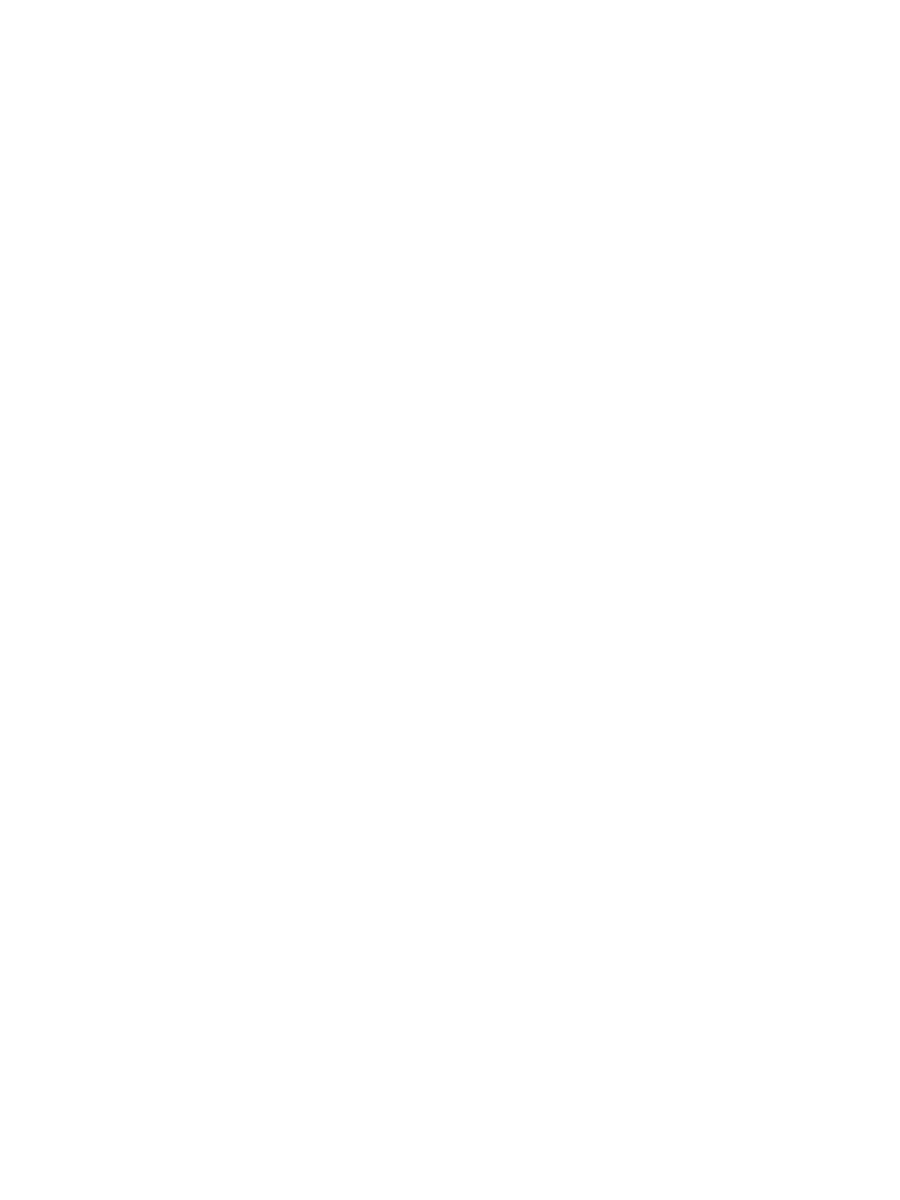

In [36]:
D2_r_medians, D2_r_rms = plot_rms_mags(2, D2, D2_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


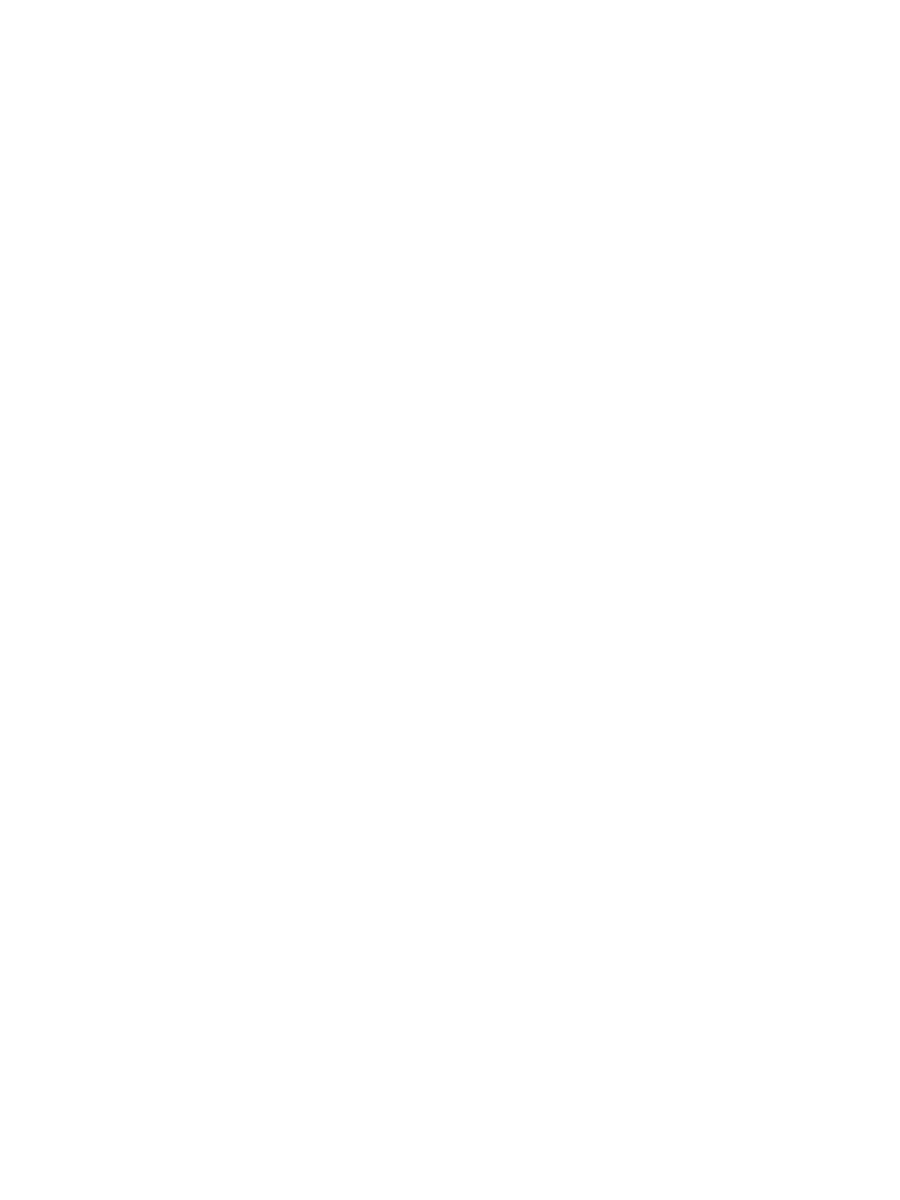

In [37]:
D2_i_medians, D2_i_rms = plot_rms_mags(3, D2, D2_sigma)

<IPython.core.display.Javascript object>


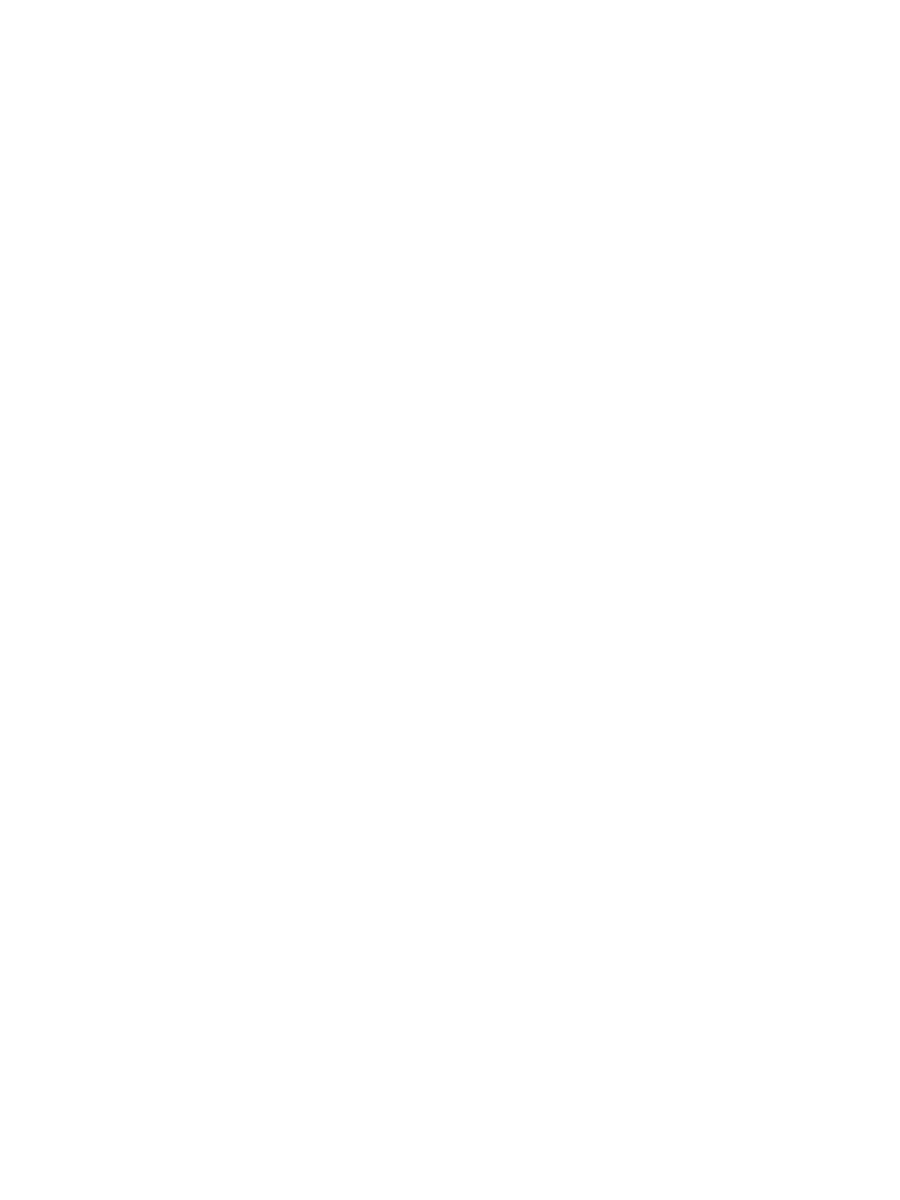

In [38]:
D2_z_medians, D2_z_rms = plot_rms_mags(4, D2, D2_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


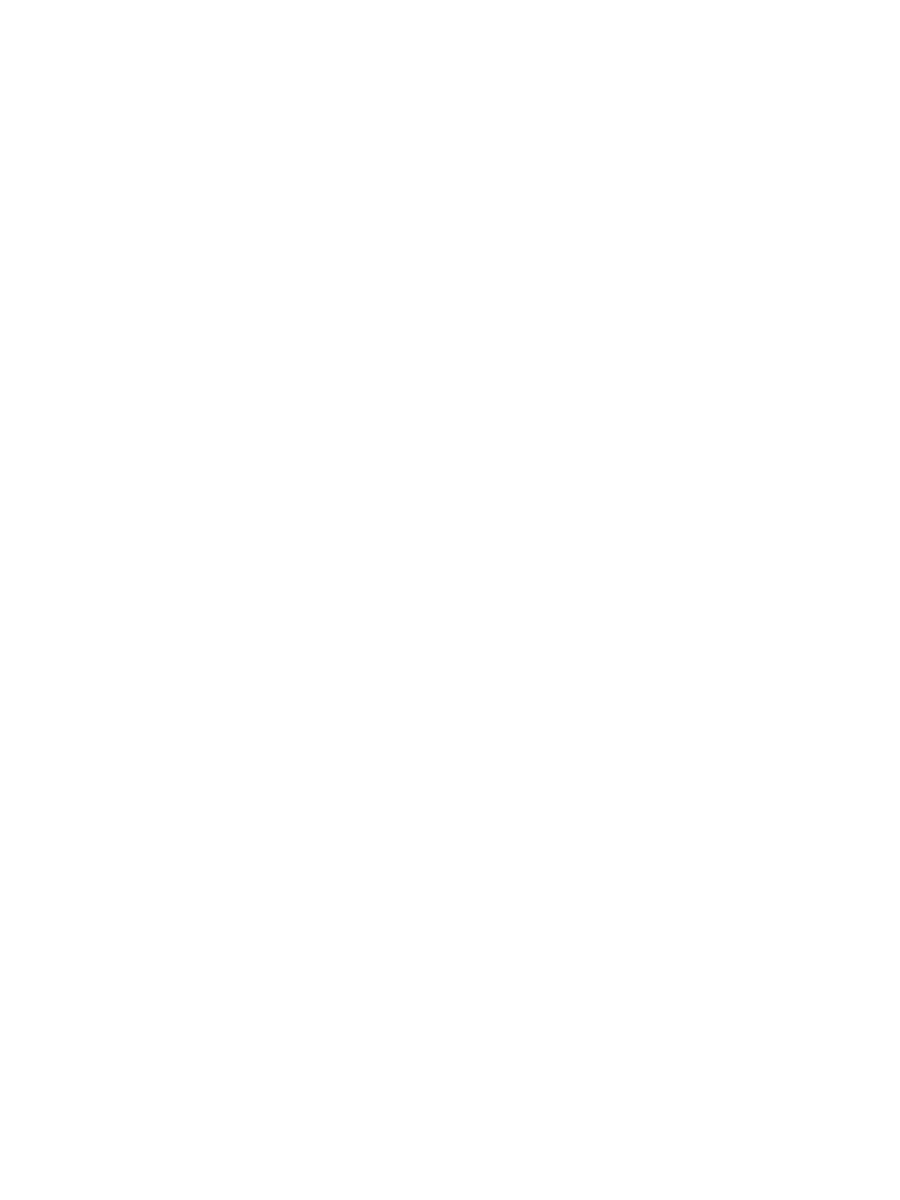

In [39]:
D3_u_medians, D3_u_rms = plot_rms_mags(0, D3, D3_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


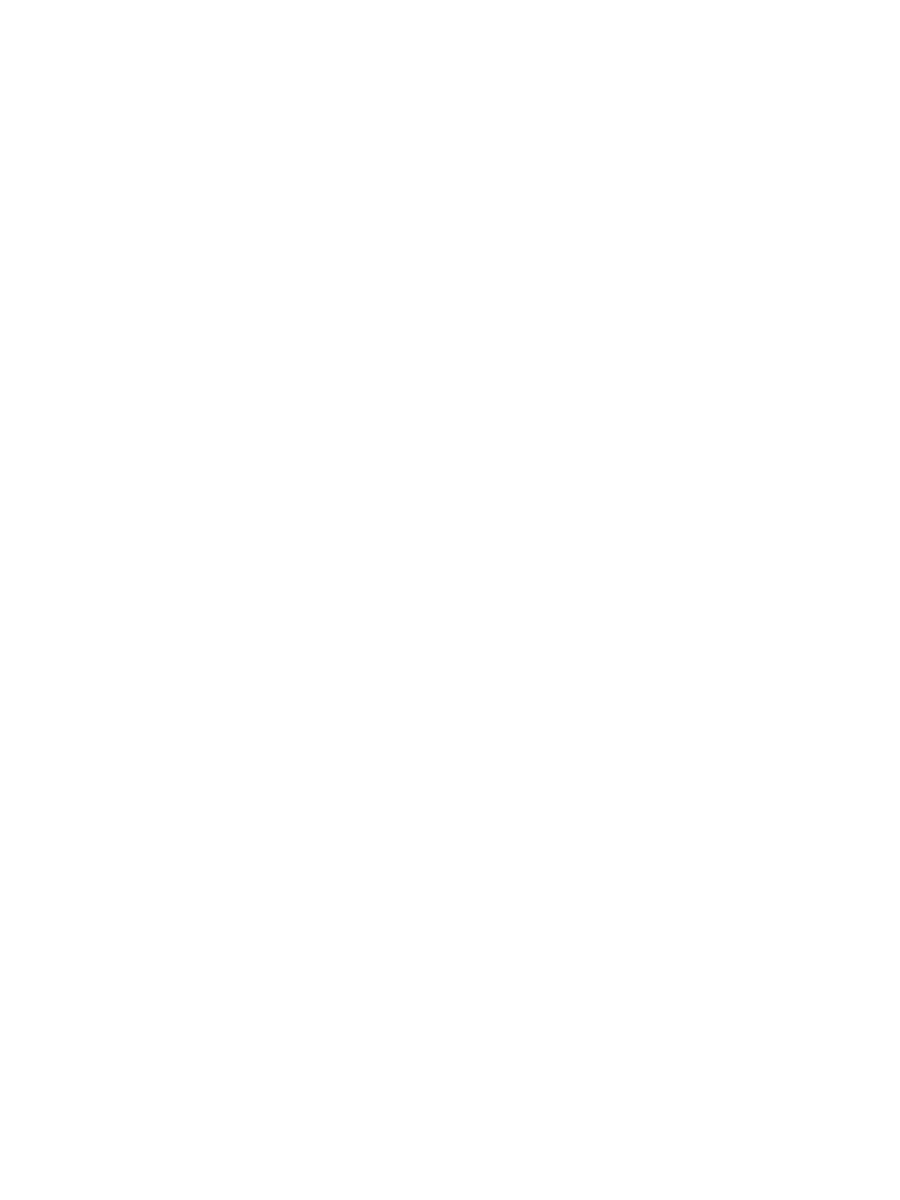

In [40]:
D3_g_medians, D3_g_rms = plot_rms_mags(1, D3, D3_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


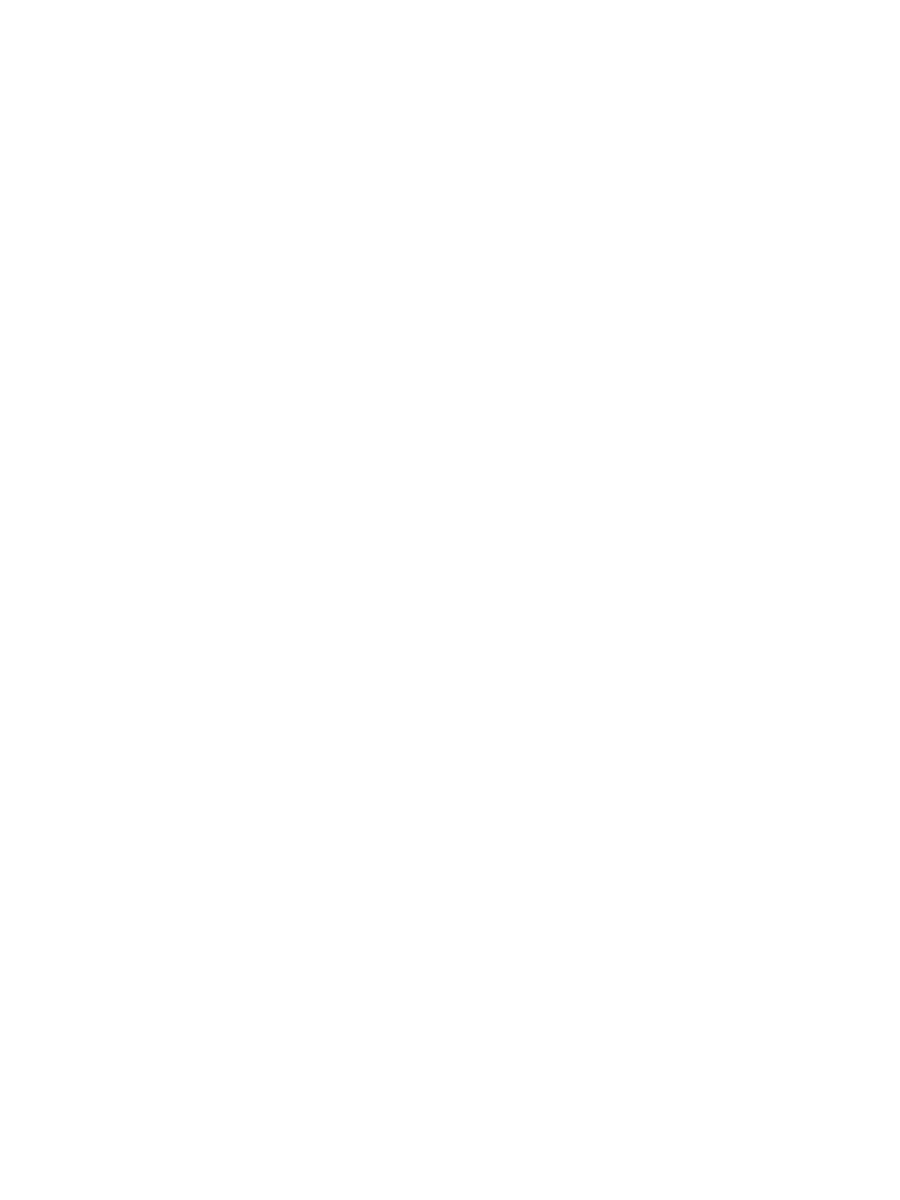

In [41]:
D3_r_medians, D3_r_rms = plot_rms_mags(2, D3, D3_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


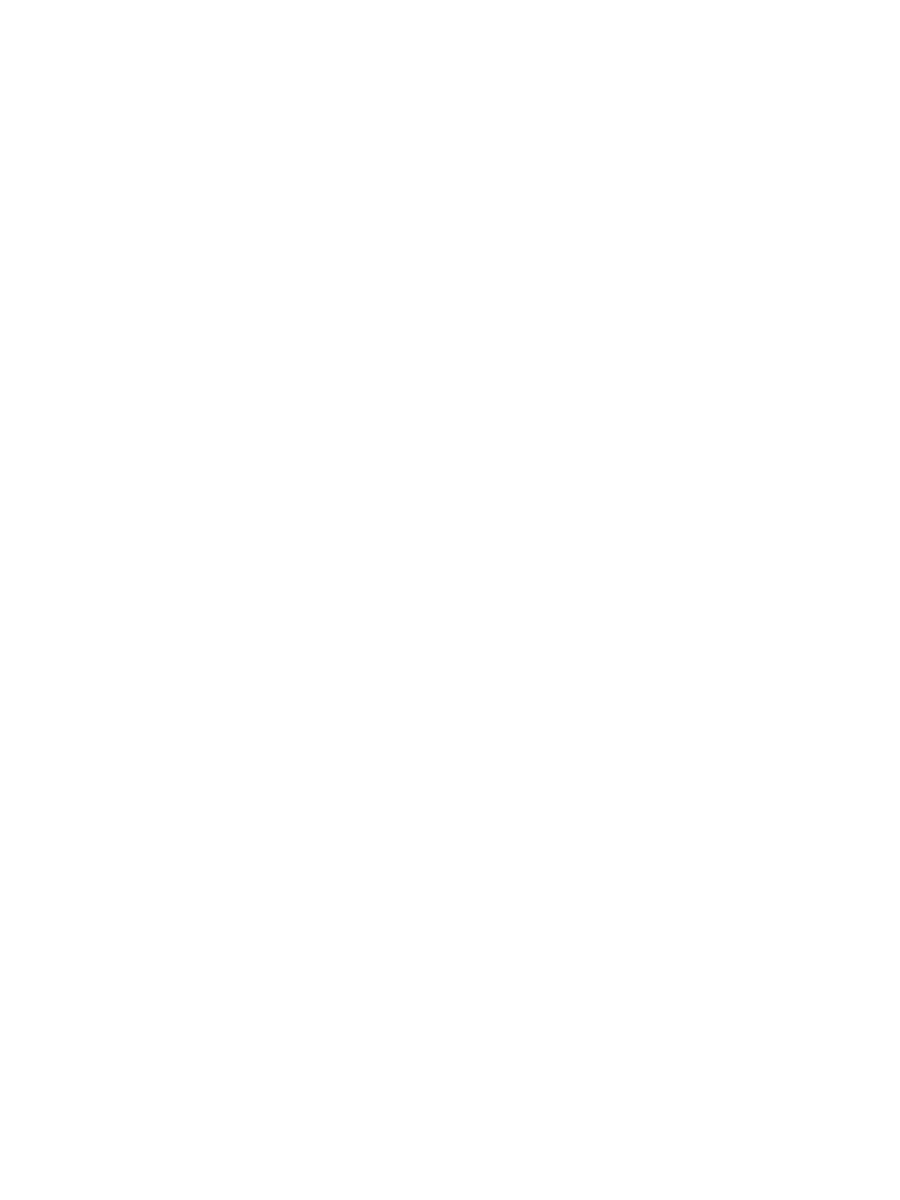

In [42]:
D3_i_medians, D3_i_rms = plot_rms_mags(3, D3, D3_sigma)

<IPython.core.display.Javascript object>


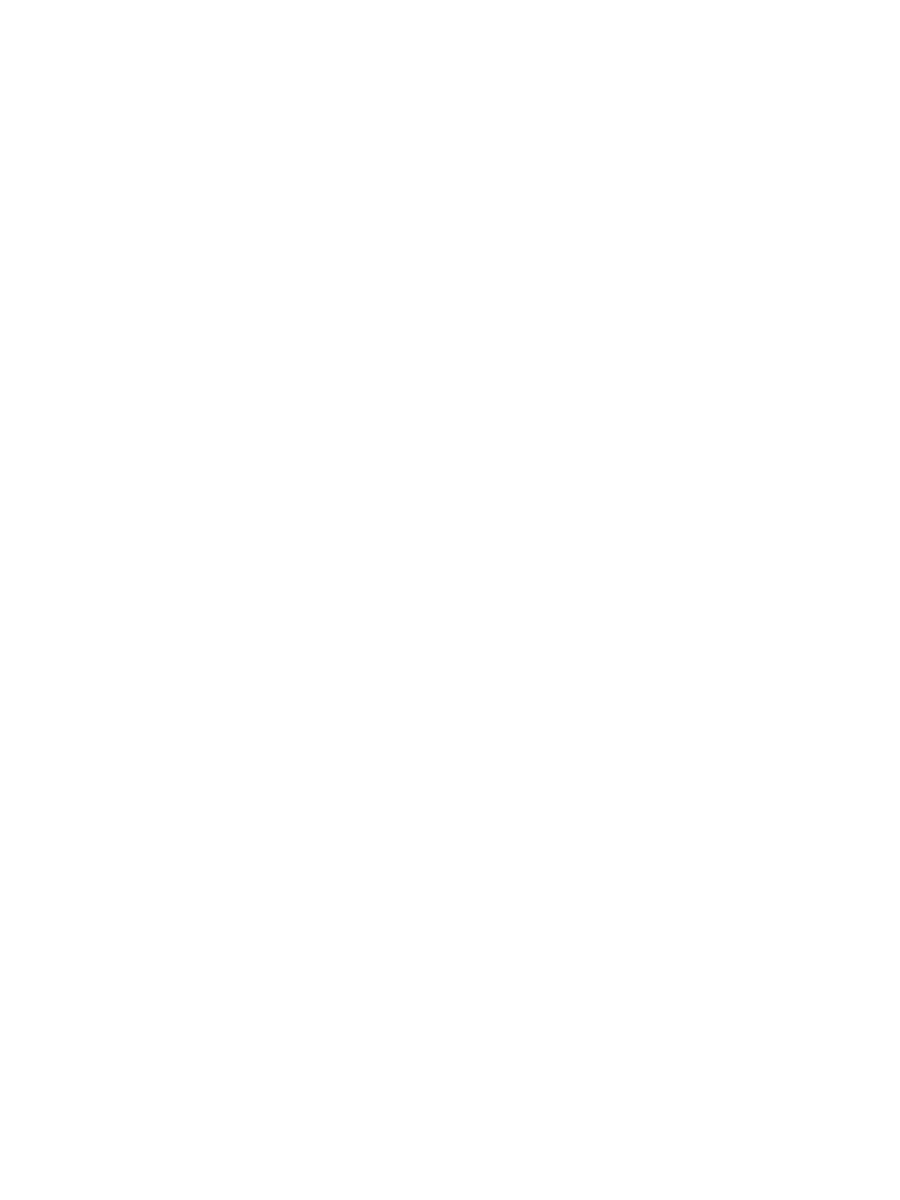

In [43]:
D3_z_medians, D3_z_rms = plot_rms_mags(4, D3, D3_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


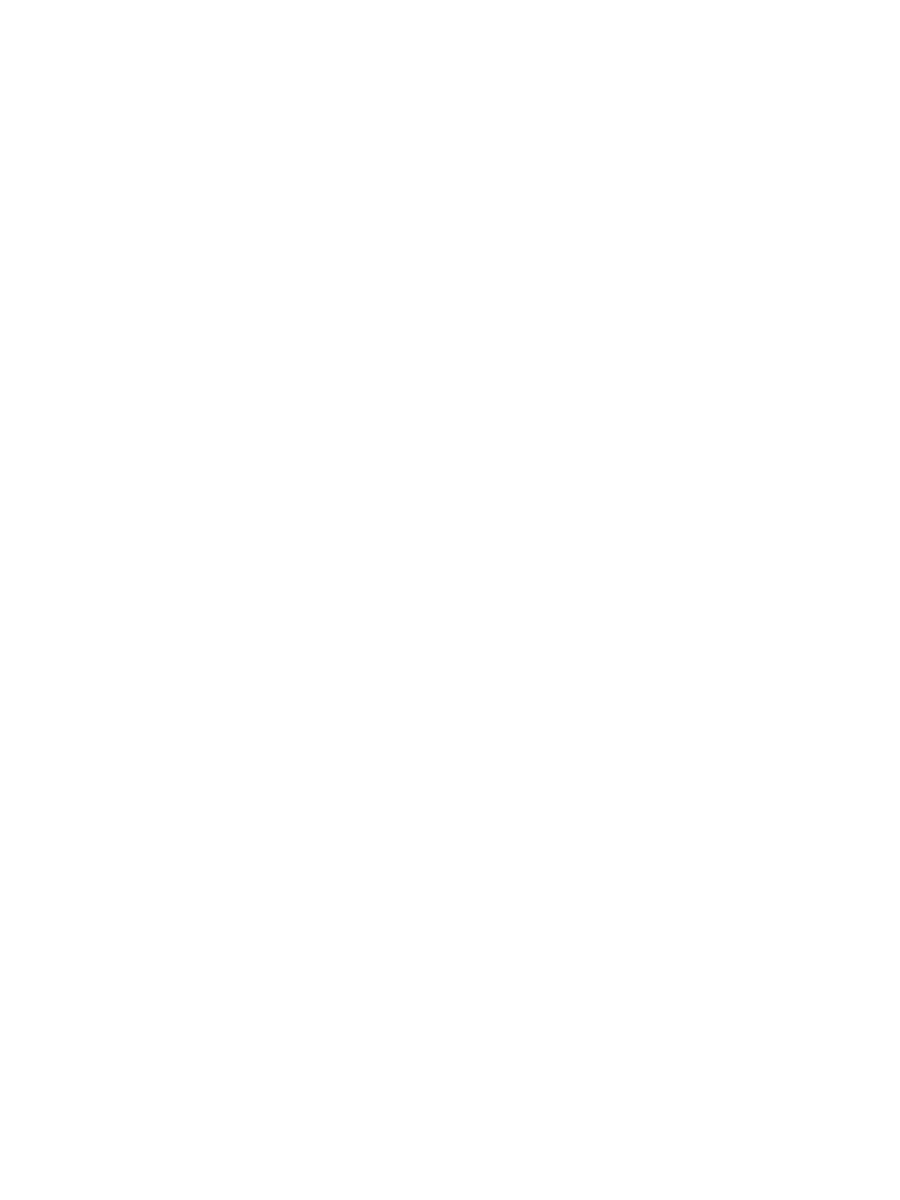

In [44]:
D4_u_medians, D4_u_rms = plot_rms_mags(0, D4, D4_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


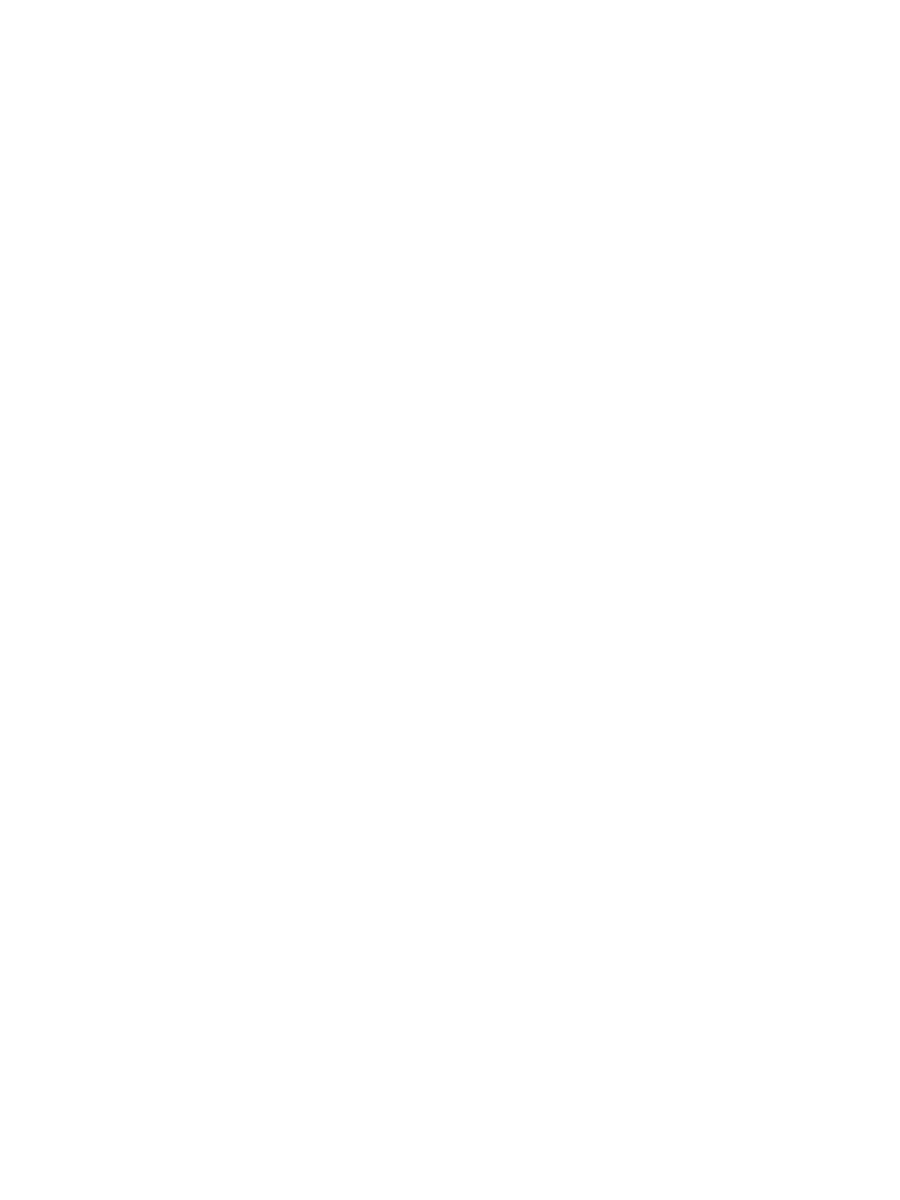

In [45]:
D4_g_medians, D4_g_rms = plot_rms_mags(1, D4, D4_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


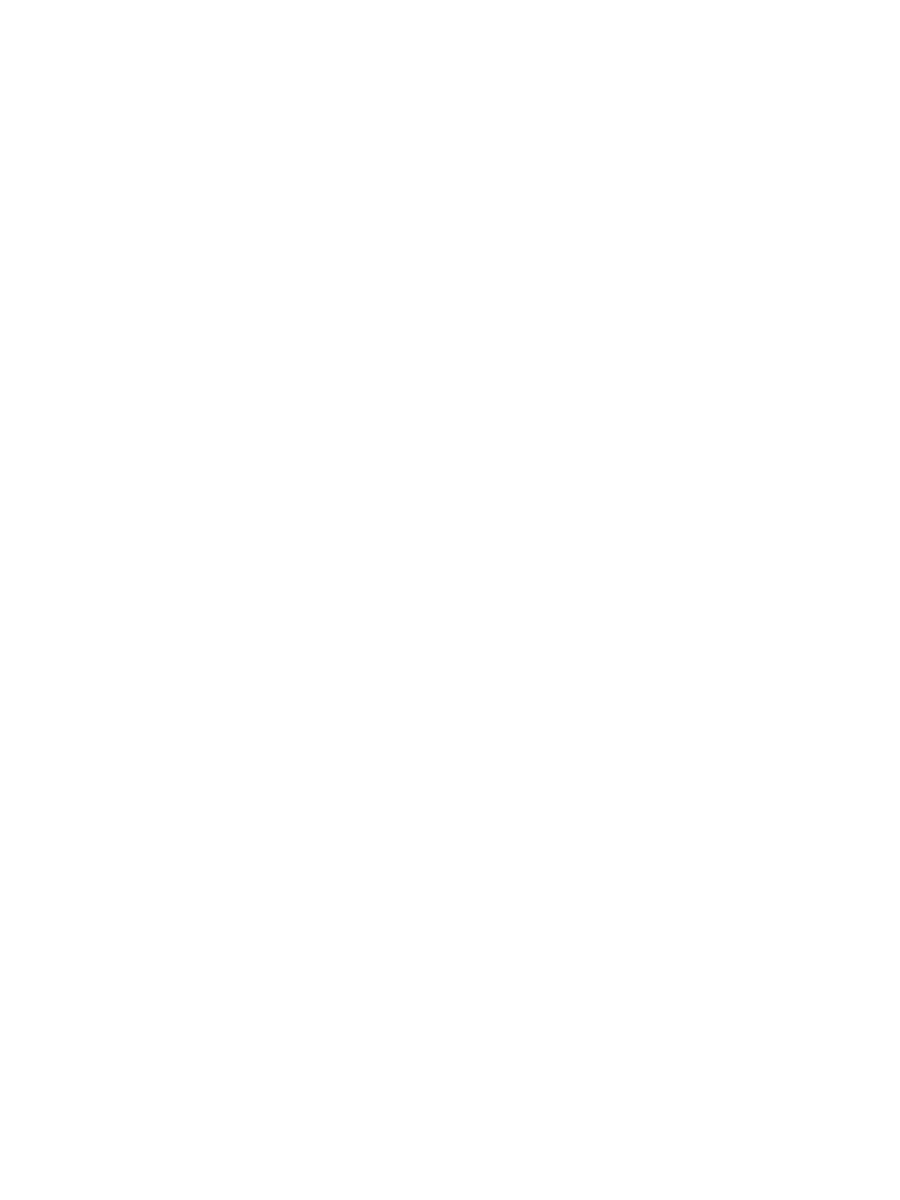

In [46]:
D4_r_medians, D4_r_rms = plot_rms_mags(2, D4, D4_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


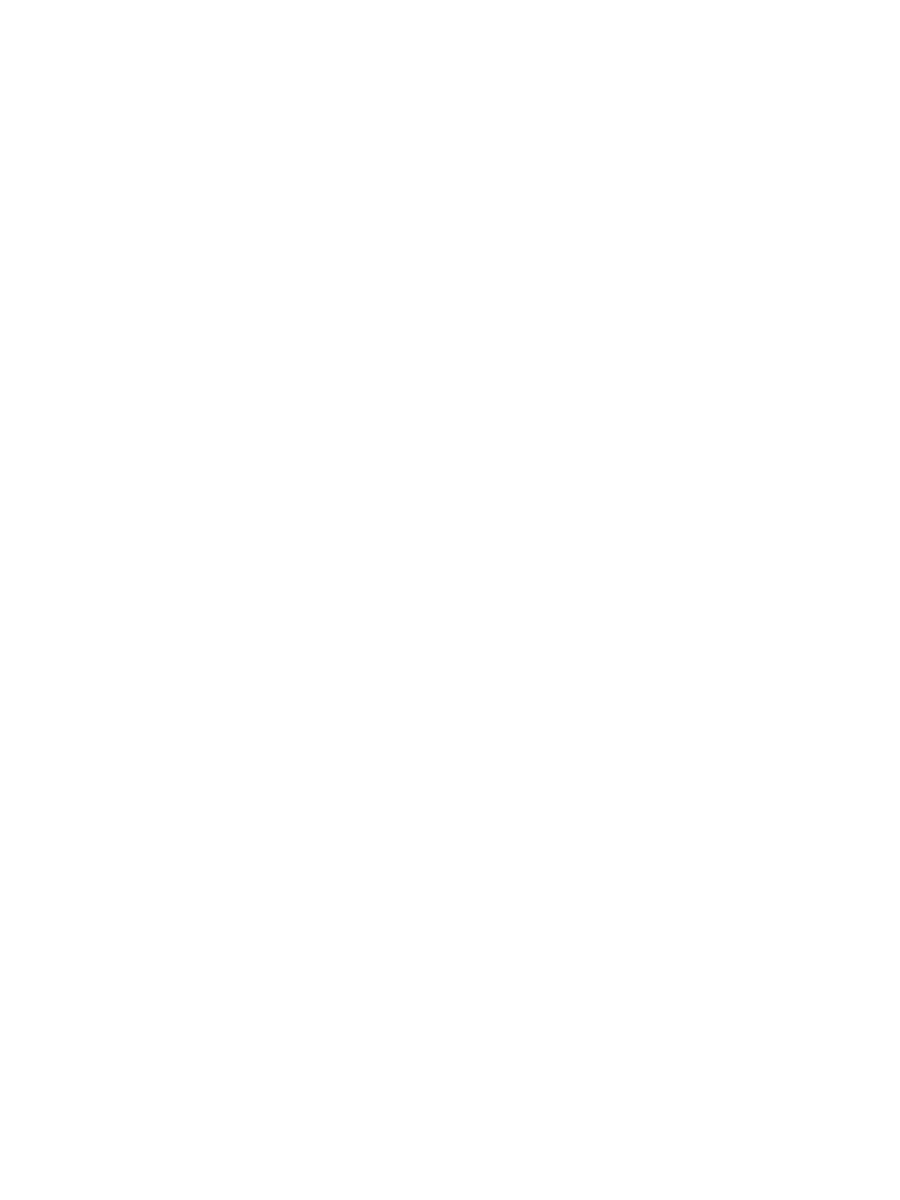

In [47]:
D4_i_medians, D4_i_rms = plot_rms_mags(3, D4, D4_sigma)

<IPython.core.display.Javascript object>


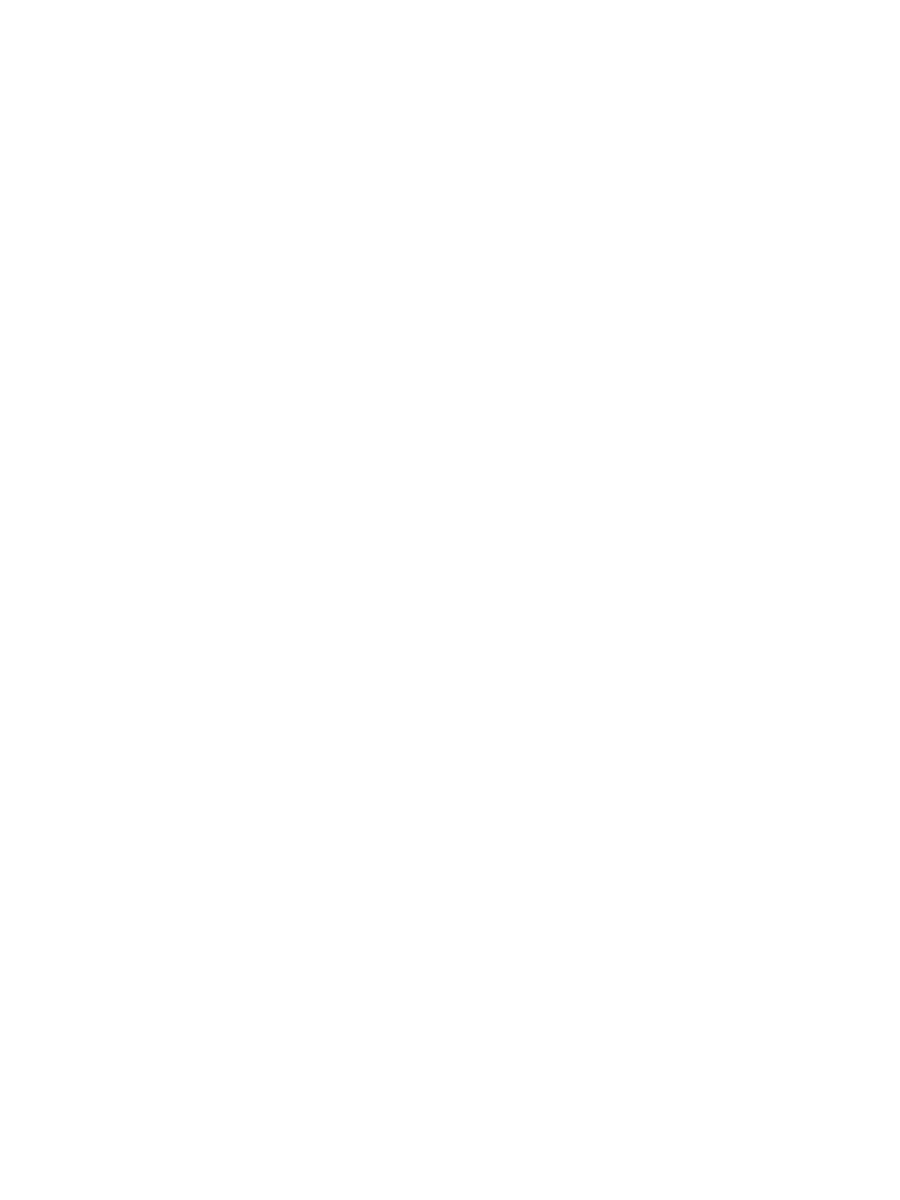

In [48]:
D4_z_medians, D4_z_rms = plot_rms_mags(4, D4, D4_sigma)

In [49]:
D1_u_rms_squared = np.square(D1_u_rms)
D1_g_rms_squared = np.square(D1_g_rms)
D1_r_rms_squared = np.square(D1_r_rms)
D1_i_rms_squared = np.square(D1_i_rms)
D1_z_rms_squared = np.square(D1_z_rms)

D2_u_rms_squared = np.square(D2_u_rms)
D2_g_rms_squared = np.square(D2_g_rms)
D2_r_rms_squared = np.square(D2_r_rms)
D2_i_rms_squared = np.square(D2_i_rms)
D2_z_rms_squared = np.square(D2_z_rms)

D3_u_rms_squared = np.square(D3_u_rms)
D3_g_rms_squared = np.square(D3_g_rms)
D3_r_rms_squared = np.square(D3_r_rms)
D3_i_rms_squared = np.square(D3_i_rms)
D3_z_rms_squared = np.square(D3_z_rms)

D4_u_rms_squared = np.square(D4_u_rms)
D4_g_rms_squared = np.square(D4_g_rms)
D4_r_rms_squared = np.square(D4_r_rms)
D4_i_rms_squared = np.square(D4_i_rms)
D4_z_rms_squared = np.square(D4_z_rms)

In [50]:
def not_plot_rms_mags (band, mags, mags_for_median, err):
    """
    Function that plots median magnitude vs. decimal log rms for a given filter and given field.
    Parameters
    ---
    band: int for filter (0 = u, 1 = g, ..., 4 = z)
    mags: choose from D1, D2, D3, D4
    mags_for_median: choose from 4.5 sigma clipped mags; choose from D1_sigma, D2_sigma, D3_sigma, D4_sigma
    Returns
    ---
    Plot of median magnitudes vs. log rms for a specific band and specific field
    """
    all_true_mags = []
    median_mags = []
    medians = []
    all_rms = []
    all_rms_two = []
    medians_for_pink = []
    """
    for i in range(len(mags)):
        true_mags = [mags[i][band][j] for j in range(len(mags[i][band]))]
        all_true_mags.append(true_mags)
    for i in range(len(mags_for_median)):
        temp_mags_for_median = [mags_for_median[i][band][j] for j in range(len(mags_for_median[i][band]))]
        median_mags.append(temp_mags_for_median)
    for i in range(len(all_true_mags)):
        squared_differences = []
        median = np.median(all_true_mags[i])
        medians.append(median)
        for j in range(len(all_true_mags[i])):
            difference = all_true_mags[i][j] - median
            squared_differences.append(difference * difference)
            rms = np.mean(squared_differences) ** 0.5
        all_rms.append(rms)
    for i in range(len(median_mags)):
        squared_differences_two = []
        median_two = np.median(median_mags[i])
        medians_for_pink.append(median_two)
        for j in range(len(median_mags[i])):
            difference = median_mags[i][j] - median_two
            squared_differences_two.append(difference * difference)
            rms = np.mean(squared_differences_two) ** 0.5
        all_rms_two.append(rms)
    """
    #simplified
    for i in range(len(mags)):
        true_mags = [mags[i][band][j] for j in range(len(mags[i][band]))]
        all_true_mags.append(true_mags)
        temp_mags_for_median = [mags_for_median[i][band][j] for j in range(len(mags_for_median[i][band]))]
        median_mags.append(temp_mags_for_median)
    ####
    for i in range(len(all_true_mags)): #going through 5-sigma clipped mags (i is each object)
        squared_differences = []
        median = np.median(all_true_mags[i]) #median for 1 object's magnitudes in a specific filter (see: band parameter)
        medians.append(median) #medians = x-vals for blue dots
        differences = [all_true_mags[i][j] - median for j in range(len(all_true_mags[i]))]
        squared_differences.extend([i * i for i in differences])
        rms = np.mean(squared_differences) ** 0.5
        all_rms.append(rms)
        #second part
        squared_differences_two = []
        median_two = np.median(median_mags[i])
        medians_for_pink.append(median_two)
        differences_two = [median_mags[i][j] - median_two for j in range(len(median_mags[i]))]
        squared_differences_two.extend([i * i for i in differences_two])
        rms = np.mean(squared_differences_two) ** 0.5
        all_rms_two.append(rms)
    
    red_rms = []
    in_bin_medians = []
    bounds = np.arange(min(medians_for_pink), max(medians_for_pink), 0.2)
    for i in range(len(bounds) - 1):
        in_bin = []
        temp_rms = []
        for j in range(len(medians_for_pink)):
            if(bounds[i] < medians_for_pink[j] and bounds[i+1] > medians_for_pink[j]):
                in_bin.append(medians_for_pink[j])
                temp_rms.append(all_rms_two[j])
        in_bin_medians.append(np.median(in_bin))
        red_rms.append(np.median(temp_rms))
    nan_bool_x = np.isnan(in_bin_medians)
    nan_bool_y = np.isnan(red_rms)
    in_bin_medians = np.delete(in_bin_medians, nan_bool_x)
    red_rms = np.delete(red_rms, nan_bool_y)
    for_color = np.empty_like(red_rms)
    #plt.figure(figsize = (9, 12))
    #plt.scatter(medians,np.log10(all_rms), s = 0.05)
    #plt.scatter(in_bin_medians,np.log10(red_rms), s = 13, c = "crimson")#c = for_color, cmap = 'PuRd'
    if band == 0:
        plt.ylabel(r'$\sigma_%s$' % 'u')
        plt.xlabel(r'$<%s>$' % 'u')
        if mags == D1:
            X = (in_bin_medians[6:len(in_bin_medians)-3])
            y = np.log10(red_rms[6:len(red_rms) - 3])
        elif mags == D2:
            X = (in_bin_medians[6:len(in_bin_medians)-5])
            y = np.log10(red_rms[6:len(red_rms) - 5])
        elif mags == D3:
            X = (in_bin_medians[10:len(in_bin_medians)-6])
            y = np.log10(red_rms[10:len(red_rms) - 6])
        elif mags == D4:
            X = (in_bin_medians[8:len(in_bin_medians)-6])
            y = np.log10(red_rms[8:len(red_rms) - 6])
    elif band == 1:
        plt.ylabel(r'$\sigma_%s$' % 'g')
        plt.xlabel(r'$<%s>$' % 'g')
        if mags == D1:
            X = (in_bin_medians[4:len(in_bin_medians)-2])
            y = np.log10(red_rms[4:len(red_rms) - 2])
        elif mags == D2:
            X = (in_bin_medians[8:len(in_bin_medians)-2])
            y = np.log10(red_rms[8:len(red_rms) - 2])
        elif mags == D3:
            X = (in_bin_medians[9:len(in_bin_medians)-1])
            y = np.log10(red_rms[9:len(red_rms)-1])
        elif mags == D4:
            X = (in_bin_medians[0:len(in_bin_medians)-8])
            y = np.log10(red_rms[0:len(red_rms)-8])
    elif band == 2:
        plt.ylabel(r'$\sigma_%s$' % 'r')
        plt.xlabel(r'$<%s>$' % 'r')
        if mags == D1:
            X = (in_bin_medians[9:len(in_bin_medians)-4])
            y = np.log10(red_rms[9:len(red_rms)-4])
        elif mags == D2:
            X = (in_bin_medians[9:len(in_bin_medians)-2])
            y = np.log10(red_rms[9:len(red_rms)-2])
        elif mags == D3:
            X = (in_bin_medians[12:len(in_bin_medians)-2])
            y = np.log10(red_rms[12:len(red_rms)-2])
        elif mags == D4:
            X = (in_bin_medians[17:len(in_bin_medians)-5])
            y = np.log10(red_rms[17:len(red_rms)-5])
    elif band == 3:
        plt.ylabel(r'$\sigma_%s$' % 'i')
        plt.xlabel(r'$<%s>$' % 'i')
        if mags == D1:
            X = (in_bin_medians[12:len(in_bin_medians)-3])
            y = np.log10(red_rms[12:len(red_rms)-3])
        elif mags == D2:
            X = (in_bin_medians[14:len(in_bin_medians)])
            y = np.log10(red_rms[14:len(red_rms)])
        elif mags == D3:
            X = (in_bin_medians[25:len(in_bin_medians)-1])
            y = np.log10(red_rms[25:len(red_rms)-1])
        elif mags == D4:
            X = (in_bin_medians[16:len(in_bin_medians)-5])
            y = np.log10(red_rms[16:len(red_rms)-5])
    elif band == 4:
        plt.ylabel(r'$\sigma_%s$' % 'z')
        plt.xlabel(r'$<%s>$' % 'z')
        if mags == D1:
            X = (in_bin_medians[10:len(in_bin_medians)-6])
            y = np.log10(red_rms[10:len(red_rms)-6])
        elif mags == D2:
            X = (in_bin_medians[15:len(in_bin_medians)-4])
            y = np.log10(red_rms[15:len(red_rms)-4])
        elif mags == D3:
            X = (in_bin_medians[14:len(in_bin_medians)-4])
            y = np.log10(red_rms[14:len(red_rms)-4])
        elif mags == D4:
            X = (in_bin_medians[14:len(in_bin_medians)-4])
            y = np.log10(red_rms[14:len(red_rms)-4])
    
    X = np.asarray(X).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    degree=4
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(X,y)
    #plt.plot(X,polyreg.predict(X),color="black")
    #plt.title("Polynomial regression with degree "+str(degree))
    #degree=61
    #polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    #polyreg.fit(X,y)
    #plt.plot(X,polyreg.predict(X),color="black")
    #plt.title("Polynomial regression with degree "+str(degree))
    #print("RMSE: " + str(sklearn.metrics.mean_squared_error(y,polyreg.predict(X))))
    val = np.array(err)
    val_input = val.reshape(1, -1)
    val_output = polyreg.predict(val_input)
    #plt.show()
    return val_output

In [51]:
another_stuff = not_plot_rms_mags(1, D4, D4_sigma, 24)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [52]:
another_stuff

array([[-0.54475037]])

In [53]:
10**another_stuff

array([[0.28526575]])

In [54]:
#Does what plot_rms_mags does EXCEPT the x axis is decimal log rms and the y axis is median magnitude
#Used for finding the median magnitude given a measurement error
def plot_rms_mags_inverted (band, mags, mags_for_median, err):
    """
    Function that plots median magnitude vs. decimal log rms for a given filter and given field.
    Parameters
    ---
    band: int for filter (0 = u, 1 = g, ..., 4 = z)
    mags: choose from D1, D2, D3, D4
    mags_for_median: choose from D1_sigma, D2_sigma, D3_sigma, D4_sigma
    err: desired measurement error (NOT IN DECIMAL LOG)
    Returns
    ---
    var_output: median magnitude for specified err
    """
    all_true_mags = []
    median_mags = []
    medians = []
    all_rms = []
    all_rms_two = []
    medians_for_pink = []
    """
    for i in range(len(mags)):
        true_mags = [mags[i][band][j] for j in range(len(mags[i][band]))]
        all_true_mags.append(true_mags)
    for i in range(len(mags_for_median)):
        temp_mags_for_median = [mags_for_median[i][band][j] for j in range(len(mags_for_median[i][band]))]
        median_mags.append(temp_mags_for_median)
    for i in range(len(all_true_mags)):
        squared_differences = []
        median = np.median(all_true_mags[i])
        medians.append(median)
        for j in range(len(all_true_mags[i])):
            difference = all_true_mags[i][j] - median
            squared_differences.append(difference * difference)
            rms = np.mean(squared_differences) ** 0.5
        all_rms.append(rms)
    for i in range(len(median_mags)):
        squared_differences_two = []
        median_two = np.median(median_mags[i])
        medians_for_pink.append(median_two)
        for j in range(len(median_mags[i])):
            difference = median_mags[i][j] - median_two
            squared_differences_two.append(difference * difference)
            rms = np.mean(squared_differences_two) ** 0.5
        all_rms_two.append(rms)
    """
    #simplified
    for i in range(len(mags)):
        true_mags = [mags[i][band][j] for j in range(len(mags[i][band]))]
        all_true_mags.append(true_mags)
        temp_mags_for_median = [mags_for_median[i][band][j] for j in range(len(mags_for_median[i][band]))]
        median_mags.append(temp_mags_for_median)
    ####
    for i in range(len(all_true_mags)): #going through 5-sigma clipped mags (i is each object)
        squared_differences = []
        median = np.median(all_true_mags[i]) #median for 1 object's magnitudes in a specific filter (see: band parameter)
        medians.append(median) #medians = x-vals for blue dots
        differences = [all_true_mags[i][j] - median for j in range(len(all_true_mags[i]))]
        squared_differences.extend([i * i for i in differences])
        rms = np.mean(squared_differences) ** 0.5
        all_rms.append(rms)
        #second part
        squared_differences_two = []
        median_two = np.median(median_mags[i])
        medians_for_pink.append(median_two)
        differences_two = [median_mags[i][j] - median_two for j in range(len(median_mags[i]))]
        squared_differences_two.extend([i * i for i in differences_two])
        rms = np.mean(squared_differences_two) ** 0.5
        all_rms_two.append(rms)
    
    red_rms = []
    in_bin_medians = []
    bounds = np.arange(min(medians_for_pink), max(medians_for_pink), 0.2)
    for i in range(len(bounds) - 1):
        in_bin = []
        temp_rms = []
        for j in range(len(medians_for_pink)):
            if(bounds[i] < medians_for_pink[j] and bounds[i+1] > medians_for_pink[j]):
                in_bin.append(medians_for_pink[j])
                temp_rms.append(all_rms_two[j])
        in_bin_medians.append(np.median(in_bin))
        red_rms.append(np.median(temp_rms))
    nan_bool_x = np.isnan(in_bin_medians)
    nan_bool_y = np.isnan(red_rms)
    in_bin_medians = np.delete(in_bin_medians, nan_bool_x)
    red_rms = np.delete(red_rms, nan_bool_y)
    for_color = np.empty_like(red_rms)
    #plt.figure(figsize = (9, 12))
    #plt.scatter(np.log10(all_rms),medians, s = 0.05)
    #plt.scatter(np.log10(red_rms),in_bin_medians, s = 13, c = "crimson")#c = for_color, cmap = 'PuRd'
    if band == 0:
        plt.ylabel(r'$\sigma_%s$' % 'u')
        plt.xlabel(r'$<%s>$' % 'u')
        if mags == D1:
            X = (in_bin_medians[6:len(in_bin_medians)-3])
            y = np.log10(red_rms[6:len(red_rms) - 3])
        elif mags == D2:
            X = (in_bin_medians[6:len(in_bin_medians)-5])
            y = np.log10(red_rms[6:len(red_rms) - 5])
        elif mags == D3:
            X = (in_bin_medians[10:len(in_bin_medians)-6])
            y = np.log10(red_rms[10:len(red_rms) - 6])
        elif mags == D4:
            X = (in_bin_medians[8:len(in_bin_medians)-6])
            y = np.log10(red_rms[8:len(red_rms) - 6])
    elif band == 1:
        plt.ylabel(r'$\sigma_%s$' % 'g')
        plt.xlabel(r'$<%s>$' % 'g')
        if mags == D1:
            X = (in_bin_medians[4:len(in_bin_medians)-2])
            y = np.log10(red_rms[4:len(red_rms) - 2])
        elif mags == D2:
            X = (in_bin_medians[8:len(in_bin_medians)-2])
            y = np.log10(red_rms[8:len(red_rms) - 2])
        elif mags == D3:
            X = (in_bin_medians[9:len(in_bin_medians)-1])
            y = np.log10(red_rms[9:len(red_rms)-1])
        elif mags == D4:
            X = (in_bin_medians[0:len(in_bin_medians)-8])
            y = np.log10(red_rms[0:len(red_rms)-8])
    elif band == 2:
        plt.ylabel(r'$\sigma_%s$' % 'r')
        plt.xlabel(r'$<%s>$' % 'r')
        if mags == D1:
            X = (in_bin_medians[9:len(in_bin_medians)-4])
            y = np.log10(red_rms[9:len(red_rms)-4])
        elif mags == D2:
            X = (in_bin_medians[9:len(in_bin_medians)-2])
            y = np.log10(red_rms[9:len(red_rms)-2])
        elif mags == D3:
            X = (in_bin_medians[12:len(in_bin_medians)-2])
            y = np.log10(red_rms[12:len(red_rms)-2])
        elif mags == D4:
            X = (in_bin_medians[17:len(in_bin_medians)-5])
            y = np.log10(red_rms[17:len(red_rms)-5])
    elif band == 3:
        plt.ylabel(r'$\sigma_%s$' % 'i')
        plt.xlabel(r'$<%s>$' % 'i')
        if mags == D1:
            X = (in_bin_medians[12:len(in_bin_medians)-3])
            y = np.log10(red_rms[12:len(red_rms)-3])
        elif mags == D2:
            X = (in_bin_medians[14:len(in_bin_medians)])
            y = np.log10(red_rms[14:len(red_rms)])
        elif mags == D3:
            X = (in_bin_medians[25:len(in_bin_medians)-1])
            y = np.log10(red_rms[25:len(red_rms)-1])
        elif mags == D4:
            X = (in_bin_medians[16:len(in_bin_medians)-5])
            y = np.log10(red_rms[16:len(red_rms)-5])
    elif band == 4:
        plt.ylabel(r'$\sigma_%s$' % 'z')
        plt.xlabel(r'$<%s>$' % 'z')
        if mags == D1:
            X = (in_bin_medians[10:len(in_bin_medians)-6])
            y = np.log10(red_rms[10:len(red_rms)-6])
        elif mags == D2:
            X = (in_bin_medians[15:len(in_bin_medians)-4])
            y = np.log10(red_rms[15:len(red_rms)-4])
        elif mags == D3:
            X = (in_bin_medians[14:len(in_bin_medians)-4])
            y = np.log10(red_rms[14:len(red_rms)-4])
        elif mags == D4:
            X = (in_bin_medians[14:len(in_bin_medians)-4])
            y = np.log10(red_rms[14:len(red_rms)-4])
    
    X = np.asarray(X).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    degree=4
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(y,X)
    #FORNOWplt.plot(y,polyreg.predict(y),color="black")
    plt.title("Polynomial regression with degree "+str(degree))
    parameter = np.log10(err)
    var_input = parameter.reshape(1, -1)
    var_output = polyreg.predict(var_input)
    #degree=61
    #polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    #polyreg.fit(X,y)
    #plt.plot(X,polyreg.predict(X),color="black")
    #plt.title("Polynomial regression with degree "+str(degree))
    #print("RMSE: " + str(sklearn.metrics.mean_squared_error(y,polyreg.predict(X))))
    #FORNOWplt.show()
    return var_output

In [55]:
stuff = plot_rms_mags_inverted(4, D4, D4_sigma, 0.2)

In [56]:
print(stuff)

[[21.16638327]]


In [57]:
def plot_rms_mags_together(band, mags, mags_for_median, field_name, color_val = "black"):
    """
    Function that plots median magnitude vs. rms for a given filter.
    Parameters
    ---
    band: int for filter (0 = u, 1 = g, ..., 4 = z)
    mags: all_mags
    Returns
    ---
    Plot of median magnitudes vs. rms
    """
    
    all_true_mags = []
    median_mags = []
    medians = []
    all_rms = []
    all_rms_two = []
    medians_for_pink = []
    
    for i in range(len(mags)):
        true_mags = [mags[i][band][j] for j in range(len(mags[i][band]))]
        all_true_mags.append(true_mags)
        temp_mags_for_median = [mags_for_median[i][band][j] for j in range(len(mags_for_median[i][band]))]
        median_mags.append(temp_mags_for_median)
    ####
    for i in range(len(all_true_mags)): #going through 5-sigma clipped mags (i is each object)
        squared_differences = []
        median = np.median(all_true_mags[i]) #median for 1 object's magnitudes in a specific filter (see: band parameter)
        medians.append(median) #medians = x-vals for blue dots
        differences = [all_true_mags[i][j] - median for j in range(len(all_true_mags[i]))]
        squared_differences.extend([i * i for i in differences])
        rms = np.mean(squared_differences) ** 0.5
        all_rms.append(rms)
        #second part
        squared_differences_two = []
        median_two = np.median(median_mags[i])
        medians_for_pink.append(median_two)
        differences_two = [median_mags[i][j] - median_two for j in range(len(median_mags[i]))]
        squared_differences_two.extend([i * i for i in differences_two])
        rms = np.mean(squared_differences_two) ** 0.5
        all_rms_two.append(rms)
    
    red_rms = []
    in_bin_medians = []
    bounds = np.arange(min(medians_for_pink), max(medians_for_pink), 0.2)
    for i in range(len(bounds) - 1):
        in_bin = []
        temp_rms = []
        for j in range(len(medians_for_pink)):
            if(bounds[i] < medians_for_pink[j] and bounds[i+1] > medians_for_pink[j]):
                in_bin.append(medians_for_pink[j])
                temp_rms.append(all_rms_two[j])
        in_bin_medians.append(np.median(in_bin))
        red_rms.append(np.median(temp_rms))
    nan_bool_x = np.isnan(in_bin_medians)
    nan_bool_y = np.isnan(red_rms)
    in_bin_medians = np.delete(in_bin_medians, nan_bool_x)
    red_rms = np.delete(red_rms, nan_bool_y)
    for_color = np.empty_like(red_rms)
    #plt.figure(figsize = (9, 12))
    #plt.scatter(medians,all_rms, s = 0.05, c = "steelblue")
    plt.scatter(in_bin_medians,red_rms, s = 13, c = "steelblue")#c = for_color, cmap = 'PuRd'
    if band == 0:
        plt.ylabel(r'$\sigma_%s$' % 'u')
        plt.xlabel(r'$<%s>$' % 'u')
        if mags == D1:
            X = (in_bin_medians[6:len(in_bin_medians)-3])
            y = (red_rms[6:len(red_rms) - 3])
        elif mags == D2:
            X = (in_bin_medians[6:len(in_bin_medians)-5])
            y = (red_rms[6:len(red_rms) - 5])
        elif mags == D3:
            X = (in_bin_medians[10:len(in_bin_medians)-6])
            y = (red_rms[10:len(red_rms) - 6])
        elif mags == D4:
            X = (in_bin_medians[8:len(in_bin_medians)-6])
            y = (red_rms[8:len(red_rms) - 6])
    elif band == 1:
        plt.ylabel(r'$\sigma_%s$' % 'g')
        plt.xlabel(r'$<%s>$' % 'g')
        if mags == D1:
            X = (in_bin_medians[4:len(in_bin_medians)-2])
            y = (red_rms[4:len(red_rms) - 2])
        elif mags == D2:
            X = (in_bin_medians[8:len(in_bin_medians)-2])
            y = (red_rms[8:len(red_rms) - 2])
        elif mags == D3:
            X = (in_bin_medians[9:len(in_bin_medians)-1])
            y = (red_rms[9:len(red_rms)-1])
        elif mags == D4:
            X = (in_bin_medians[0:len(in_bin_medians)-8])
            y = (red_rms[0:len(red_rms)-8])
    elif band == 2:
        plt.ylabel(r'$\sigma_%s$' % 'r')
        plt.xlabel(r'$<%s>$' % 'r')
        if mags == D1:
            X = (in_bin_medians[9:len(in_bin_medians)-4])
            y = (red_rms[9:len(red_rms)-4])
        elif mags == D2:
            X = (in_bin_medians[9:len(in_bin_medians)-2])
            y = (red_rms[9:len(red_rms)-2])
        elif mags == D3:
            X = (in_bin_medians[12:len(in_bin_medians)-2])
            y = (red_rms[12:len(red_rms)-2])
        elif mags == D4:
            X = (in_bin_medians[17:len(in_bin_medians)-5])
            y = (red_rms[17:len(red_rms)-5])
    elif band == 3:
        plt.ylabel(r'$\sigma_%s$' % 'i')
        plt.xlabel(r'$<%s>$' % 'i')
        if mags == D1:
            X = (in_bin_medians[12:len(in_bin_medians)-3])
            y = (red_rms[12:len(red_rms)-3])
        elif mags == D2:
            X = (in_bin_medians[14:len(in_bin_medians)])
            y = (red_rms[14:len(red_rms)])
        elif mags == D3:
            X = (in_bin_medians[25:len(in_bin_medians)-1])
            y = (red_rms[25:len(red_rms)-1])
        elif mags == D4:
            X = (in_bin_medians[16:len(in_bin_medians)-5])
            y = (red_rms[16:len(red_rms)-5])
    elif band == 4:
        plt.ylabel(r'$\sigma_%s$' % 'z')
        plt.xlabel(r'$<%s>$' % 'z')
        if mags == D1:
            X = (in_bin_medians[10:len(in_bin_medians)-6])
            y = (red_rms[10:len(red_rms)-6])
        elif mags == D2:
            X = (in_bin_medians[15:len(in_bin_medians)-4])
            y = (red_rms[15:len(red_rms)-4])
        elif mags == D3:
            X = (in_bin_medians[14:len(in_bin_medians)-4])
            y = (red_rms[14:len(red_rms)-4])
        elif mags == D4:
            X = (in_bin_medians[14:len(in_bin_medians)-4])
            y = (red_rms[14:len(red_rms)-4])
    
    X = np.asarray(X).reshape(-1,1)
    y = np.asarray(y).reshape(-1,1)
    degree=4
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(X,y)
    plt.plot(X,polyreg.predict(X),color=color_val, label = field_name)
    plt.title("Polynomial regression with degree "+str(degree))
    #degree=61
    #polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    #polyreg.fit(X,y)
    #plt.plot(X,polyreg.predict(X),color="black")
    #plt.title("Polynomial regression with degree "+str(degree))
    #print("RMSE: " + str(sklearn.metrics.mean_squared_error(y,polyreg.predict(X))))
    plt.show()

C:\Users\spenc\AppData\Local\Temp/ipykernel_16424/2019454943.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (9, 12))


<IPython.core.display.Javascript object>


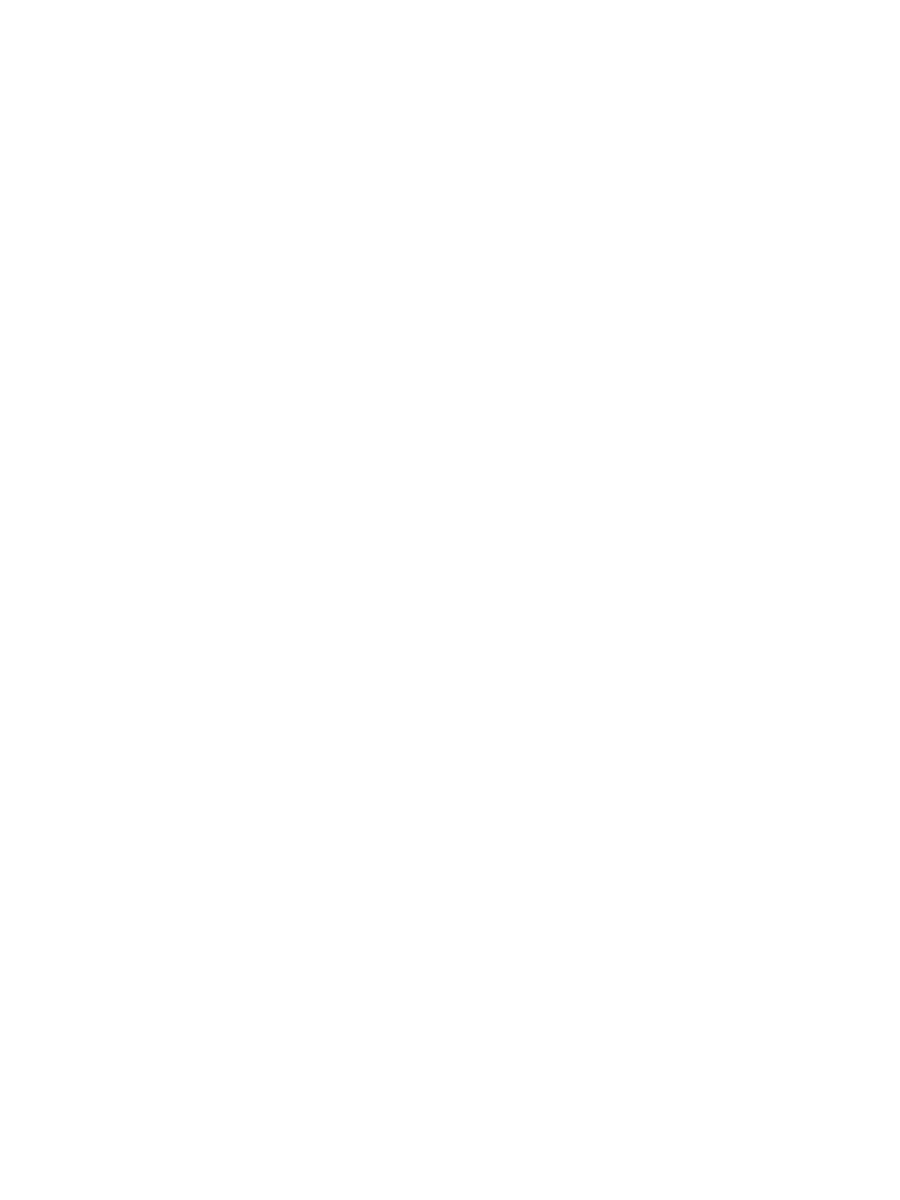

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\User

In [58]:
#Plots median mag vs rms with ALL 4 fields for a specified band
all_D = [D1, D2, D3, D4]
all_D_sigma = [D1_sigma, D2_sigma, D3_sigma, D4_sigma]
color_vals = ["red", "gold", "purple", "green"]
field_names = ["D1", "D2", "D3", "D4"]
plt.figure(figsize = (9, 12))
for i in range(4):
    plot_rms_mags_together(0, all_D[i], all_D_sigma[i], field_names[i], color_vals[i]) #change the first parameter to change the band
plt.legend(loc = "lower right")

In [59]:
#NEEDED TO RUN plot_intrinsic_rms
def return_mags_rms_medians_red (band, mags, mags_for_median):
    """
    Function that returns information for plot_rms_mags.
    Parameters
    ---
    band: int for filter (0 = u, 1 = g, ..., 4 = z)
    mags: D1, D2, D3, or D4
    mags_for_median: D1_sigma, D2_sigma, etc.
    
    Returns
    ---
    median mag, rms of mags, medians sorted by 0.2 mag bins, and rms sorted by 0.2 mag bins
    """
    all_true_mags = []
    median_mags = []
    medians = []
    all_rms = []
    all_rms_two = []
    medians_for_pink = []
    #simplified
    for i in range(len(mags)):
        true_mags = [mags[i][band][j] for j in range(len(mags[i][band]))]
        all_true_mags.append(true_mags)
        temp_mags_for_median = [mags_for_median[i][band][j] for j in range(len(mags_for_median[i][band]))]
        median_mags.append(temp_mags_for_median)
    ####
    for i in range(len(all_true_mags)): #going through 5-sigma clipped mags (i is each object)
        squared_differences = []
        median = np.median(all_true_mags[i]) #median for 1 object's magnitudes in a specific filter (see: band parameter)
        medians.append(median) #medians = x-vals for blue dots
        differences = [all_true_mags[i][j] - median for j in range(len(all_true_mags[i]))]
        squared_differences.extend([i * i for i in differences])
        rms = np.mean(squared_differences) ** 0.5
        all_rms.append(rms)
        #second part
        squared_differences_two = []
        median_two = np.median(median_mags[i])
        medians_for_pink.append(median_two)
        differences_two = [median_mags[i][j] - median_two for j in range(len(median_mags[i]))]
        squared_differences_two.extend([i * i for i in differences_two])
        rms = np.mean(squared_differences_two) ** 0.5
        all_rms_two.append(rms)
    #print(all_rms_two)
    red_rms = []
    in_bin_medians = []
    bounds = np.arange(min(medians_for_pink), max(medians_for_pink), 0.2)
    for i in range(len(bounds) - 1):
        in_bin = []
        temp_rms = []
        for j in range(len(medians_for_pink)):
            if(bounds[i] < medians_for_pink[j] and bounds[i+1] > medians_for_pink[j]):
                in_bin.append(medians_for_pink[j])
                temp_rms.append(all_rms_two[j])
        in_bin_medians.append(np.median(in_bin))
        red_rms.append(np.median(temp_rms))
    nan_bool_x = np.isnan(in_bin_medians)
    nan_bool_y = np.isnan(red_rms)
    in_bin_medians = np.delete(in_bin_medians, nan_bool_x)
    red_rms = np.delete(red_rms, nan_bool_y)
    return medians, all_rms, in_bin_medians, red_rms







In [60]:
def plot_intrinsic_rms(band, magss, mags_sigma):
    """
    Function to plot intrinsic rms for a given field and given filter
    
    Parameters:
    band: 0, 1, 2, 3, 4 (for u, g, r, i, z)
    magss: D1, D2, D3, or D4
    mags_sigma: D1_sigma, D2_sigma, etc.
    
    Returns:
    intrinsic_rms_squared
    median_rms_squared
    plot of intrinsic rms squared vs median mag
    """
    intrinsic_rms_squared = []
    median_rms_squared = []
    mags, rms, in_bin_medians, red_rms = return_mags_rms_medians_red(band, magss, mags_sigma)
    plt.figure(figsize = (9, 12))
    plt.ylabel('Intrinsic RMS Squared')
    if band == 0:
        plt.xlabel(r'$<%s>$' % 'u')
        if magss == D1:
            X = (in_bin_medians[6:len(in_bin_medians)-3])
            y = np.log10(red_rms[6:len(red_rms) - 3])
        elif magss == D2:
            X = (in_bin_medians[6:len(in_bin_medians)-5])
            y = np.log10(red_rms[6:len(red_rms) - 5])
        elif magss == D3:
            X = (in_bin_medians[10:len(in_bin_medians)-6])
            y = np.log10(red_rms[10:len(red_rms) - 6])
        elif magss == D4:
            X = (in_bin_medians[8:len(in_bin_medians)-6])
            y = np.log10(red_rms[8:len(red_rms) - 6])
    elif band == 1:
        plt.xlabel(r'$<%s>$' % 'g')
        if magss == D1:
            X = (in_bin_medians[4:len(in_bin_medians)-2])
            y = np.log10(red_rms[4:len(red_rms) - 2])
        elif magss == D2:
            X = (in_bin_medians[8:len(in_bin_medians)-2])
            y = np.log10(red_rms[8:len(red_rms) - 2])
        elif magss == D3:
            X = (in_bin_medians[9:len(in_bin_medians)-1])
            y = np.log10(red_rms[9:len(red_rms)-1])
        elif magss == D4:
            X = (in_bin_medians[0:len(in_bin_medians)-8])
            y = np.log10(red_rms[0:len(red_rms)-8])
    elif band == 2:
        plt.xlabel(r'$<%s>$' % 'r')
        if magss == D1:
            X = (in_bin_medians[9:len(in_bin_medians)-4])
            y = np.log10(red_rms[9:len(red_rms)-4])
        elif magss == D2:
            X = (in_bin_medians[9:len(in_bin_medians)-2])
            y = np.log10(red_rms[9:len(red_rms)-2])
        elif magss == D3:
            X = (in_bin_medians[12:len(in_bin_medians)-2])
            y = np.log10(red_rms[12:len(red_rms)-2])
        elif magss == D4:
            X = (in_bin_medians[17:len(in_bin_medians)-5])
            y = np.log10(red_rms[17:len(red_rms)-5])
    elif band == 3:
        plt.xlabel(r'$<%s>$' % 'i')
        if magss == D1:
            X = (in_bin_medians[12:len(in_bin_medians)-3])
            y = np.log10(red_rms[12:len(red_rms)-3])
        elif magss == D2:
            X = (in_bin_medians[21:len(in_bin_medians)])
            y = np.log10(red_rms[21:len(red_rms)])
        elif magss == D3:
            X = (in_bin_medians[25:len(in_bin_medians)-1])
            y = np.log10(red_rms[25:len(red_rms)-1])
            plt.ylim(-100, 20)
        elif magss == D4:
            X = (in_bin_medians[16:len(in_bin_medians)-5])
            y = np.log10(red_rms[16:len(red_rms)-5])
    elif band == 4:
        plt.xlabel(r'$<%s>$' % 'z')
        if magss == D1:
            X = (in_bin_medians[10:len(in_bin_medians)-6])
            y = np.log10(red_rms[10:len(red_rms)-6])
        elif magss == D2:
            X = (in_bin_medians[15:len(in_bin_medians)-4])
            y = np.log10(red_rms[15:len(red_rms)-4])
        elif magss == D3:
            X = (in_bin_medians[14:len(in_bin_medians)-4])
            y = np.log10(red_rms[14:len(red_rms)-4])
        elif magss == D4:
            X = (in_bin_medians[14:len(in_bin_medians)-4])
            y = np.log10(red_rms[14:len(red_rms)-4])
    degree=4
    X_1 = X.reshape(-1, 1)
    y_1 = y.reshape(-1, 1)
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(X_1,y_1)
    #plt.plot(X,polyreg.predict(X),color="black")
    #plt.title("Polynomial regression with degree "+str(degree))
    #print("RMSE: " + str(sklearn.metrics.mean_squared_error(y,polyreg.predict(X))))
    for i in range(len(mags)):
        mags_arr = mags[i]
        mags_arr = mags_arr.reshape(1, -1)
        intrinsic_rms_squared.append(rms[i]*rms[i]- 10 ** polyreg.predict(mags_arr).item(0) * 10 ** polyreg.predict(mags_arr).item(0))
        median_rms_squared.append(10 ** polyreg.predict(mags_arr).item(0) * 10 ** polyreg.predict(mags_arr).item(0))
    plt.scatter(mags, intrinsic_rms_squared, s = 0.05)
    plt.show()
    return intrinsic_rms_squared, median_rms_squared

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


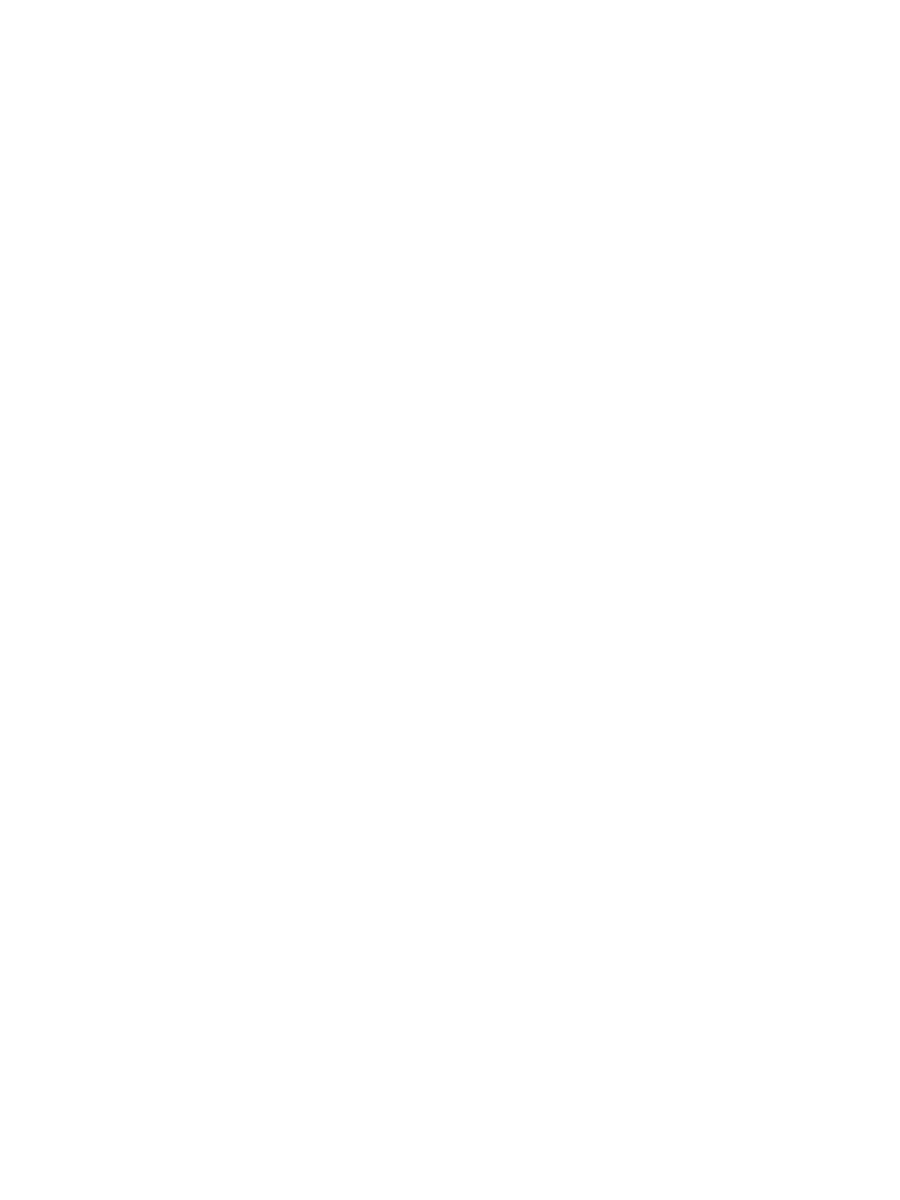

In [61]:
D1_u_intrinsic_rms_squared, D1_u_median_rms_squared = plot_intrinsic_rms(0, D1, D1_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


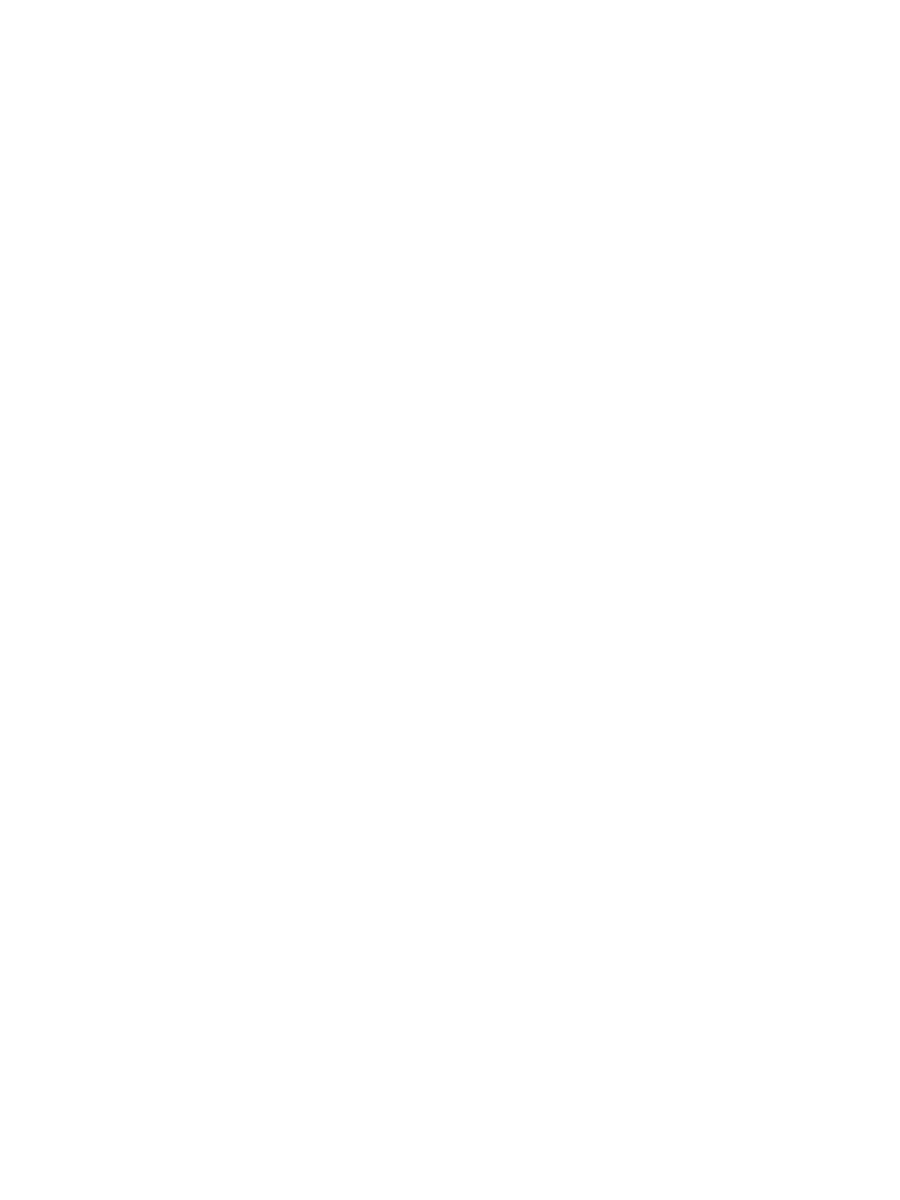

In [62]:
D1_g_intrinsic_rms_squared, D1_g_median_rms_squared = plot_intrinsic_rms(1, D1, D1_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


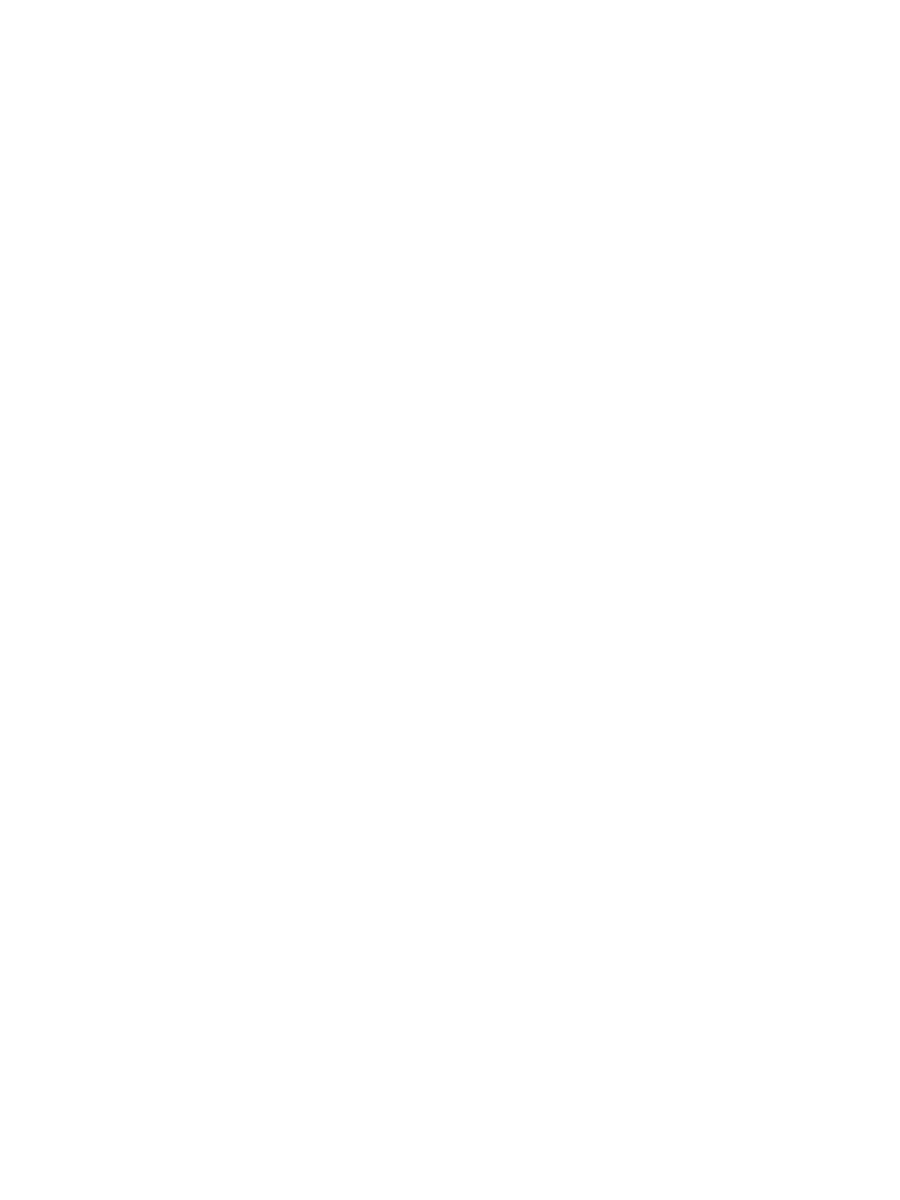

In [63]:
D1_r_intrinsic_rms_squared, D1_r_median_rms_squared = plot_intrinsic_rms(2, D1, D1_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


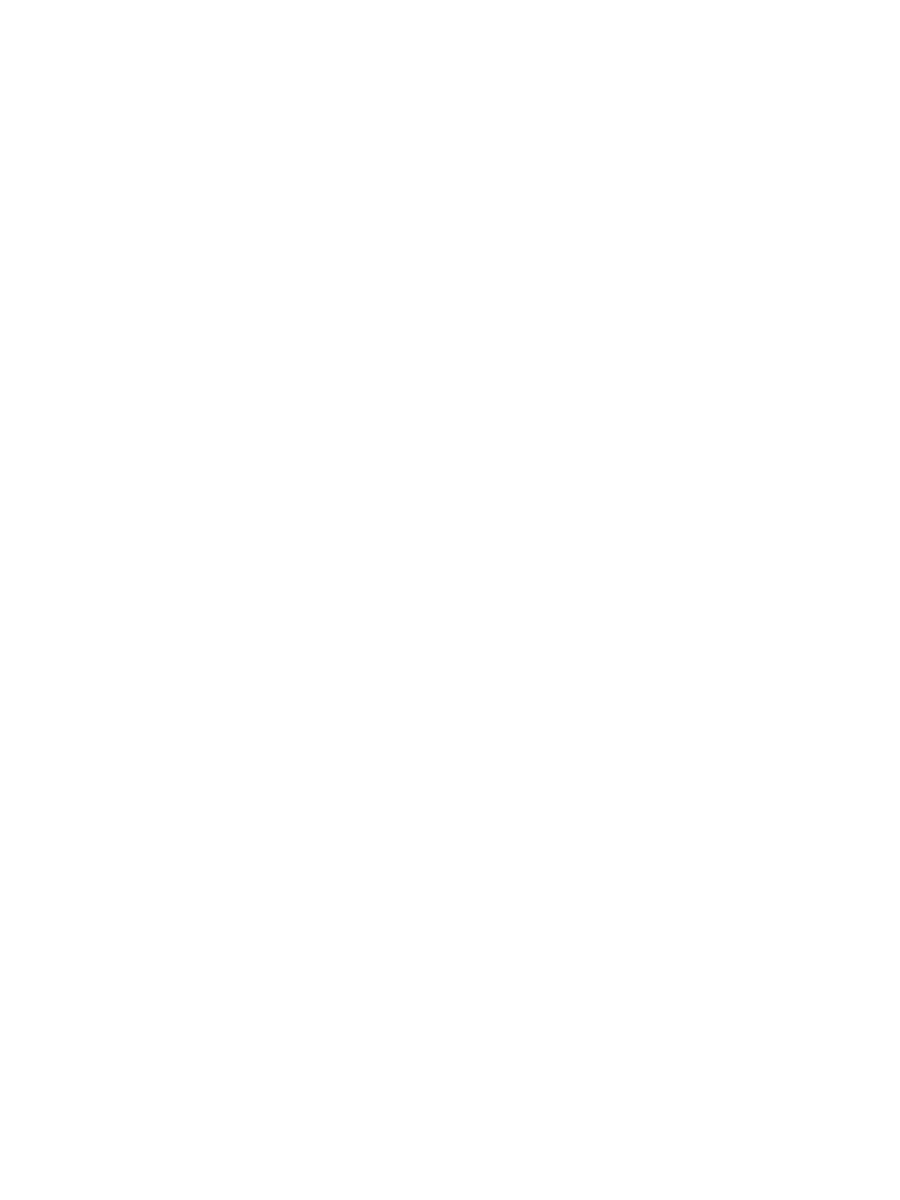

In [64]:
D1_i_intrinsic_rms_squared, D1_i_median_rms_squared = plot_intrinsic_rms(3, D1, D1_sigma)

<IPython.core.display.Javascript object>


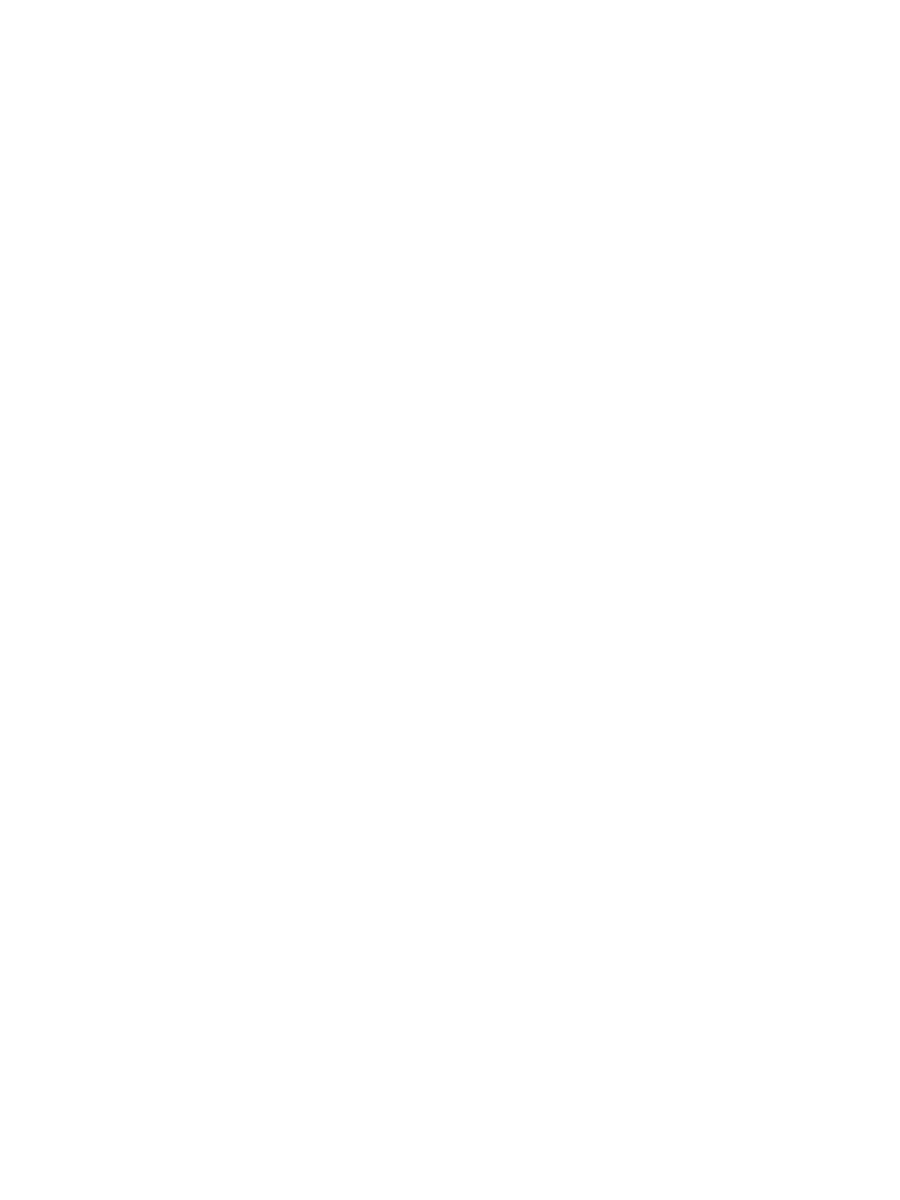

In [65]:
D1_z_intrinsic_rms_squared, D1_z_median_rms_squared = plot_intrinsic_rms(4, D1, D1_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


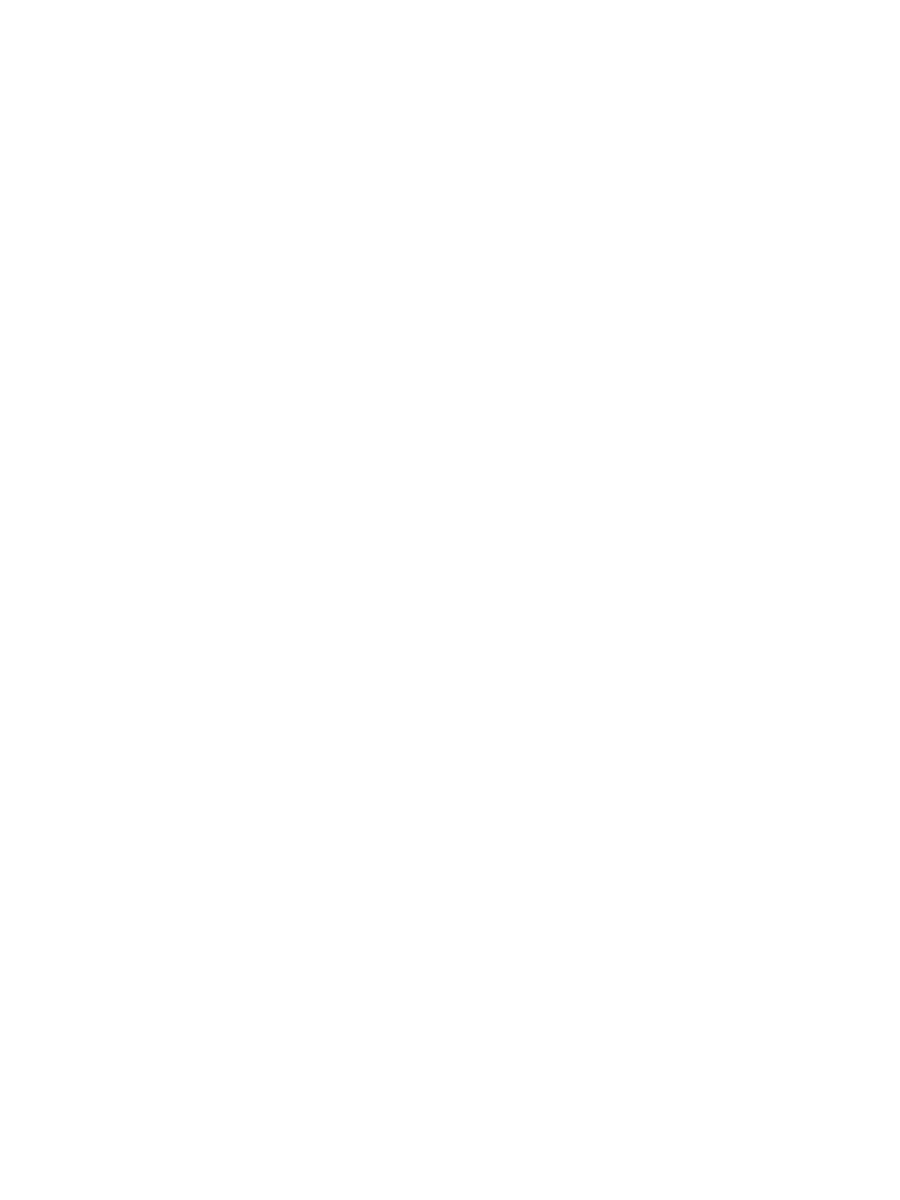

In [66]:
D2_u_intrinsic_rms_squared, D2_u_median_rms_squared = plot_intrinsic_rms(0, D2, D2_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


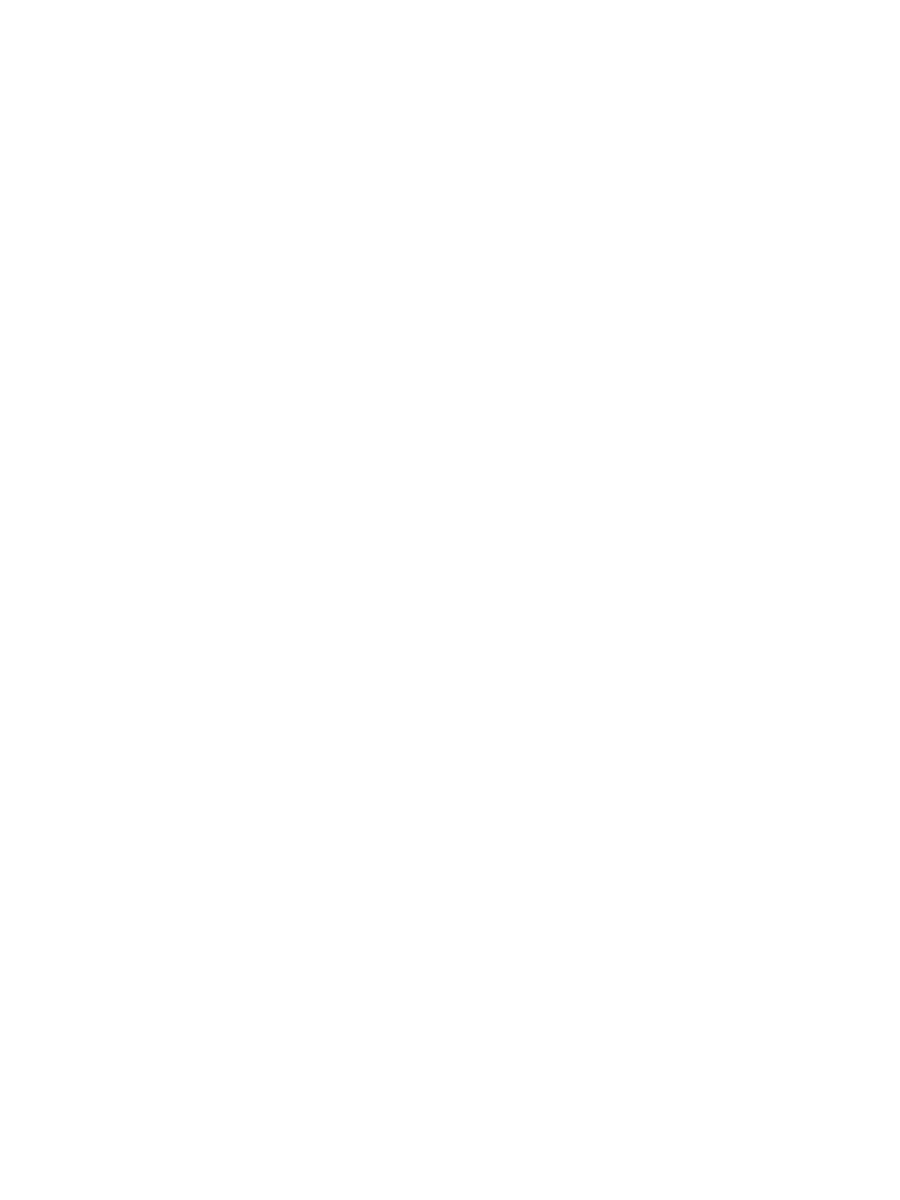

In [67]:
D2_g_intrinsic_rms_squared, D2_g_median_rms_squared = plot_intrinsic_rms(1, D2, D2_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


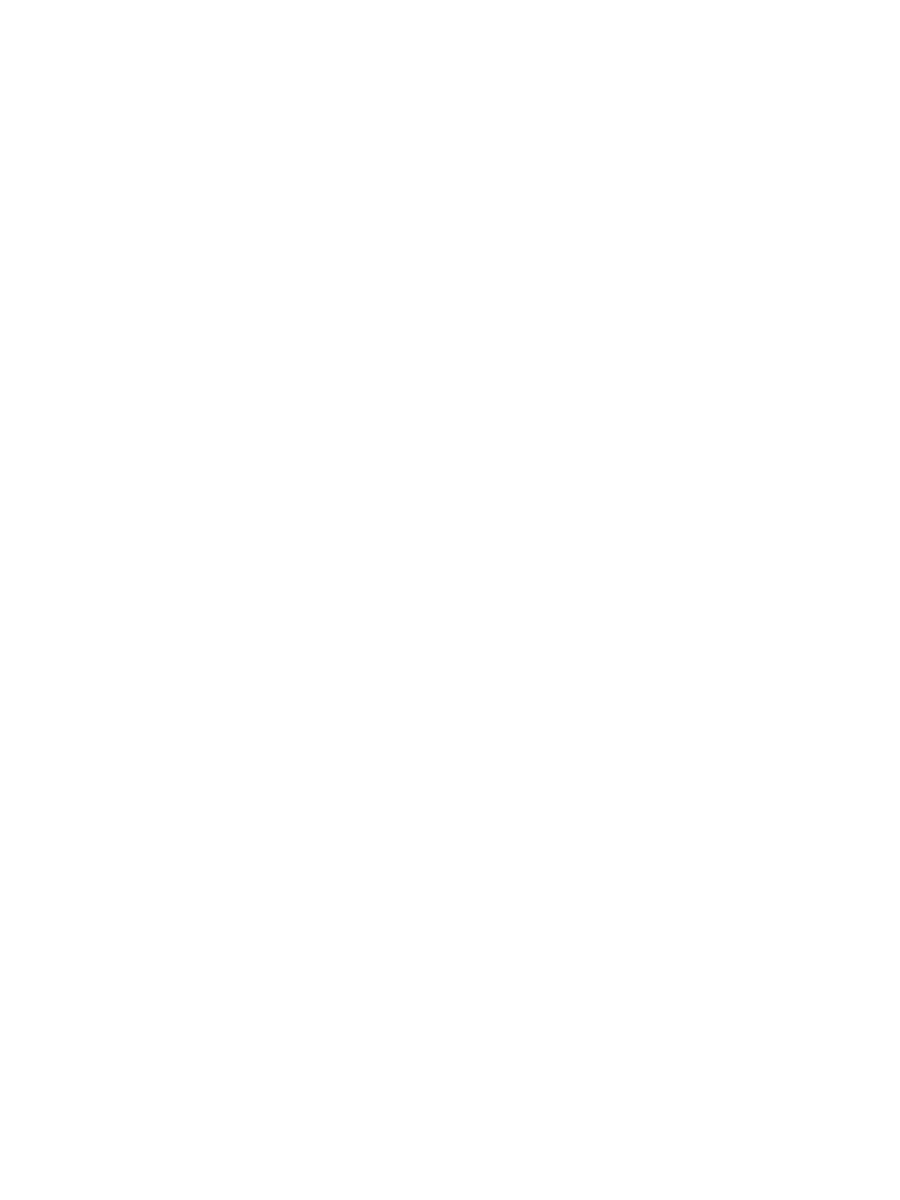

In [68]:
D2_r_intrinsic_rms_squared, D2_r_median_rms_squared = plot_intrinsic_rms(2, D2, D2_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


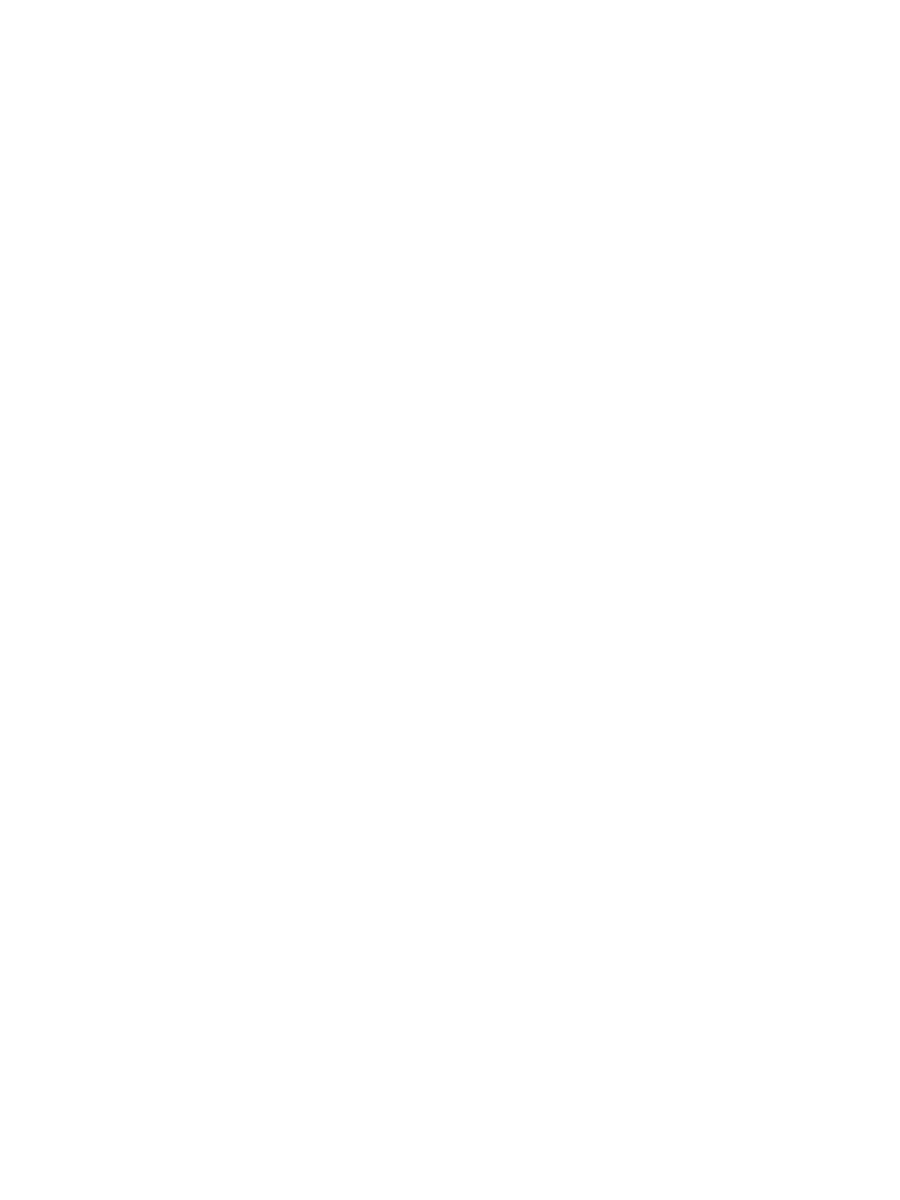

In [69]:
D2_i_intrinsic_rms_squared, D2_i_median_rms_squared = plot_intrinsic_rms(3, D2, D2_sigma)

<IPython.core.display.Javascript object>


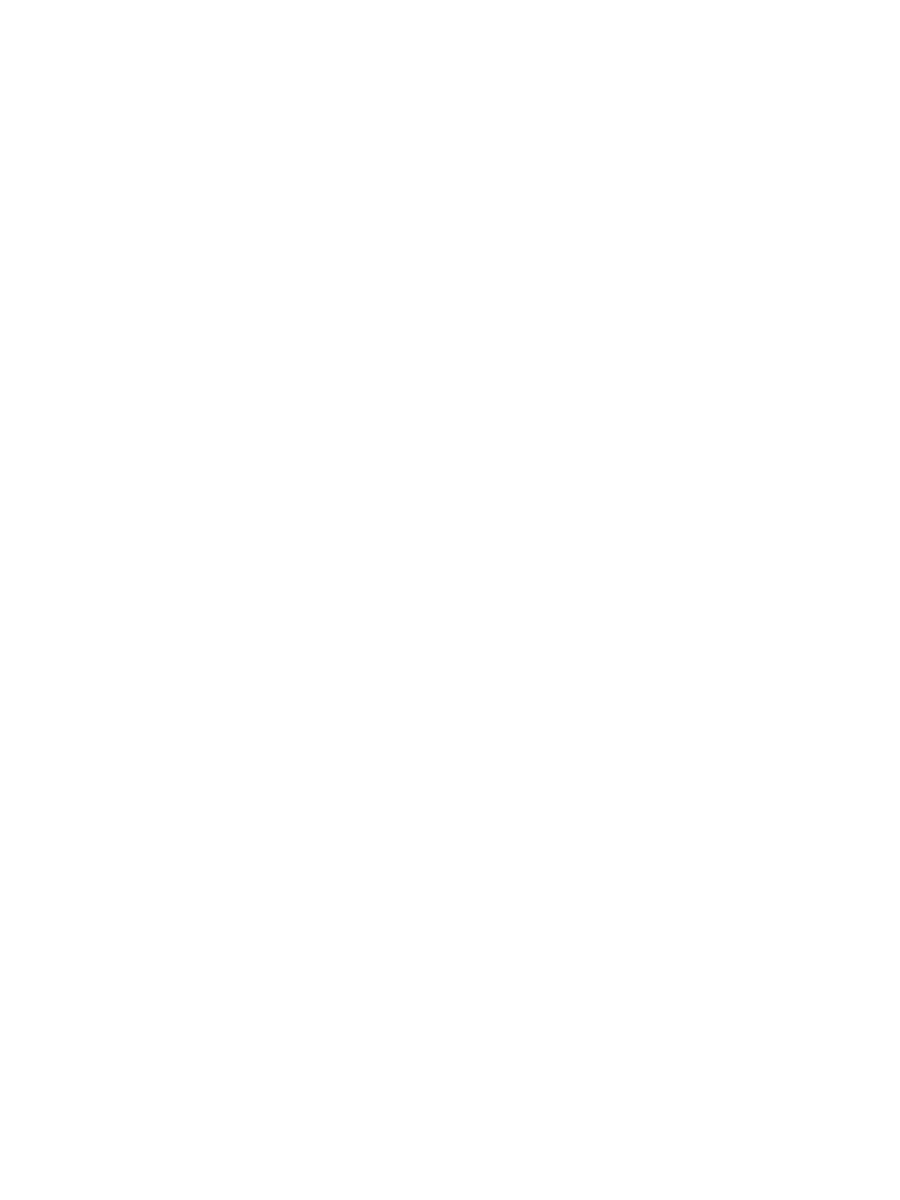

In [70]:
D2_z_intrinsic_rms_squared, D2_z_median_rms_squared = plot_intrinsic_rms(4, D2, D2_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


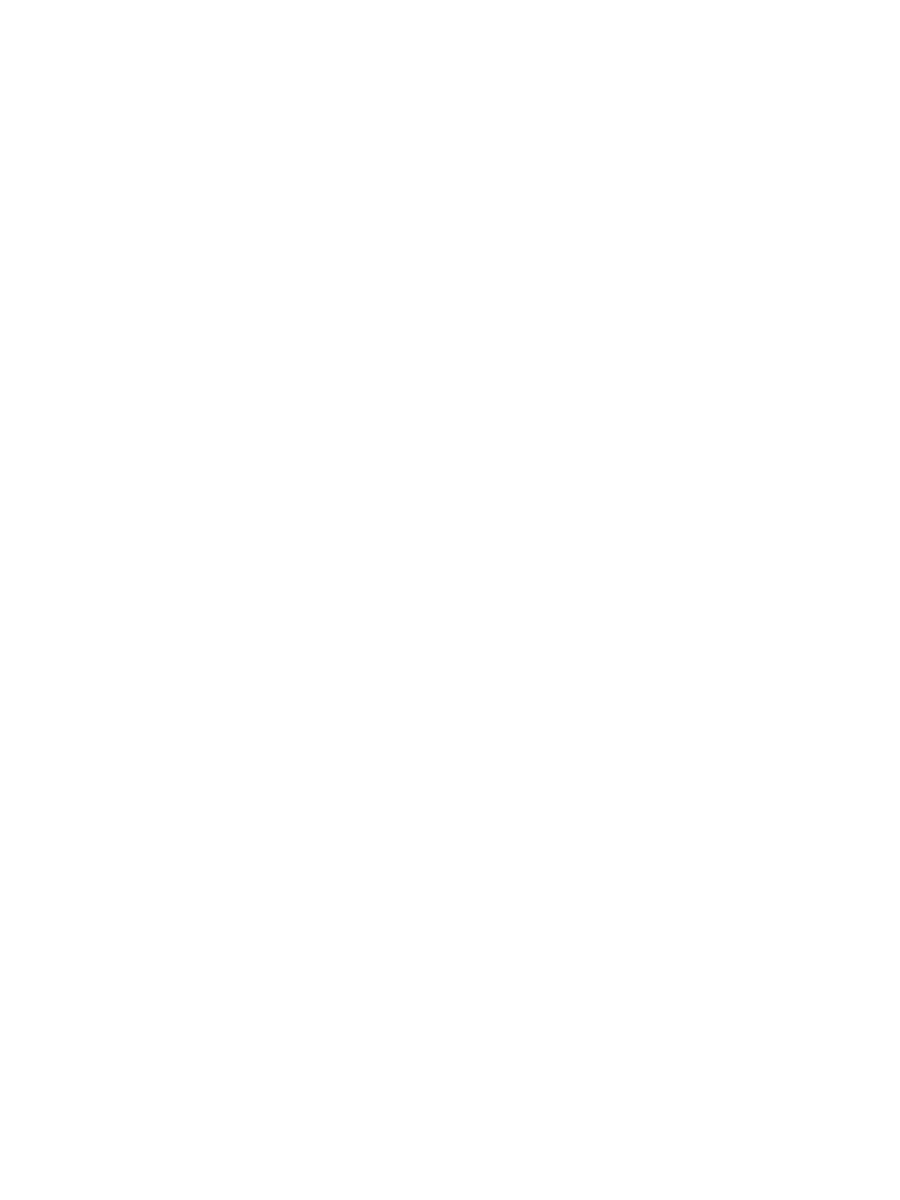

In [71]:
D3_u_intrinsic_rms_squared, D3_u_median_rms_squared = plot_intrinsic_rms(0, D3, D3_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


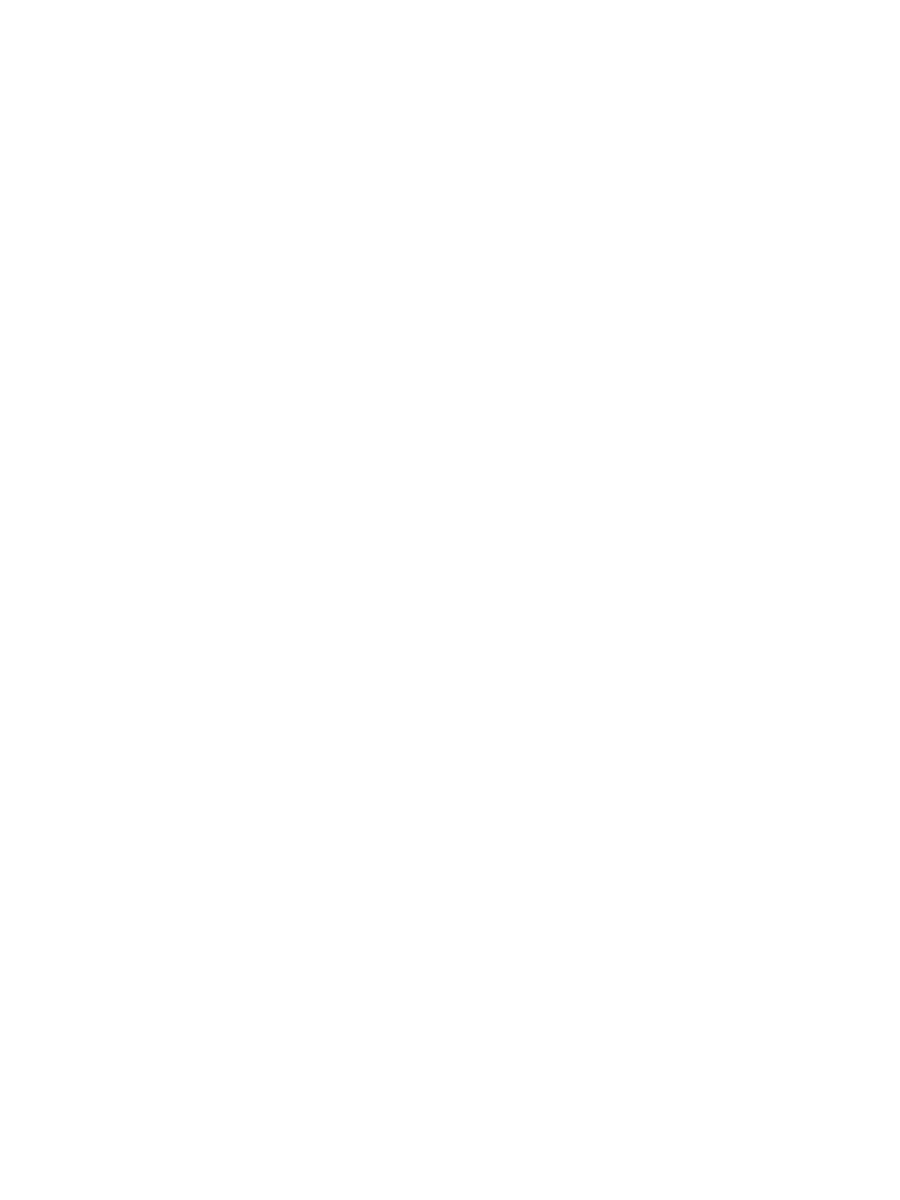

In [72]:
D3_g_intrinsic_rms_squared, D3_g_median_rms_squared = plot_intrinsic_rms(1, D3, D3_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


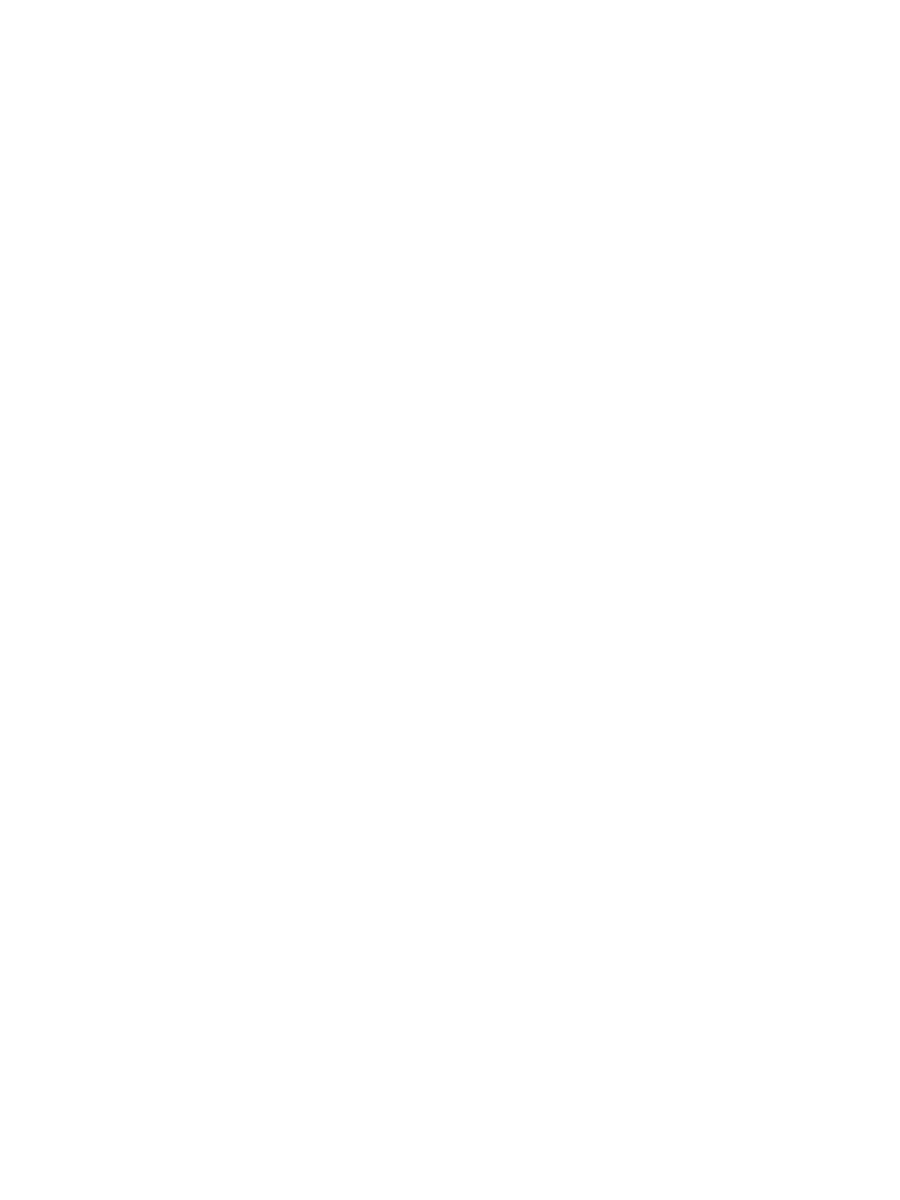

In [73]:
D3_r_intrinsic_rms_squared, D3_r_median_rms_squared = plot_intrinsic_rms(2, D3, D3_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


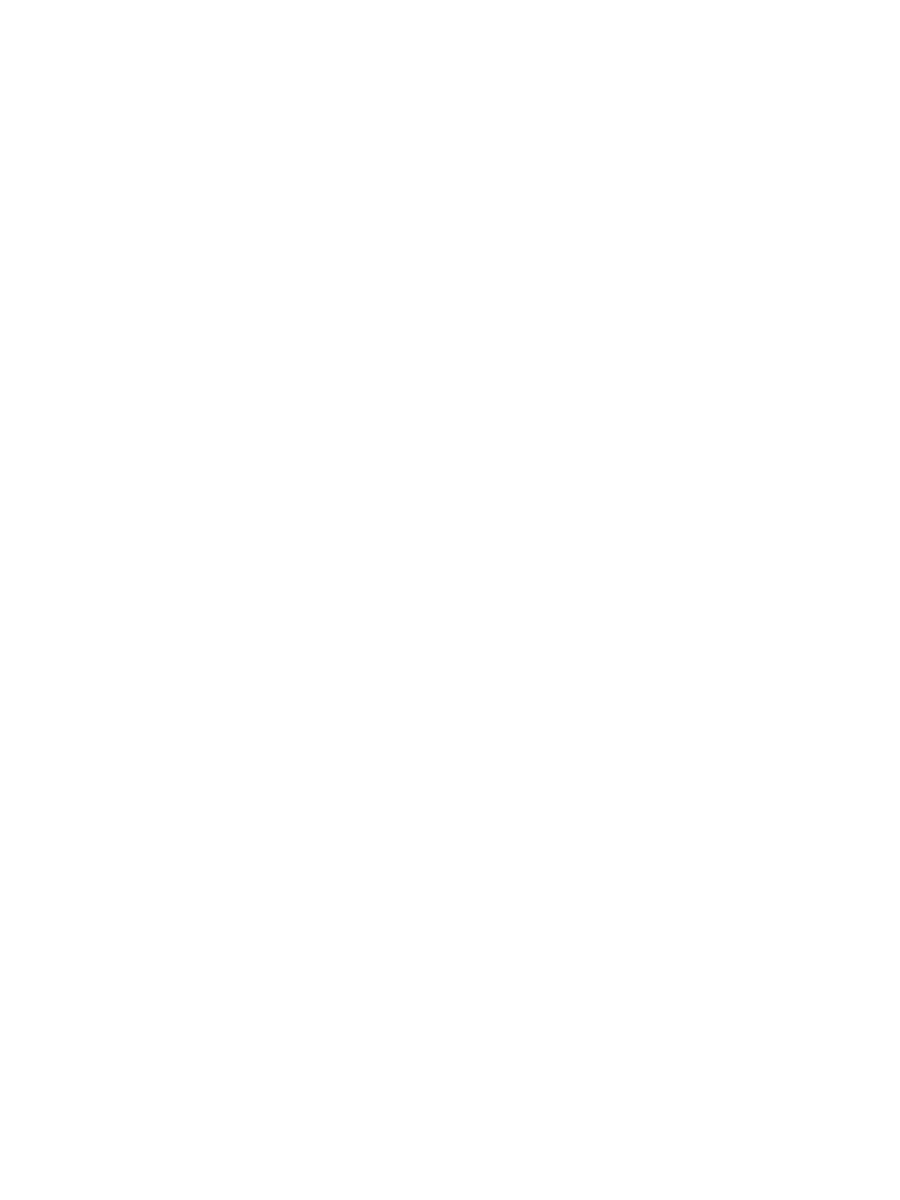

In [74]:
D3_i_intrinsic_rms_squared, D3_i_median_rms_squared = plot_intrinsic_rms(3, D3, D3_sigma)

<IPython.core.display.Javascript object>


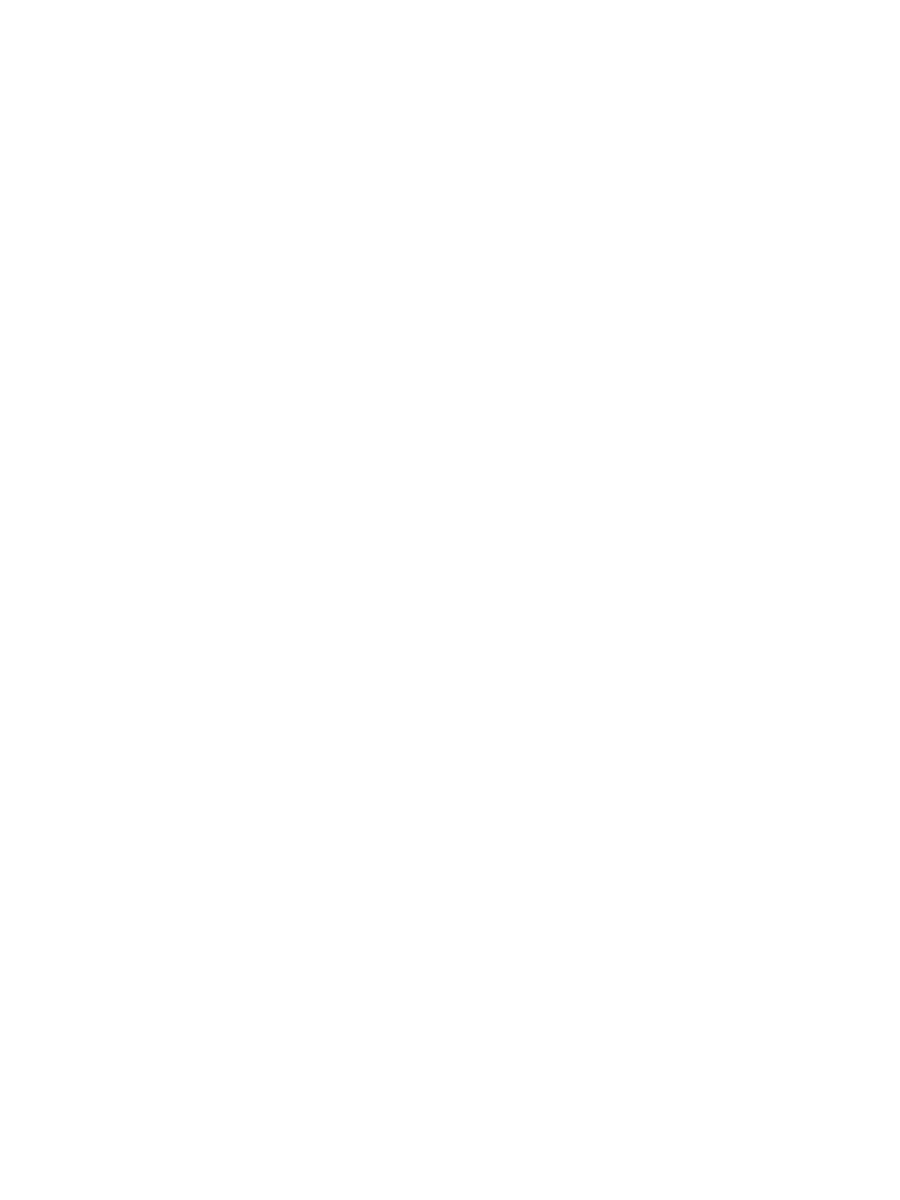

In [75]:
D3_z_intrinsic_rms_squared, D3_z_median_rms_squared = plot_intrinsic_rms(4, D3, D3_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


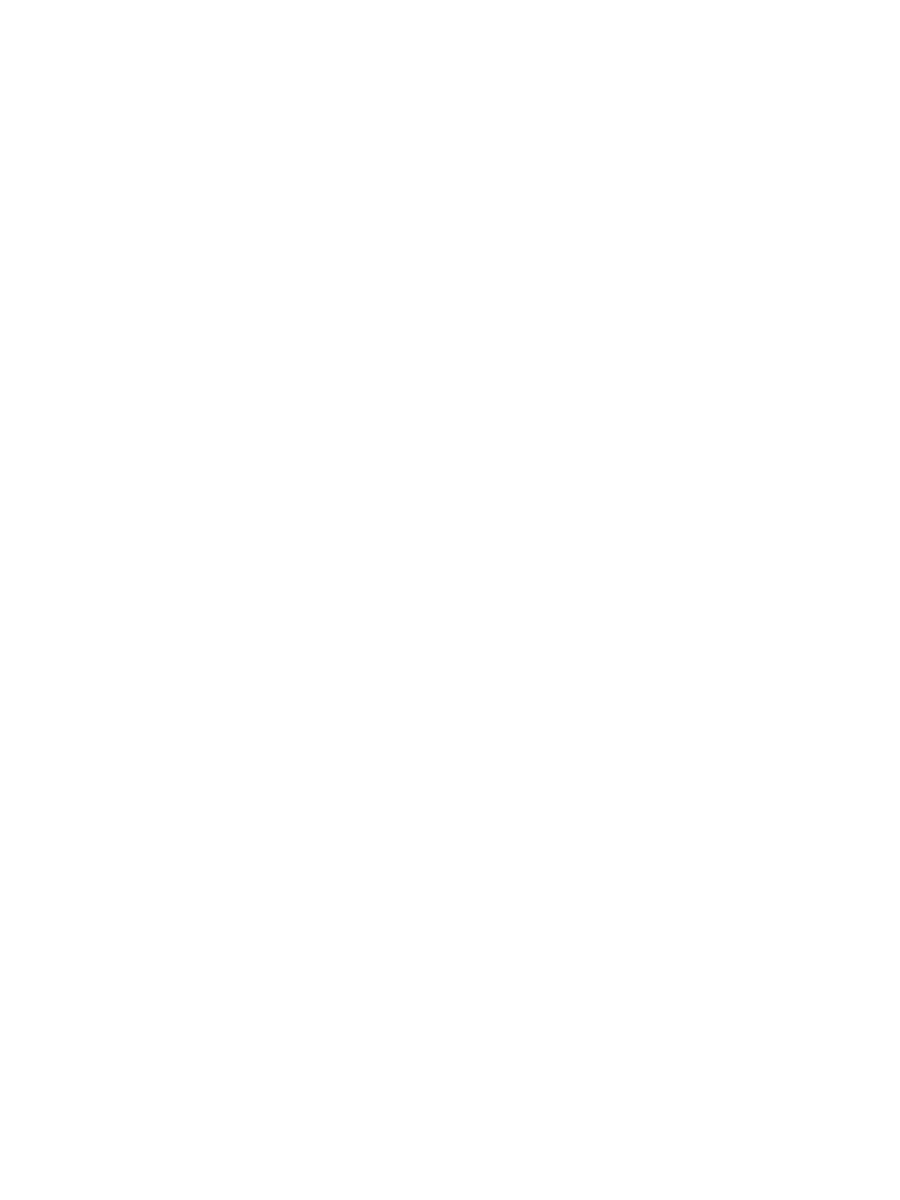

In [76]:
D4_u_intrinsic_rms_squared, D4_u_median_rms_squared = plot_intrinsic_rms(0, D4, D4_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


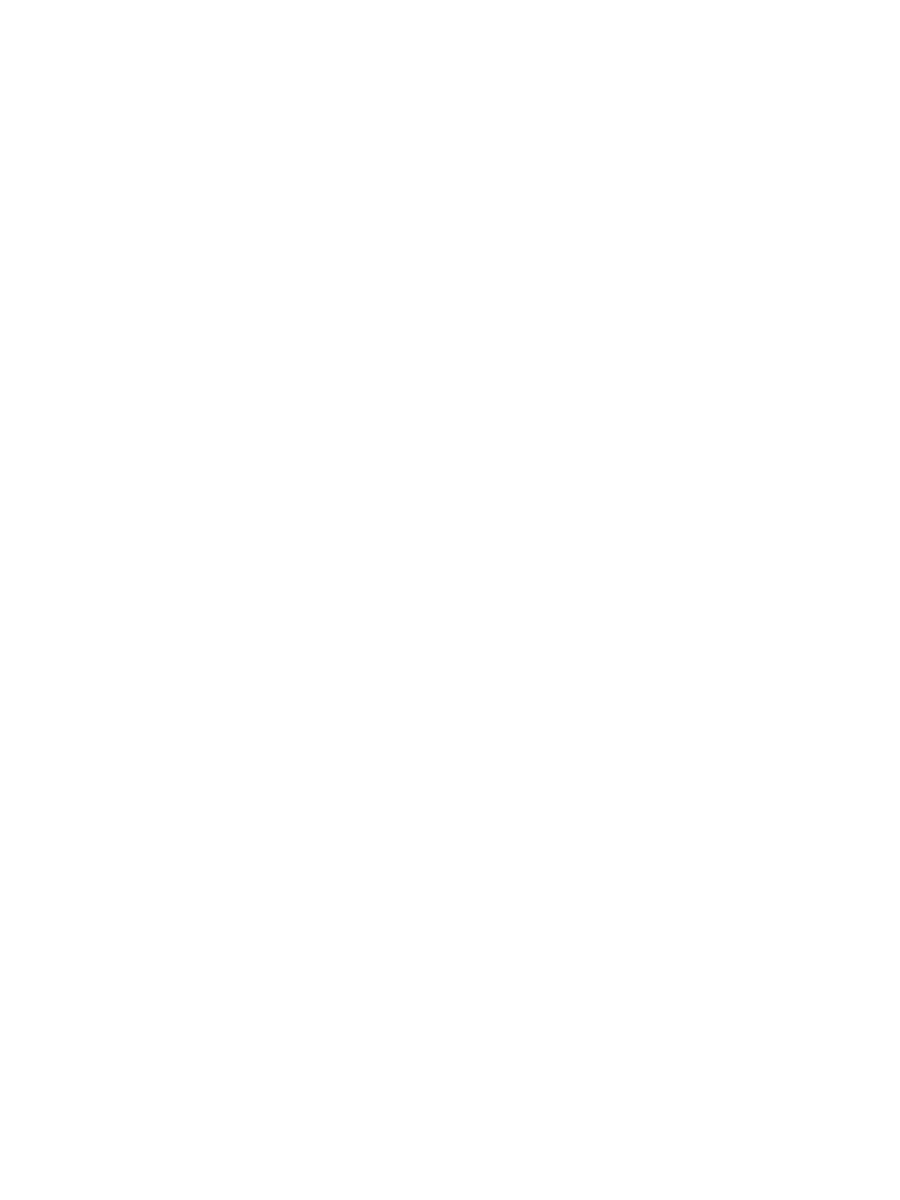

In [77]:
D4_g_intrinsic_rms_squared, D4_g_median_rms_squared = plot_intrinsic_rms(1, D4, D4_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


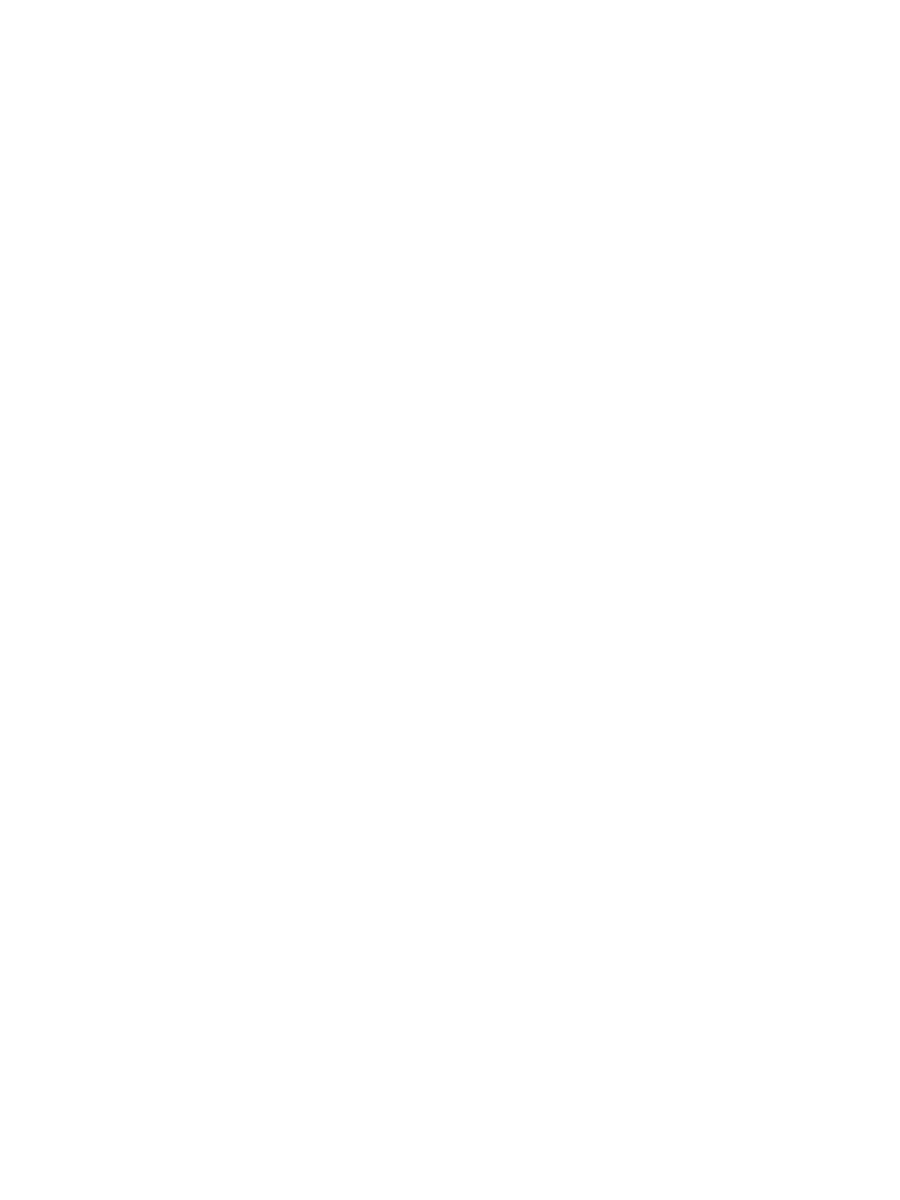

In [78]:
D4_r_intrinsic_rms_squared, D4_r_median_rms_squared = plot_intrinsic_rms(2, D4, D4_sigma)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


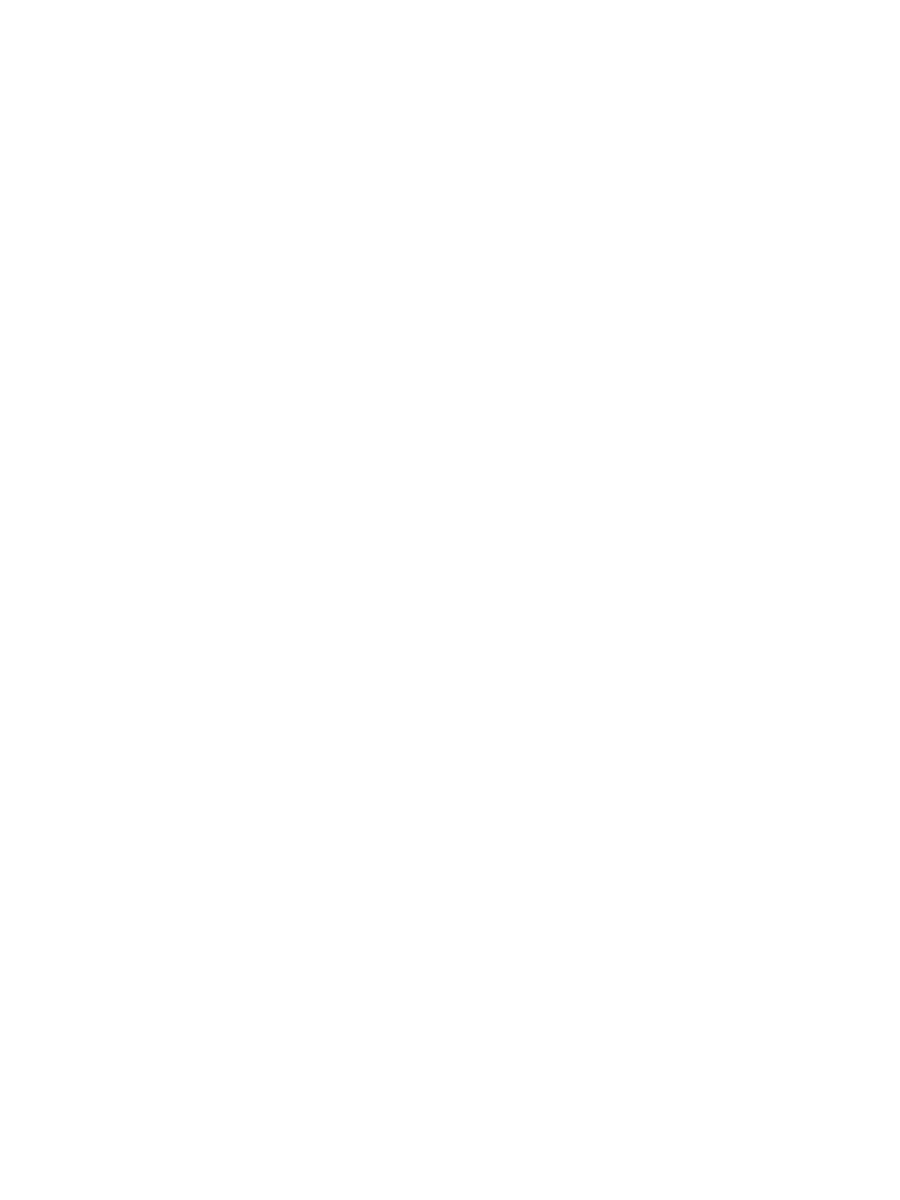

In [79]:
D4_i_intrinsic_rms_squared, D4_i_median_rms_squared = plot_intrinsic_rms(3, D4, D4_sigma)

<IPython.core.display.Javascript object>


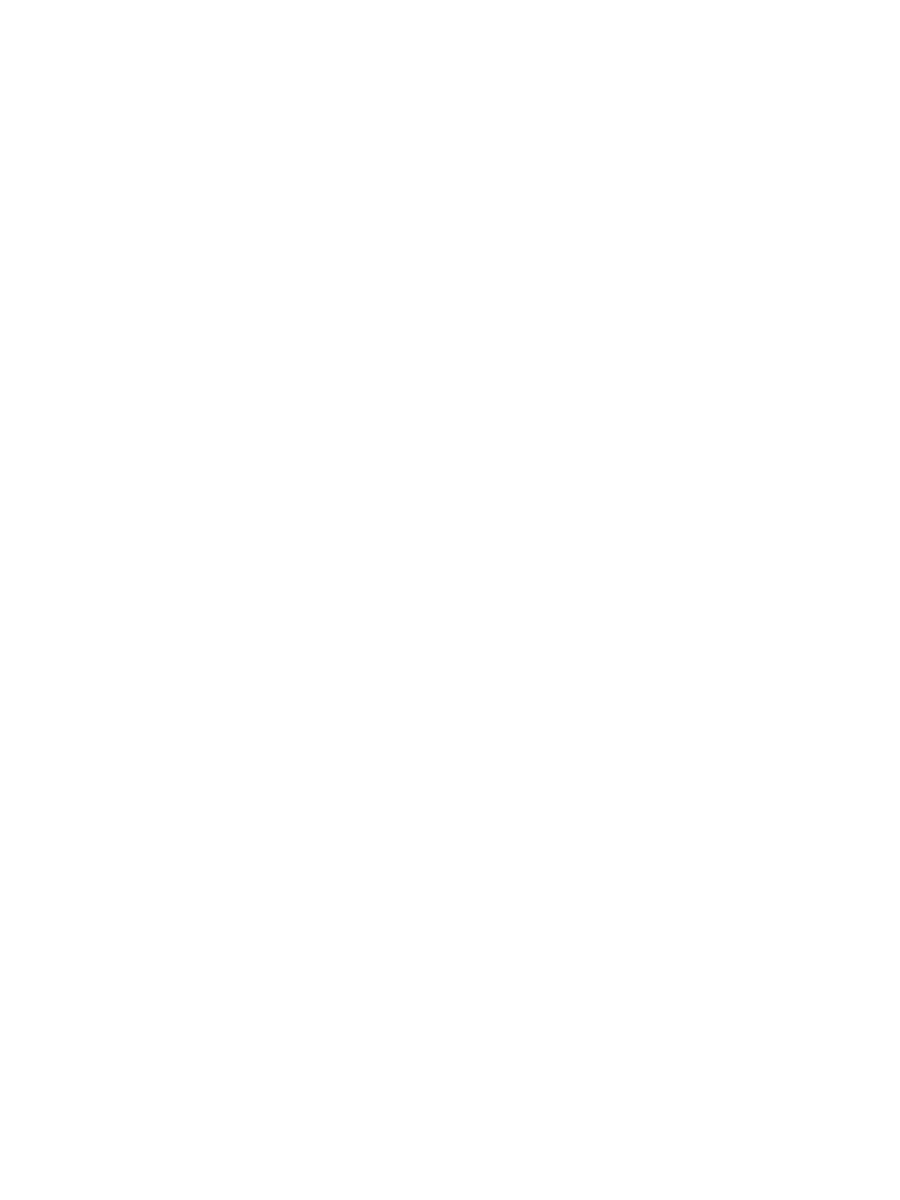

In [80]:
D4_z_intrinsic_rms_squared, D4_z_median_rms_squared = plot_intrinsic_rms(4, D4, D4_sigma)

In [81]:
#create boolean to make sure median is above the cutoff due to the tail on the left hand side of rms vs median mag
D1_z_medians_boolean = [np.median(D1[i][4]) > 16.5 for i in range(len(D1))]
D2_z_medians_boolean = [np.median(D2[i][4]) > 16.5 for i in range(len(D2))]
D3_z_medians_boolean = [np.median(D3[i][4]) > 16.5 for i in range(len(D3))]
D4_z_medians_boolean = [np.median(D4[i][4]) > 16.5 for i in range(len(D4))]

D1_i_medians_boolean = [np.median(D1[i][3]) > 18 for i in range(len(D1))]
D2_i_medians_boolean = [np.median(D2[i][3]) > 18 for i in range(len(D2))]
D3_i_medians_boolean = [np.median(D3[i][3]) > 18 for i in range(len(D3))]
D4_i_medians_boolean = [np.median(D4[i][3]) > 18 for i in range(len(D4))]

D1_r_medians_boolean = [np.median(D1[i][2]) > 17.5 for i in range(len(D1))]
D2_r_medians_boolean = [np.median(D2[i][2]) > 17.5 for i in range(len(D2))]
D3_r_medians_boolean = [np.median(D3[i][2]) > 17.5 for i in range(len(D3))]
D4_r_medians_boolean = [np.median(D4[i][2]) > 17.5 for i in range(len(D4))]

In [82]:
#reciprocals for weights for weighted summed intrinsic rms squared 
D1_u_reciprocal = np.reciprocal(D1_u_median_rms_squared)
D1_g_reciprocal = np.reciprocal(D1_g_median_rms_squared)
D1_r_reciprocal = np.reciprocal(D1_r_median_rms_squared)
D1_i_reciprocal = np.reciprocal(D1_i_median_rms_squared)
D1_z_reciprocal = np.reciprocal(D1_z_median_rms_squared)
D2_u_reciprocal = np.reciprocal(D2_u_median_rms_squared)
D2_g_reciprocal = np.reciprocal(D2_g_median_rms_squared)
D2_r_reciprocal = np.reciprocal(D2_r_median_rms_squared)
D2_i_reciprocal = np.reciprocal(D2_i_median_rms_squared)
D2_z_reciprocal = np.reciprocal(D2_z_median_rms_squared)
D3_u_reciprocal = np.reciprocal(D3_u_median_rms_squared)
D3_g_reciprocal = np.reciprocal(D3_g_median_rms_squared)
D3_r_reciprocal = np.reciprocal(D3_r_median_rms_squared)
D3_i_reciprocal = np.reciprocal(D3_i_median_rms_squared)
D3_z_reciprocal = np.reciprocal(D3_z_median_rms_squared)
D4_u_reciprocal = np.reciprocal(D4_u_median_rms_squared)
D4_g_reciprocal = np.reciprocal(D4_g_median_rms_squared)
D4_r_reciprocal = np.reciprocal(D4_r_median_rms_squared)
D4_i_reciprocal = np.reciprocal(D4_i_median_rms_squared)
D4_z_reciprocal = np.reciprocal(D4_z_median_rms_squared)

D1_sum_intrinsic_rms = []
D2_sum_intrinsic_rms = []
D3_sum_intrinsic_rms = []
D4_sum_intrinsic_rms = []

for i in range(len(D1_u_intrinsic_rms_squared)):
    numerator = D1_u_reciprocal[i] * D1_u_intrinsic_rms_squared[i] + D1_g_reciprocal[i] * D1_g_intrinsic_rms_squared[i] + D1_r_reciprocal[i] * D1_r_intrinsic_rms_squared[i] + D1_i_reciprocal[i] * D1_i_intrinsic_rms_squared[i] + D1_z_reciprocal[i] * D1_z_intrinsic_rms_squared[i]
    denominator = D1_u_reciprocal[i] + D1_g_reciprocal[i] + D1_r_reciprocal[i] + D1_i_reciprocal[i] + D1_z_reciprocal[i]
    D1_sum_intrinsic_rms.append(numerator/denominator)

for i in range(len(D2_u_intrinsic_rms_squared)):
    numerator = D2_u_reciprocal[i] * D2_u_intrinsic_rms_squared[i] + D2_g_reciprocal[i] * D2_g_intrinsic_rms_squared[i] + D2_r_reciprocal[i] * D2_r_intrinsic_rms_squared[i] + D2_i_reciprocal[i] * D2_i_intrinsic_rms_squared[i] + D2_z_reciprocal[i] * D2_z_intrinsic_rms_squared[i]
    denominator = D2_u_reciprocal[i] + D2_g_reciprocal[i] + D2_r_reciprocal[i] + D2_i_reciprocal[i] + D2_z_reciprocal[i]
    D2_sum_intrinsic_rms.append(numerator/denominator)

for i in range(len(D3_u_intrinsic_rms_squared)):
    numerator = D3_u_reciprocal[i] * D3_u_intrinsic_rms_squared[i] + D3_g_reciprocal[i] * D3_g_intrinsic_rms_squared[i] + D3_r_reciprocal[i] * D3_r_intrinsic_rms_squared[i] + D3_i_reciprocal[i] * D3_i_intrinsic_rms_squared[i] + D3_z_reciprocal[i] * D3_z_intrinsic_rms_squared[i]
    denominator = D3_u_reciprocal[i] + D3_g_reciprocal[i] + D3_r_reciprocal[i] + D3_i_reciprocal[i] + D3_z_reciprocal[i]
    D3_sum_intrinsic_rms.append(numerator/denominator)

for i in range(len(D4_u_intrinsic_rms_squared)):
    numerator = D4_u_reciprocal[i] * D4_u_intrinsic_rms_squared[i] + D4_g_reciprocal[i] * D4_g_intrinsic_rms_squared[i] + D4_r_reciprocal[i] * D4_r_intrinsic_rms_squared[i] + D4_i_reciprocal[i] * D4_i_intrinsic_rms_squared[i] + D4_z_reciprocal[i] * D4_z_intrinsic_rms_squared[i]
    denominator = D4_u_reciprocal[i] + D4_g_reciprocal[i] + D4_r_reciprocal[i] + D4_i_reciprocal[i] + D4_z_reciprocal[i]
    D4_sum_intrinsic_rms.append(numerator/denominator)

In [83]:
#to find index of object in file_list
D1_indicies = []
D2_indicies = []
D3_indicies = []
D4_indicies = []
for i in range(len(D1)):
    D1_indicies.append(i)
for i in range(len(D2)):
    D2_indicies.append(i + len(D1))
for i in range(len(D3)):
    D3_indicies.append(i + len(D1) + len(D2))
for i in range(len(D4)):
    D4_indicies.append(i + len(D1) + len(D2) + len(D3))

In [84]:
#testing to see if the objects satisfy the median mag requirements/cutoff
D1_indicies_boolean = [D1_z_medians_boolean[i] == True and D1_r_medians_boolean[i] == True and D1_i_medians_boolean[i] == True for i in range(len(D1_z_medians_boolean))]
D2_indicies_boolean = [D2_z_medians_boolean[i] == True and D2_r_medians_boolean[i] == True and D2_i_medians_boolean[i] == True for i in range(len(D2_z_medians_boolean))]
D3_indicies_boolean = [D3_z_medians_boolean[i] == True and D3_r_medians_boolean[i] == True and D3_i_medians_boolean[i] == True for i in range(len(D3_z_medians_boolean))]
D4_indicies_boolean = [D4_z_medians_boolean[i] == True and D4_r_medians_boolean[i] == True and D4_i_medians_boolean[i] == True for i in range(len(D4_z_medians_boolean))]

In [85]:
#changes true to false and vice versa
D1_indicies_boolean = [not elem for elem in D1_indicies_boolean]
D2_indicies_boolean = [not elem for elem in D2_indicies_boolean]
D3_indicies_boolean = [not elem for elem in D3_indicies_boolean]
D4_indicies_boolean = [not elem for elem in D4_indicies_boolean]

In [86]:
len(D1_fnames) == len(D1_indicies_boolean)

True

In [87]:
#do not use objects that don't satisfy median mag cutoff
D1_indicies = np.delete(D1_indicies, D1_indicies_boolean)
D2_indicies = np.delete(D2_indicies, D2_indicies_boolean)
D3_indicies = np.delete(D3_indicies, D3_indicies_boolean)
D4_indicies = np.delete(D4_indicies, D4_indicies_boolean)

In [88]:
#delete file names of those objects that are not used
D1_fnames = np.delete(D1_fnames, D1_indicies_boolean)
D2_fnames = np.delete(D2_fnames, D2_indicies_boolean)
D3_fnames = np.delete(D3_fnames, D3_indicies_boolean)
D4_fnames = np.delete(D4_fnames, D4_indicies_boolean)

In [89]:
#delete RMS of objects that are not used
D1_u_rms = np.delete(D1_u_rms, D1_indicies_boolean)
D1_g_rms = np.delete(D1_g_rms, D1_indicies_boolean)
D1_r_rms = np.delete(D1_r_rms, D1_indicies_boolean)
D1_i_rms = np.delete(D1_i_rms, D1_indicies_boolean)
D1_z_rms = np.delete(D1_z_rms, D1_indicies_boolean)

D2_u_rms = np.delete(D2_u_rms, D2_indicies_boolean)
D2_g_rms = np.delete(D2_g_rms, D2_indicies_boolean)
D2_r_rms = np.delete(D2_r_rms, D2_indicies_boolean)
D2_i_rms = np.delete(D2_i_rms, D2_indicies_boolean)
D2_z_rms = np.delete(D2_z_rms, D2_indicies_boolean)

D3_u_rms = np.delete(D3_u_rms, D3_indicies_boolean)
D3_g_rms = np.delete(D3_g_rms, D3_indicies_boolean)
D3_r_rms = np.delete(D3_r_rms, D3_indicies_boolean)
D3_i_rms = np.delete(D3_i_rms, D3_indicies_boolean)
D3_z_rms = np.delete(D3_z_rms, D3_indicies_boolean)

D4_u_rms = np.delete(D4_u_rms, D4_indicies_boolean)
D4_g_rms = np.delete(D4_g_rms, D4_indicies_boolean)
D4_r_rms = np.delete(D4_r_rms, D4_indicies_boolean)
D4_i_rms = np.delete(D4_i_rms, D4_indicies_boolean)
D4_z_rms = np.delete(D4_z_rms, D4_indicies_boolean)

In [90]:
#delete sum intrinsic rms of those objects that are not used
D1_sum_intrinsic_rms = [D1_sum_intrinsic_rms[i] for i in range(len(D1_sum_intrinsic_rms)) if D1_z_medians_boolean[i] == True and D1_i_medians_boolean[i] == True and D1_r_medians_boolean[i] == True]
D2_sum_intrinsic_rms = [D2_sum_intrinsic_rms[i] for i in range(len(D2_sum_intrinsic_rms)) if D2_z_medians_boolean[i] == True and D2_i_medians_boolean[i] == True and D2_r_medians_boolean[i] == True]
D3_sum_intrinsic_rms = [D3_sum_intrinsic_rms[i] for i in range(len(D3_sum_intrinsic_rms)) if D3_z_medians_boolean[i] == True and D3_i_medians_boolean[i] == True and D3_r_medians_boolean[i] == True]
D4_sum_intrinsic_rms = [D4_sum_intrinsic_rms[i] for i in range(len(D4_sum_intrinsic_rms)) if D4_z_medians_boolean[i] == True and D4_i_medians_boolean[i] == True and D4_r_medians_boolean[i] == True]

In [91]:
#finding median g mags for each field
D1_g_median_mags = [np.median(D1_sigma[i][1]) for i in range(len(D1_sigma)) if D1_z_medians_boolean[i] == True and D1_i_medians_boolean[i] == True and D1_r_medians_boolean[i] == True]
D2_g_median_mags = [np.median(D2_sigma[i][1]) for i in range(len(D2_sigma)) if D2_z_medians_boolean[i] == True and D2_i_medians_boolean[i] == True and D2_r_medians_boolean[i] == True]
D3_g_median_mags = [np.median(D3_sigma[i][1]) for i in range(len(D3_sigma)) if D3_z_medians_boolean[i] == True and D3_i_medians_boolean[i] == True and D3_r_medians_boolean[i] == True]
D4_g_median_mags = [np.median(D4_sigma[i][1]) for i in range(len(D4_sigma)) if D4_z_medians_boolean[i] == True and D4_i_medians_boolean[i] == True and D4_r_medians_boolean[i] == True]

In [92]:
D1_g_bin_medians = []
D1_g_bin_rms = []
D2_g_bin_medians = []
D2_g_bin_rms = []
D3_g_bin_medians = []
D3_g_bin_rms = []
D4_g_bin_medians = []
D4_g_bin_rms = []

In [93]:
#creating mag bins
D1_temp_bin_1 = [D1_g_median_mags[i] for i in range(len(D1_g_median_mags)) if 17 <= D1_g_median_mags[i] < 18 ]
D1_temp_bin_1a = [D1_sum_intrinsic_rms[i] for i in range(len(D1_g_median_mags)) if 17 <= D1_g_median_mags[i] < 18]
D1_temp_bin_2 = [D1_g_median_mags[i] for i in range(len(D1_g_median_mags)) if 18 <= D1_g_median_mags[i] < 19]
D1_temp_bin_2a = [D1_sum_intrinsic_rms[i] for i in range(len(D1_g_median_mags)) if 18 <= D1_g_median_mags[i] < 19]
D1_temp_bin_3 = [D1_g_median_mags[i] for i in range(len(D1_g_median_mags)) if 19 <= D1_g_median_mags[i] < 19.5]
D1_temp_bin_3a = [D1_sum_intrinsic_rms[i] for i in range(len(D1_g_median_mags)) if 19 <= D1_g_median_mags[i] < 19.5]
D1_temp_bin_4 = [D1_g_median_mags[i] for i in range(len(D1_g_median_mags)) if 19.5 <= D1_g_median_mags[i] < 20]
D1_temp_bin_4a = [D1_sum_intrinsic_rms[i] for i in range(len(D1_g_median_mags)) if 19.5 <= D1_g_median_mags[i] < 20]

D2_temp_bin_1 = [D2_g_median_mags[i] for i in range(len(D2_g_median_mags)) if 17 <= D2_g_median_mags[i] < 18 ]
D2_temp_bin_1a = [D2_sum_intrinsic_rms[i] for i in range(len(D2_g_median_mags)) if 17 <= D2_g_median_mags[i] < 18]
D2_temp_bin_2 = [D2_g_median_mags[i] for i in range(len(D2_g_median_mags)) if 18 <= D2_g_median_mags[i] < 19]
D2_temp_bin_2a = [D2_sum_intrinsic_rms[i] for i in range(len(D2_g_median_mags)) if 18 <= D2_g_median_mags[i] < 19]
D2_temp_bin_3 = [D2_g_median_mags[i] for i in range(len(D2_g_median_mags)) if 19 <= D2_g_median_mags[i] < 19.5]
D2_temp_bin_3a = [D2_sum_intrinsic_rms[i] for i in range(len(D2_g_median_mags)) if 19 <= D2_g_median_mags[i] < 19.5]
D2_temp_bin_4 = [D2_g_median_mags[i] for i in range(len(D2_g_median_mags)) if 19.5 <= D2_g_median_mags[i] < 20]
D2_temp_bin_4a = [D2_sum_intrinsic_rms[i] for i in range(len(D2_g_median_mags)) if 19.5 <= D2_g_median_mags[i] < 20]

D3_temp_bin_1 = [D3_g_median_mags[i] for i in range(len(D3_g_median_mags)) if 17 <= D3_g_median_mags[i] < 18 ]
D3_temp_bin_1a = [D3_sum_intrinsic_rms[i] for i in range(len(D3_g_median_mags)) if 17 <= D3_g_median_mags[i] < 18]
D3_temp_bin_2 = [D3_g_median_mags[i] for i in range(len(D3_g_median_mags)) if 18 <= D3_g_median_mags[i] < 19]
D3_temp_bin_2a = [D3_sum_intrinsic_rms[i] for i in range(len(D3_g_median_mags)) if 18 <= D3_g_median_mags[i] < 19]
D3_temp_bin_3 = [D3_g_median_mags[i] for i in range(len(D3_g_median_mags)) if 19 <= D3_g_median_mags[i] < 19.5]
D3_temp_bin_3a = [D3_sum_intrinsic_rms[i] for i in range(len(D3_g_median_mags)) if 19 <= D3_g_median_mags[i] < 19.5]
D3_temp_bin_4 = [D3_g_median_mags[i] for i in range(len(D3_g_median_mags)) if 19.5 <= D3_g_median_mags[i] < 20]
D3_temp_bin_4a = [D3_sum_intrinsic_rms[i] for i in range(len(D3_g_median_mags)) if 19.5 <= D3_g_median_mags[i] < 20]

D4_temp_bin_1 = [D4_g_median_mags[i] for i in range(len(D4_g_median_mags)) if 17 <= D4_g_median_mags[i] < 18 ]
D4_temp_bin_1a = [D4_sum_intrinsic_rms[i] for i in range(len(D4_g_median_mags)) if 17 <= D4_g_median_mags[i] < 18]
D4_temp_bin_2 = [D4_g_median_mags[i] for i in range(len(D4_g_median_mags)) if 18 <= D4_g_median_mags[i] < 19]
D4_temp_bin_2a = [D4_sum_intrinsic_rms[i] for i in range(len(D4_g_median_mags)) if 18 <= D4_g_median_mags[i] < 19]
D4_temp_bin_3 = [D4_g_median_mags[i] for i in range(len(D4_g_median_mags)) if 19 <= D4_g_median_mags[i] < 19.5]
D4_temp_bin_3a = [D4_sum_intrinsic_rms[i] for i in range(len(D4_g_median_mags)) if 19 <= D4_g_median_mags[i] < 19.5]
D4_temp_bin_4 = [D4_g_median_mags[i] for i in range(len(D4_g_median_mags)) if 19.5 <= D4_g_median_mags[i] < 20]
D4_temp_bin_4a = [D4_sum_intrinsic_rms[i] for i in range(len(D4_g_median_mags)) if 19.5 <= D4_g_median_mags[i] < 20]

In [94]:
#appending bins to a list
D1_g_bin_medians.append(D1_temp_bin_1)
D1_g_bin_medians.append(D1_temp_bin_2)
D1_g_bin_medians.append(D1_temp_bin_3)
D1_g_bin_medians.append(D1_temp_bin_4)
D1_g_bin_rms.append(D1_temp_bin_1a)
D1_g_bin_rms.append(D1_temp_bin_2a)
D1_g_bin_rms.append(D1_temp_bin_3a)
D1_g_bin_rms.append(D1_temp_bin_4a)

D2_g_bin_medians.append(D2_temp_bin_1)
D2_g_bin_medians.append(D2_temp_bin_2)
D2_g_bin_medians.append(D2_temp_bin_3)
D2_g_bin_medians.append(D2_temp_bin_4)
D2_g_bin_rms.append(D2_temp_bin_1a)
D2_g_bin_rms.append(D2_temp_bin_2a)
D2_g_bin_rms.append(D2_temp_bin_3a)
D2_g_bin_rms.append(D2_temp_bin_4a)

D3_g_bin_medians.append(D3_temp_bin_1)
D3_g_bin_medians.append(D3_temp_bin_2)
D3_g_bin_medians.append(D3_temp_bin_3)
D3_g_bin_medians.append(D3_temp_bin_4)
D3_g_bin_rms.append(D3_temp_bin_1a)
D3_g_bin_rms.append(D3_temp_bin_2a)
D3_g_bin_rms.append(D3_temp_bin_3a)
D3_g_bin_rms.append(D3_temp_bin_4a)

D4_g_bin_medians.append(D4_temp_bin_1)
D4_g_bin_medians.append(D4_temp_bin_2)
D4_g_bin_medians.append(D4_temp_bin_3)
D4_g_bin_medians.append(D4_temp_bin_4)
D4_g_bin_rms.append(D4_temp_bin_1a)
D4_g_bin_rms.append(D4_temp_bin_2a)
D4_g_bin_rms.append(D4_temp_bin_3a)
D4_g_bin_rms.append(D4_temp_bin_4a)

In [95]:
#appending 0.2 mag bins to list
bounds = np.arange(20, 24.6, 0.2)
for i in range(len(bounds) -1):
    temp_bin_medians = []
    temp_bin_rms = []
    for j in range(len(D1_g_median_mags)):
        if bounds[i] <= D1_g_median_mags[j] < bounds[i+1]:
            temp_bin_medians.append(D1_g_median_mags[j])
            temp_bin_rms.append(D1_sum_intrinsic_rms[j])
    D1_g_bin_medians.append(temp_bin_medians)
    D1_g_bin_rms.append(temp_bin_rms)
    
for i in range(len(bounds) -1):
    temp_bin_medians = []
    temp_bin_rms = []
    for j in range(len(D2_g_median_mags)):
        if bounds[i] <= D2_g_median_mags[j] < bounds[i+1]:
            temp_bin_medians.append(D2_g_median_mags[j])
            temp_bin_rms.append(D2_sum_intrinsic_rms[j])
    D2_g_bin_medians.append(temp_bin_medians)
    D2_g_bin_rms.append(temp_bin_rms)
    
for i in range(len(bounds) -1):
    temp_bin_medians = []
    temp_bin_rms = []
    for j in range(len(D3_g_median_mags)):
        if bounds[i] <= D3_g_median_mags[j] < bounds[i+1]:
            temp_bin_medians.append(D3_g_median_mags[j])
            temp_bin_rms.append(D3_sum_intrinsic_rms[j])
    D3_g_bin_medians.append(temp_bin_medians)
    D3_g_bin_rms.append(temp_bin_rms)
    
for i in range(len(bounds) -1):
    temp_bin_medians = []
    temp_bin_rms = []
    for j in range(len(D4_g_median_mags)):
        if bounds[i] <= D4_g_median_mags[j] < bounds[i+1]:
            temp_bin_medians.append(D4_g_median_mags[j])
            temp_bin_rms.append(D4_sum_intrinsic_rms[j])
    D4_g_bin_medians.append(temp_bin_medians)
    D4_g_bin_rms.append(temp_bin_rms)

In [96]:
#copying medians just in case deleting goes wrong
D1_g_bin_medians_copy = copy.deepcopy(D1_g_bin_medians)
D2_g_bin_medians_copy = copy.deepcopy(D2_g_bin_medians)
D3_g_bin_medians_copy = copy.deepcopy(D3_g_bin_medians)
D4_g_bin_medians_copy = copy.deepcopy(D4_g_bin_medians)

In [97]:
#some rms are 0 which causes issues, so deleting those
for bin_index in range(len(D1_g_bin_rms)):
    D1_g_bin_rms[bin_index] = [i for i in D1_g_bin_rms[bin_index] if i < 0]

for bin_index in range(len(D2_g_bin_rms)):
    D2_g_bin_rms[bin_index] = [i for i in D2_g_bin_rms[bin_index] if i < 0]
    
for bin_index in range(len(D3_g_bin_rms)):
    D3_g_bin_rms[bin_index] = [i for i in D3_g_bin_rms[bin_index] if i < 0]
    
for bin_index in range(len(D4_g_bin_rms)):
    D4_g_bin_rms[bin_index] = [i for i in D4_g_bin_rms[bin_index] if i < 0]

In [98]:
#creating boolean to test for empty arrays
D1_boolean = [len(D1_g_bin_rms[i]) == 0 for i in range(len(D1_g_bin_rms))]
D2_boolean = [len(D2_g_bin_rms[i]) == 0 for i in range(len(D2_g_bin_rms))]
D3_boolean = [len(D3_g_bin_rms[i]) == 0 for i in range(len(D3_g_bin_rms))]
D4_boolean = [len(D4_g_bin_rms[i]) == 0 for i in range(len(D4_g_bin_rms))]

In [99]:
#deleting empty arrays
D1_g_bin_rms = np.delete(D1_g_bin_rms, D1_boolean)
D1_g_bin_medians = np.delete(D1_g_bin_medians, D1_boolean)

D2_g_bin_rms = np.delete(D2_g_bin_rms, D2_boolean)
D2_g_bin_medians = np.delete(D2_g_bin_medians, D2_boolean)

D3_g_bin_rms = np.delete(D3_g_bin_rms, D3_boolean)
D3_g_bin_medians = np.delete(D3_g_bin_medians, D3_boolean)

D4_g_bin_rms = np.delete(D4_g_bin_rms, D4_boolean)
D4_g_bin_medians = np.delete(D4_g_bin_medians, D4_boolean)

C:\Users\spenc\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [100]:
#finding 99.98th percentile rms for each field
D1_x_percentile_vals = []
D1_y_percentile_vals = []
D2_x_percentile_vals = []
D2_y_percentile_vals = []
D3_x_percentile_vals = []
D3_y_percentile_vals = []
D4_x_percentile_vals = []
D4_y_percentile_vals = []
for i in range(len(D1_g_bin_rms)):
    D1_y_percentile_vals.append(np.percentile(np.absolute(D1_g_bin_rms[i]), 99.98))
    D1_x_percentile_vals.append(np.median(D1_g_bin_medians[i]))

for i in range(len(D2_g_bin_rms)):
    D2_y_percentile_vals.append(np.percentile(np.absolute(D2_g_bin_rms[i]), 99.98))
    D2_x_percentile_vals.append(np.median(D2_g_bin_medians[i]))
    
for i in range(len(D3_g_bin_rms)):
    D3_y_percentile_vals.append(np.percentile(np.absolute(D3_g_bin_rms[i]), 99.98))
    D3_x_percentile_vals.append(np.median(D3_g_bin_medians[i]))
    
for i in range(len(D4_g_bin_rms)):
    D4_y_percentile_vals.append(np.percentile(np.absolute(D4_g_bin_rms[i]), 99.98))
    D4_x_percentile_vals.append(np.median(D4_g_bin_medians[i]))

In [101]:
#for i in range(len(y_percentile_vals)):
    #y_percentile_vals[i] = y_percentile_vals[i] * -1

<IPython.core.display.Javascript object>


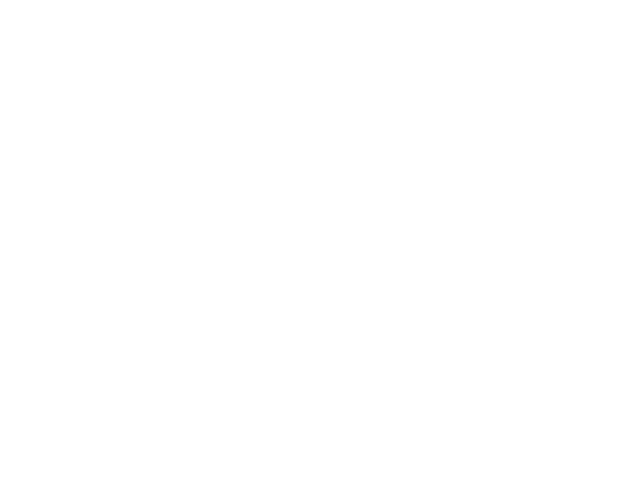

In [102]:
#FOR D1
X = D1_x_percentile_vals#[:len(x_percentile_vals) -1]
y = D1_y_percentile_vals#[:len(y_percentile_vals)-1]
#print(X)
#print(y)
X = np.asarray(X).reshape(-1, 1)
y = np.asarray(y).reshape(-1, 1)
degree=80
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X,y)
plt.figure()
plt.scatter(D1_g_median_mags, D1_sum_intrinsic_rms, s = 0.01)
plt.xlabel('Median <g> Magnitudes')
plt.ylabel('Weighted Summed Intrinsic RMS Squared')
plt.xlim(17, 24.5)
plt.ylim(-0.1, 1)
plt.plot(X,polyreg.predict(X), color="black")
plt.axhline(y = 0.0025, color = "crimson")#cutoff line
plt.axhline(y = 0.01, color = "blue")#cutoff line
plt.scatter(D1_x_percentile_vals, D1_y_percentile_vals, s = 5, c = 'red')
plt.title("Polynomial regression with degree "+str(degree))
plt.show()

<IPython.core.display.Javascript object>


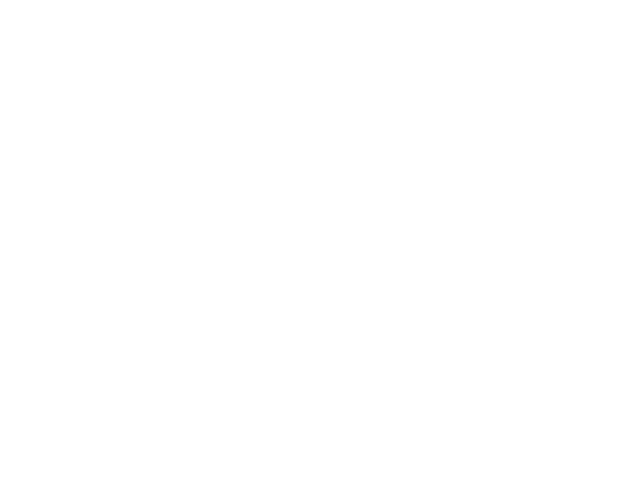

In [103]:
#FOR D2
X = D2_x_percentile_vals#[:len(x_percentile_vals) -1]
y = D2_y_percentile_vals#[:len(y_percentile_vals)-1]
#print(X)
#print(y)
X = np.asarray(X).reshape(-1, 1)
y = np.asarray(y).reshape(-1, 1)
degree=71
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X,y)
plt.figure()
plt.scatter(D2_g_median_mags, D2_sum_intrinsic_rms, s = 0.01)
plt.xlabel('Median <g> Magnitudes')
plt.ylabel('Weighted Summed Intrinsic RMS Squared')
plt.xlim(17, 24.5)
plt.ylim(-0.5, 1)
plt.plot(X,polyreg.predict(X), color="black")
plt.axhline(y = 0.0025, color = "crimson")
plt.axhline(y = 0.01, color = "blue")
plt.scatter(D2_x_percentile_vals, D2_y_percentile_vals, s = 5, c = 'red')
plt.title("Polynomial regression with degree "+str(degree))
plt.show()

<IPython.core.display.Javascript object>


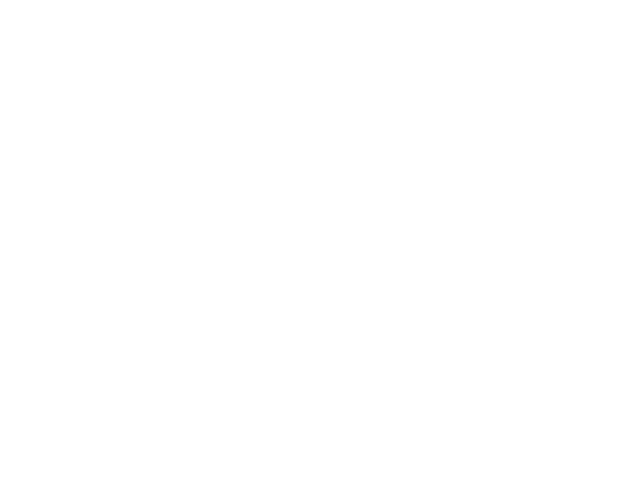

In [104]:
#FOR D3
X = D3_x_percentile_vals#[:len(x_percentile_vals) -1]
y = D3_y_percentile_vals#[:len(y_percentile_vals)-1]
#print(X)
#print(y)
X = np.asarray(X).reshape(-1, 1)
y = np.asarray(y).reshape(-1, 1)
degree=80
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X,y)
plt.figure()
plt.scatter(D3_g_median_mags, D3_sum_intrinsic_rms, s = 0.01)
plt.xlabel('Median <g> Magnitudes')
plt.ylabel('Weighted Summed Intrinsic RMS Squared')
plt.xlim(17, 24.5)
plt.ylim(-0.5, 1)
plt.plot(X,polyreg.predict(X), color="black")
plt.axhline(y = 0.0025, color = "crimson")
plt.axhline(y = 0.01, color = "blue")
plt.scatter(D3_x_percentile_vals, D3_y_percentile_vals, s = 5, c = 'red')
plt.title("Polynomial regression with degree "+str(degree))
plt.show()

<IPython.core.display.Javascript object>


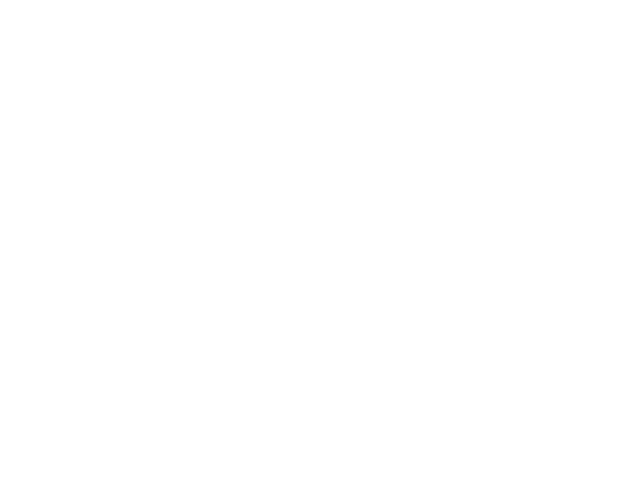

In [105]:
#FOR D4
X = D4_x_percentile_vals#[:len(x_percentile_vals) -1]
y = D4_y_percentile_vals#[:len(y_percentile_vals)-1]
#print(X)
#print(y)
X = np.asarray(X).reshape(-1, 1)
y = np.asarray(y).reshape(-1, 1)
degree=47
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X,y)
plt.figure()
plt.scatter(D4_g_median_mags, D4_sum_intrinsic_rms, s = 0.01)
plt.xlabel('Median <g> Magnitudes')
plt.ylabel('Weighted Summed Intrinsic RMS Squared')
plt.xlim(17, 24.5)
plt.ylim(-0.5, 1)
plt.plot(X,polyreg.predict(X), color="black")
plt.axhline(y = 0.0025, color = "crimson")
plt.axhline(y = 0.01, color = "blue")
plt.scatter(D4_x_percentile_vals, D4_y_percentile_vals, s = 5, c = 'red')
plt.title("Polynomial regression with degree "+str(degree))
plt.show()

In [106]:
#to find best fit
RMSE_vals = []
degree_vals = []
candidate_nums = []
X = np.asarray(X).reshape(-1, 1)
y = np.asarray(y).reshape(-1, 1)
for degree in range(1,100):
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(X,y)
    RMSE_vals.append(sklearn.metrics.mean_squared_error(y,polyreg.predict(X)))
    degree_vals.append(degree)
    #candidate parts
    variable_candidates = []
    for i in range(len(D2_sum_intrinsic_rms)):
        mags_arr = D2_g_median_mags[i]
        mags_arr = mags_arr.reshape(1, -1)
        if(D2_sum_intrinsic_rms[i] > polyreg.predict(mags_arr)):
            variable_candidates.append(i)
    candidate_nums.append(len(variable_candidates))

<IPython.core.display.Javascript object>


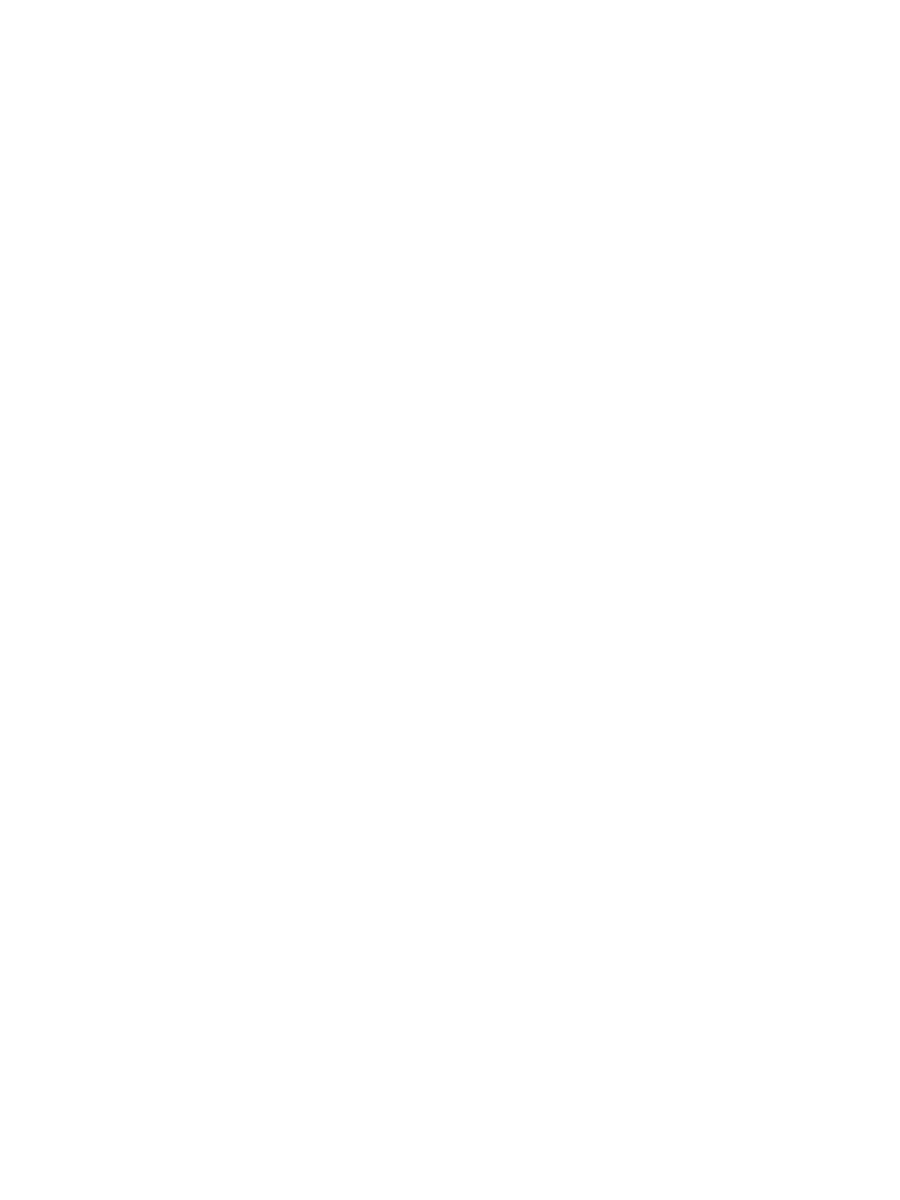

In [107]:
plt.figure(figsize = (9, 12))
plt.scatter(degree_vals, candidate_nums)
plt.show()

Categorizing variables into subtle, intermediate and highest for each field.

In [108]:
D1_marginal_variables = []
D1_intermediate_variables = []
D1_extreme_variables = []
D1_cands_over_half = []
for i in range(len(D1_sum_intrinsic_rms)):
    mags_arr = D1_g_median_mags[i]
    mags_arr = mags_arr.reshape(1, -1)
    if(D1_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D1_sum_intrinsic_rms[i] <= 0.0025 and D1_g_rms[i] > 0.1 and D1_r_rms[i] > 0.1):
        D1_marginal_variables.append(D1_indicies[i])
    if(D1_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D1_sum_intrinsic_rms[i] > 0.0025 and D1_sum_intrinsic_rms[i] <= 0.01 and D1_g_rms[i]> 0.1 and D1_r_rms[i]>0.1):
        D1_intermediate_variables.append(D1_indicies[i])
    if(D1_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D1_sum_intrinsic_rms[i] > 0.01 and D1_g_rms[i]>0.1 and D1_r_rms[i]>0.1):
        D1_extreme_variables.append(D1_indicies[i])
    if(D1_sum_intrinsic_rms[i] > 0.5):
        D1_cands_over_half.append(D1_indicies[i])

In [109]:
D2_marginal_variables = []
D2_intermediate_variables = []
D2_extreme_variables = []
D2_cands_over_half = []
for i in range(len(D2_sum_intrinsic_rms)):
    mags_arr = D2_g_median_mags[i]
    mags_arr = mags_arr.reshape(1, -1)
    if(D2_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D2_sum_intrinsic_rms[i] <= 0.0025 and D2_g_rms[i]>0.1 and D2_r_rms[i]>0.1):
        D2_marginal_variables.append(D2_indicies[i])
    if(D2_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D2_sum_intrinsic_rms[i] > 0.0025 and D2_sum_intrinsic_rms[i] <= 0.01 and D2_g_rms[i]>0.1 and D2_r_rms[i]>0.1):
        D2_intermediate_variables.append(D2_indicies[i])
    if(D2_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D2_sum_intrinsic_rms[i] > 0.01 and D2_g_rms[i]>0.1 and D2_r_rms[i]>0.1):
        D2_extreme_variables.append(D2_indicies[i])
    if(D2_sum_intrinsic_rms[i] > 0.5):
        D2_cands_over_half.append(D2_indicies[i])

In [110]:
D3_marginal_variables = []
D3_intermediate_variables = []
D3_extreme_variables = []
D3_cands_over_half = []
for i in range(len(D3_sum_intrinsic_rms)):
    mags_arr = D3_g_median_mags[i]
    mags_arr = mags_arr.reshape(1, -1)
    if(D3_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D3_sum_intrinsic_rms[i] <= 0.0025 and D3_g_rms[i]>0.1 and D3_r_rms[i]>0.1):
        D3_marginal_variables.append(D3_indicies[i])
    if(D3_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D3_sum_intrinsic_rms[i] > 0.0025 and D3_sum_intrinsic_rms[i] <= 0.01 and D3_g_rms[i]>0.1 and D3_r_rms[i]>0.1):
        D3_intermediate_variables.append(D3_indicies[i])
    if(D3_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D3_sum_intrinsic_rms[i] > 0.01 and D3_g_rms[i]>0.1 and D3_r_rms[i]>0.1):
        D3_extreme_variables.append(D3_indicies[i])
    if(D3_sum_intrinsic_rms[i] > 0.5):
        D3_cands_over_half.append(D3_indicies[i])

In [111]:
D4_marginal_variables = []
D4_intermediate_variables = []
D4_extreme_variables = []
D4_cands_over_half = []
for i in range(len(D4_sum_intrinsic_rms)):
    mags_arr = D4_g_median_mags[i]
    mags_arr = mags_arr.reshape(1, -1)
    if(D4_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D4_sum_intrinsic_rms[i] <= 0.0025 and D4_g_rms[i]>0.1 and D4_r_rms[i]>0.1):
        D4_marginal_variables.append(D4_indicies[i])
    if(D4_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D4_sum_intrinsic_rms[i] > 0.0025 and D4_sum_intrinsic_rms[i] <= 0.01 and D4_g_rms[i]>0.1 and D4_r_rms[i]>0.1):
        D4_intermediate_variables.append(D4_indicies[i])
    if(D4_sum_intrinsic_rms[i] > polyreg.predict(mags_arr) and D4_sum_intrinsic_rms[i] > 0.01 and D4_g_rms[i]>0.1 and D4_r_rms[i]>0.1):
        D4_extreme_variables.append(D4_indicies[i])
    if(D4_sum_intrinsic_rms[i] > 0.5):
        D4_cands_over_half.append(D4_indicies[i])

In [112]:
#usually don't download more than 600 at a time or the computer will crash
#reminder: CHARGE THE COMPUTER WHILE DOING THIS
def pdf_unfolded_light_curve(objects, pdf_name):
    """
    Function to create pdfs of unfolded light curve plots for all objects of interest
    
    Parameters
    ---
    objects: array of indicies of objects of interest in file_list
    pdf_name: name of pdf
    
    Returns
    ---
    pdf of magnitude vs MJD for all objects
    """

    plt.ioff()
    with PdfPages(pdf_name) as pdf:
        for star_object in objects:
            plt.figure(figsize = (9, 12))
            plt.xlabel('MJD')
            plt.ylabel('Magnitude')
            plt.gca().invert_yaxis()
            plt.scatter(all_mjd[star_object][0], all_mags[star_object][0], s = 5, c = 'blue', label = 'u')
            plt.scatter(all_mjd[star_object][1], all_mags[star_object][1], s = 5, c = 'green', label = 'g')
            plt.scatter(all_mjd[star_object][2], all_mags[star_object][2], s = 5, c = 'purple', label = 'r')
            plt.scatter(all_mjd[star_object][3], all_mags[star_object][3], s = 5, c = 'gold', label = 'i')
            plt.scatter(all_mjd[star_object][4], all_mags[star_object][4], s = 5, c = 'tab:red', label = 'z')
            plt.legend()
            plt.title(fnames[star_object] + " (" + str(star_object) + ")")
            pdf.savefig()
            plt.close()

In [113]:
#Once all the code below has run, USE THIS TO CHECK THE LENGTHS OF EACH SO YOU DON'T CRASH THE COMPUTER WHEN RUNNING THE CODE BLOCK BELOW
print(len(D1_marginal_variables))
print(len(D2_marginal_variables))
print(len(D3_marginal_variables))
print(len(D4_marginal_variables))

print(len(D1_intermediate_variables))
print(len(D2_intermediate_variables))
print(len(D3_intermediate_variables))
print(len(D4_intermediate_variables))

print(len(D1_extreme_variables))
print(len(D2_extreme_variables))
print(len(D3_extreme_variables))
print(len(D4_extreme_variables))

0
0
0
0
7
8
3
10
590
495
513
773


In [114]:
#RUN THIS LAST
#pdf_unfolded_light_curve([file_names], "21719.pdf")
#print(len(all_mjd))

Downloading indicies of candidate variables into excel

In [115]:
import pandas as pd

In [116]:
D1_marginal_df = pd.DataFrame(D1_marginal_variables, columns=['ID'])
D1_intermediate_df = pd.DataFrame(D1_intermediate_variables, columns=['ID'])
D1_extreme_df = pd.DataFrame(D1_extreme_variables, columns=['ID'])

D2_marginal_df = pd.DataFrame(D2_marginal_variables, columns=['ID'])
D2_intermediate_df = pd.DataFrame(D2_intermediate_variables, columns=['ID'])
D2_extreme_df = pd.DataFrame(D2_extreme_variables, columns=['ID'])

D3_marginal_df = pd.DataFrame(D3_marginal_variables, columns=['ID'])
D3_intermediate_df = pd.DataFrame(D3_intermediate_variables, columns=['ID'])
D3_extreme_df = pd.DataFrame(D3_extreme_variables, columns=['ID'])

D4_marginal_df = pd.DataFrame(D4_marginal_variables, columns=['ID'])
D4_intermediate_df = pd.DataFrame(D4_intermediate_variables, columns=['ID'])
D4_extreme_df = pd.DataFrame(D4_extreme_variables, columns=['ID'])

In [117]:
with pd.ExcelWriter('AST-07_UnfoldedLightCurveNotes.xlsx') as writer:
    D1_marginal_df.to_excel(writer, sheet_name = 'D1_marginal')
    D1_intermediate_df.to_excel(writer, sheet_name = 'D1_intermediate')
    D1_extreme_df.to_excel(writer, sheet_name = 'D1_extreme')
    D2_marginal_df.to_excel(writer, sheet_name = 'D2_marginal')
    D2_intermediate_df.to_excel(writer, sheet_name = 'D2_intermediate')
    D2_extreme_df.to_excel(writer, sheet_name = 'D2_extreme')
    D3_marginal_df.to_excel(writer, sheet_name = 'D3_marginal')
    D3_intermediate_df.to_excel(writer, sheet_name = 'D3_intermediate')
    D3_extreme_df.to_excel(writer, sheet_name = 'D3_extreme')
    D4_marginal_df.to_excel(writer, sheet_name = 'D4_marginal')
    D4_intermediate_df.to_excel(writer, sheet_name = 'D4_intermediate')
    D4_extreme_df.to_excel(writer, sheet_name = 'D4_extreme')

The following code creates color color diagrams and histograms.

<IPython.core.display.Javascript object>


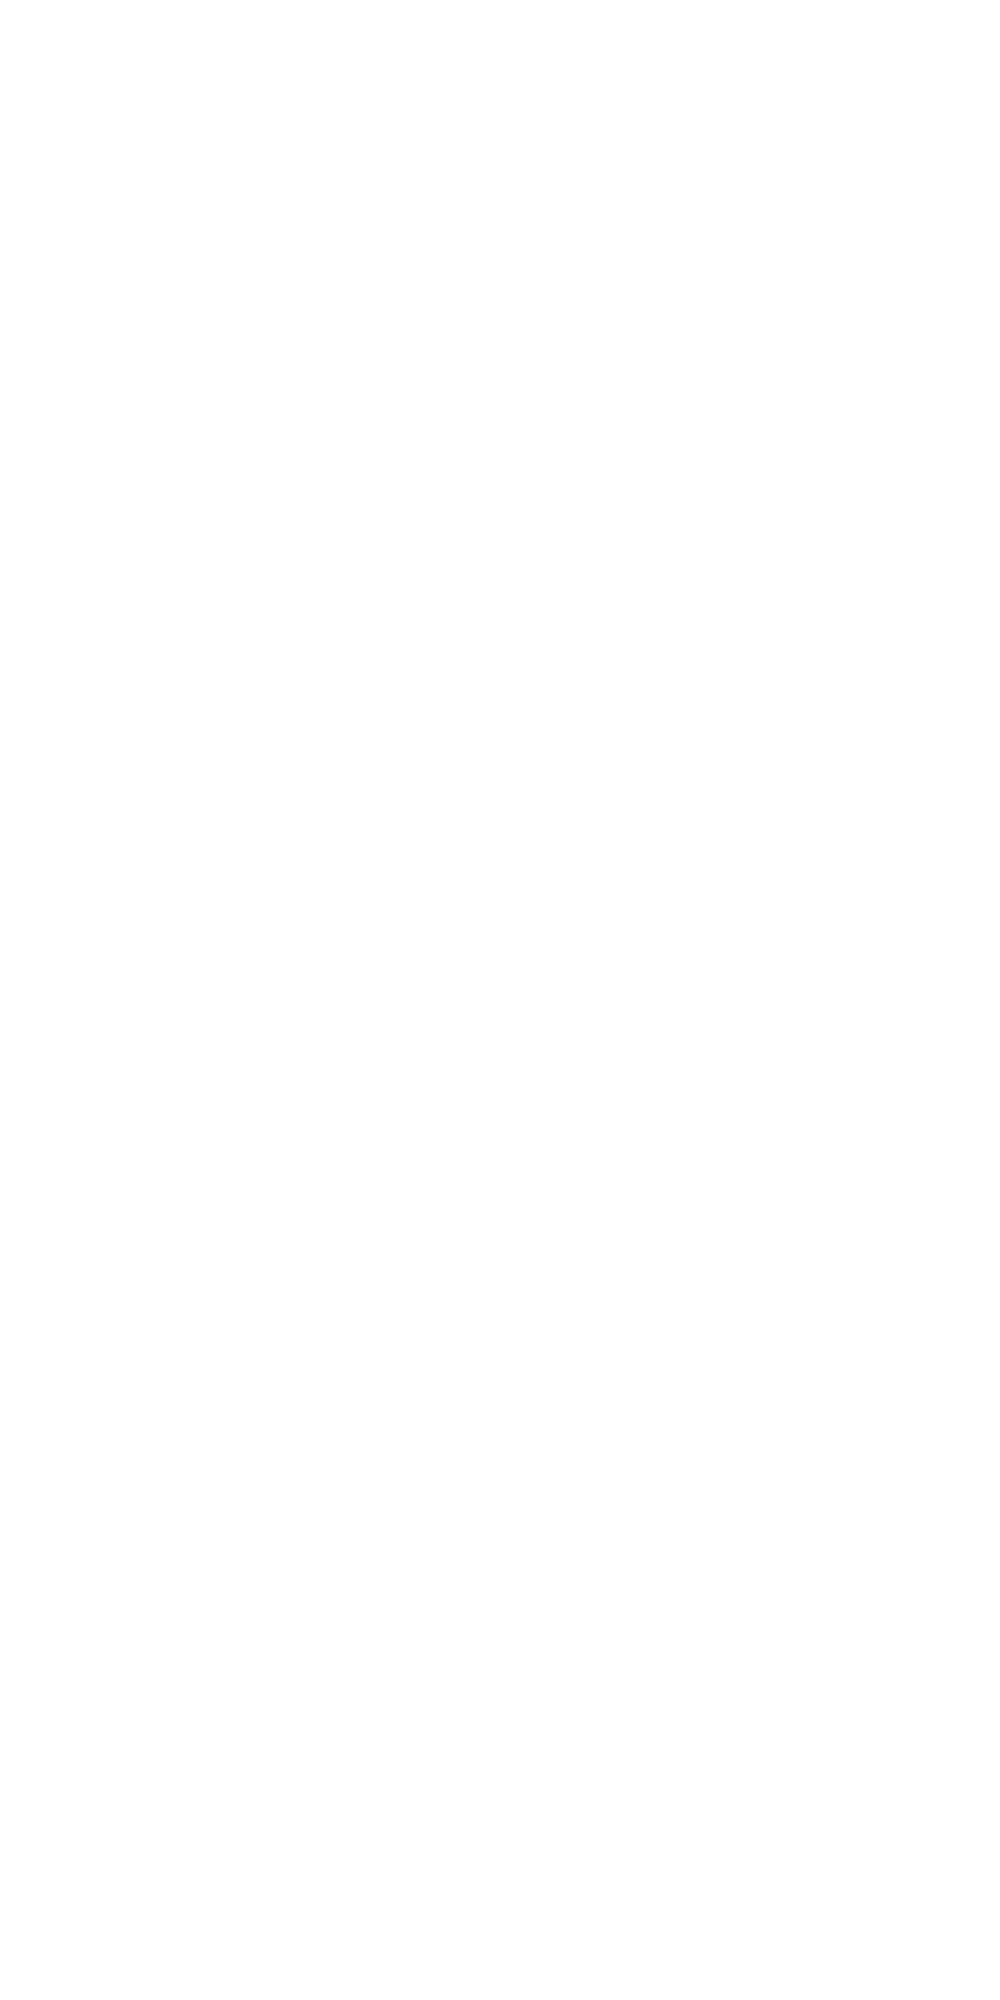

In [118]:
plt.ion()
marginal_variables = []
intermediate_variables = []
highest_variables = []
#initialize:
marginal_variables.extend(D1_marginal_variables)
marginal_variables.extend(D2_marginal_variables)
marginal_variables.extend(D3_marginal_variables)
marginal_variables.extend(D4_marginal_variables)
#initialize:
intermediate_variables.extend(D1_intermediate_variables)
intermediate_variables.extend(D2_intermediate_variables)
intermediate_variables.extend(D3_intermediate_variables)
intermediate_variables.extend(D4_intermediate_variables)
#intitialize:
highest_variables.extend(D1_marginal_variables)
highest_variables.extend(D2_marginal_variables)
highest_variables.extend(D3_marginal_variables)
highest_variables.extend(D4_marginal_variables)
def getx(object_index,string_val):
    obj = all_mags[object_index]
    x = None
    y = None
    if string_val == 'u-g':
        x = np.median(obj[0])
        y = np.median(obj[1])
    elif string_val == 'r-i':
        x = np.median(obj[2])
        y = np.median(obj[3])
    elif string_val == 'i-z':
        x = np.median(obj[3])
        y = np.median(obj[4])
    elif string_val == 'g-r':
        x = np.median(obj[1])
        y = np.median(obj[2])
    val = x - y
    return val
x1_vals = [[],[],[],[]]
y1_vals = [[],[],[],[]]
x2_vals = [[],[],[],[]]
y2_vals = [[],[],[],[]]
x3_vals = [[],[],[],[]]
y3_vals = [[],[],[],[]]
for star_index in range(len(all_mags)):
    if star_index in marginal_variables:
        y1_vals[1].append(getx(star_index,'u-g'))
        x1_vals[1].append(getx(star_index,'g-r'))
        y2_vals[1].append(getx(star_index,'r-i'))
        x2_vals[1].append(getx(star_index,'g-r'))
        y3_vals[1].append(getx(star_index,'i-z'))
        x3_vals[1].append(getx(star_index,'g-r'))
    if star_index in intermediate_variables:
        y1_vals[2].append(getx(star_index,'u-g'))
        x1_vals[2].append(getx(star_index,'g-r'))
        y2_vals[2].append(getx(star_index,'r-i'))
        x2_vals[2].append(getx(star_index,'g-r'))
        y3_vals[2].append(getx(star_index,'i-z'))
        x3_vals[2].append(getx(star_index,'g-r'))
    if star_index in highest_variables:
        y1_vals[3].append(getx(star_index,'u-g'))
        x1_vals[3].append(getx(star_index,'g-r'))
        y2_vals[3].append(getx(star_index,'r-i'))
        x2_vals[3].append(getx(star_index,'g-r'))
        y3_vals[3].append(getx(star_index,'i-z'))
        x3_vals[3].append(getx(star_index,'g-r'))
    else:
        y1_vals[0].append(getx(star_index,'u-g'))
        x1_vals[0].append(getx(star_index,'g-r'))
        y2_vals[0].append(getx(star_index,'r-i'))
        x2_vals[0].append(getx(star_index,'g-r'))
        y3_vals[0].append(getx(star_index,'i-z'))
        x3_vals[0].append(getx(star_index,'g-r'))
fig = plt.figure(figsize = (10, 20))
ax1 = fig.add_subplot(4, 3, 1)
ax2 = fig.add_subplot(4, 3, 2)
ax3 = fig.add_subplot(4, 3, 3)
ax4 = fig.add_subplot(4, 3, 4)
ax5 = fig.add_subplot(4, 3, 5)
ax6 = fig.add_subplot(4, 3, 6)
ax7 = fig.add_subplot(4, 3, 7)
ax8 = fig.add_subplot(4, 3, 8)
ax9 = fig.add_subplot(4, 3, 9)
#spacer --> green for highest, red for marginal, blue for intermediate, black for nonvariables
ax1.scatter(x1_vals[0],y1_vals[0],s = 0.01, c='silver', label = 'nonvariables')
ax1.scatter(x1_vals[2],y1_vals[2],s = 0.05, c='blue', label = 'intermediate')
ax1.scatter(x1_vals[3],y1_vals[3],s = 0.1, c='green', label = 'highest')
ax1.scatter(x1_vals[1],y1_vals[1],s = 0.05, c='crimson', label = 'marginal')
ax2.scatter(x2_vals[0],y2_vals[0],s=0.01,c='silver', label = 'nonvariables')
ax2.scatter(x2_vals[2],y2_vals[2],s=0.05,c='blue', label = 'intermediate')
ax2.scatter(x2_vals[3],y2_vals[3],s=0.1,c='green', label = 'highest')
ax2.scatter(x2_vals[1],y2_vals[1],s=0.05,c='crimson', label = 'marginal')
ax3.scatter(x3_vals[0],y3_vals[0],s=0.01,c='silver', label = 'nonvariables')
ax3.scatter(x3_vals[2],y3_vals[2],s=0.05,c='blue', label = 'intermediate')
ax3.scatter(x3_vals[3],y3_vals[3],s=0.1,c='green', label = 'highest')
ax3.scatter(x3_vals[1],y3_vals[1],s=0.05,c='crimson', label = 'marginal')

ax4.scatter(x1_vals[2],y1_vals[2],s = 0.01, c='blue', label = 'intermediate')
ax4.scatter(x1_vals[3],y1_vals[3],s = 0.05, c='green', label = 'highest')
ax4.scatter(x1_vals[1],y1_vals[1],s = 0.01, c='crimson', label = 'marginal')

ax5.scatter(x2_vals[2],y2_vals[2],s=0.01,c='blue', label = 'intermediate')
ax5.scatter(x2_vals[3],y2_vals[3],s=0.05,c='green', label = 'highest')
ax5.scatter(x2_vals[1],y2_vals[1],s=0.01,c='crimson', label = 'marginal')

ax6.scatter(x3_vals[2],y3_vals[2],s=0.01,c='blue', label = 'intermediate')
ax6.scatter(x3_vals[3],y3_vals[3],s=0.05,c='green', label = 'highest')
ax6.scatter(x3_vals[1],y3_vals[1],s=0.01,c='crimson', label = 'marginal')

x_lower = -0.25
x_higher = 1.5
ax1.set_xlim(x_lower, x_higher)
ax1.set_ylim(-0.5, 3)
ax2.set_xlim(x_lower, x_higher)
ax2.set_ylim(-0.5, 2.5)
ax3.set_xlim(x_lower, x_higher)
ax3.set_ylim(-0.5, 1)
ax4.set_xlim(x_lower, x_higher)
ax4.set_ylim(-0.5, 3)
ax5.set_xlim(x_lower, x_higher)
ax5.set_ylim(-0.5, 2.5)
ax6.set_xlim(x_lower, x_higher)
ax6.set_ylim(-0.5, 1)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
#ax1.scatter(x1_vals[0,y1_vals[0],c='black')
plt.show()

In [119]:

all_cands_over_half = []
all_cands_over_half.extend(D1_cands_over_half)
all_cands_over_half.extend(D1_cands_over_half)
all_cands_over_half.extend(D1_cands_over_half)
all_cands_over_half.extend(D1_cands_over_half)
plot_2_x1 = []
plot_2_y1 = []
plot_2_x2 = []
plot_2_y2 = []
plot_2_x3 = []
plot_2_y3 = []
def getx(object_index,string_val):
    obj = all_mags[object_index]
    x = None
    y = None
    if string_val == 'u-g':
        x = np.median(obj[0])
        y = np.median(obj[1])
    elif string_val == 'r-i':
        x = np.median(obj[2])
        y = np.median(obj[3])
    elif string_val == 'i-z':
        x = np.median(obj[3])
        y = np.median(obj[4])
    elif string_val == 'g-r':
        x = np.median(obj[1])
        y = np.median(obj[2])
    val = x - y
    return val
for i in all_cands_over_half:
    plot_2_y1.append(getx(i,'u-g'))
    plot_2_x1.append(getx(i,'g-r'))
    plot_2_y2.append(getx(i,'r-i'))
    plot_2_x2.append(getx(i,'g-r'))
    plot_2_y3.append(getx(i,'i-z'))
    plot_2_x3.append(getx(i,'g-r'))
ax7.scatter(plot_2_x1,plot_2_y1,s=0.01, c = "black")
ax8.scatter(plot_2_x2,plot_2_y2,s=0.01, c = "black")
ax9.scatter(plot_2_x3,plot_2_y3,s=0.01, c = "black")
ax7.set_xlim(-0.25, 1.5)
ax8.set_xlim(-0.25, 1.5)
ax9.set_xlim(-0.25, 1.5)
ax7.set_ylim(-0.5, 3)
ax8.set_ylim(-0.5, 2.5)
ax9.set_ylim(-0.5, 1)

(-0.5, 1.0)

In [120]:
'''
not_in = []
for i in f200:
    if i not in variable_candidates:
        print("Not in variable candidates: " + str(i))
        not_in.append(i)
'''

'\nnot_in = []\nfor i in f200:\n    if i not in variable_candidates:\n        print("Not in variable candidates: " + str(i))\n        not_in.append(i)\n'

In [121]:
color_color_1 = [i for i in range(len(g_median_mags)) if g_median_mags[i] <= 22.5]
color_color_2 = [i for i in range(len(g_median_mags)) if g_median_mags[i] > 22.5]

NameError: name 'g_median_mags' is not defined

In [ ]:
print(len(color_color_1))

In [ ]:
print(len(color_color_1))
print(len(color_color_2))

In [ ]:
u_median_mags_1 = [np.median(all_mags_2[i][0]) for i in range(len(all_mags_2)) if i in variable_candidates and i in color_color_1]
g_median_mags_1 = [np.median(all_mags_2[i][1]) for i in range(len(all_mags_2)) if i in variable_candidates and i in color_color_1]
r_median_mags_1 = [np.median(all_mags_2[i][2]) for i in range(len(all_mags_2)) if i in variable_candidates and i in color_color_1]
i_median_mags_1 = [np.median(all_mags_2[i][3]) for i in range(len(all_mags_2)) if i in variable_candidates and i in color_color_1]
z_median_mags_1 = [np.median(all_mags_2[i][4]) for i in range(len(all_mags_2)) if i in variable_candidates and i in color_color_1]
u_median_mags_2 = [np.median(all_mags_2[i][0]) for i in range(len(all_mags_2)) if i in variable_candidates and i in color_color_2]
g_median_mags_2 = [np.median(all_mags_2[i][1]) for i in range(len(all_mags_2)) if i in variable_candidates and i in color_color_2]
r_median_mags_2 = [np.median(all_mags_2[i][2]) for i in range(len(all_mags_2)) if i in variable_candidates and i in color_color_2]
i_median_mags_2 = [np.median(all_mags_2[i][3]) for i in range(len(all_mags_2)) if i in variable_candidates and i in color_color_2]
z_median_mags_2 = [np.median(all_mags_2[i][4]) for i in range(len(all_mags_2)) if i in variable_candidates and i in color_color_2]
all_u_median_mags_1 = [np.median(all_mags_2[i][0]) for i in range(len(all_mags_2)) if i in color_color_1]
all_g_median_mags_1 = [np.median(all_mags_2[i][1]) for i in range(len(all_mags_2)) if i in color_color_1]
all_r_median_mags_1 = [np.median(all_mags_2[i][2]) for i in range(len(all_mags_2)) if i in color_color_1]
all_i_median_mags_1 = [np.median(all_mags_2[i][3]) for i in range(len(all_mags_2)) if i in color_color_1]
all_z_median_mags_1 = [np.median(all_mags_2[i][4]) for i in range(len(all_mags_2)) if i in color_color_1]
all_u_median_mags_2 = [np.median(all_mags_2[i][0]) for i in range(len(all_mags_2)) if i in color_color_2]
all_g_median_mags_2 = [np.median(all_mags_2[i][1]) for i in range(len(all_mags_2)) if i in color_color_2]
all_r_median_mags_2 = [np.median(all_mags_2[i][2]) for i in range(len(all_mags_2)) if i in color_color_2]
all_i_median_mags_2 = [np.median(all_mags_2[i][3]) for i in range(len(all_mags_2)) if i in color_color_2]
all_z_median_mags_2 = [np.median(all_mags_2[i][4]) for i in range(len(all_mags_2)) if i in color_color_2]
x_vals_1 = [g_median_mags_1[i] - r_median_mags_1[i] for i in range(len(g_median_mags_1))]
x_vals_2 = [g_median_mags_2[i] - r_median_mags_2[i] for i in range(len(g_median_mags_2))]
u_minus_g_1 = [u_median_mags_1[i] - g_median_mags_1[i] for i in range(len(g_median_mags_1))]
u_minus_g_2 = [u_median_mags_2[i] - g_median_mags_2[i] for i in range(len(g_median_mags_2))]
r_minus_i_1 = [r_median_mags_1[i] - i_median_mags_1[i] for i in range(len(r_median_mags_1))]
r_minus_i_2 = [r_median_mags_2[i] - i_median_mags_2[i] for i in range(len(r_median_mags_2))]
i_minus_z_1 = [i_median_mags_1[i] - z_median_mags_1[i] for i in range(len(i_median_mags_1))]
i_minus_z_2 = [i_median_mags_2[i] - z_median_mags_2[i] for i in range(len(i_median_mags_2))]
x_vals_3 = [all_g_median_mags_1[i] - all_r_median_mags_1[i] for i in range(len(all_g_median_mags_1))]
x_vals_4 = [all_g_median_mags_2[i] - all_r_median_mags_2[i] for i in range(len(all_g_median_mags_2))]
all_u_minus_g_1 = [all_u_median_mags_1[i] - all_g_median_mags_1[i] for i in range(len(all_g_median_mags_1))]
all_u_minus_g_2 = [all_u_median_mags_2[i] - all_g_median_mags_2[i] for i in range(len(all_g_median_mags_2))]
all_r_minus_i_1 = [all_r_median_mags_1[i] - all_i_median_mags_1[i] for i in range(len(all_r_median_mags_1))]
all_r_minus_i_2 = [all_r_median_mags_2[i] - all_i_median_mags_2[i] for i in range(len(all_r_median_mags_2))]
all_i_minus_z_1 = [all_i_median_mags_1[i] - all_z_median_mags_1[i] for i in range(len(all_i_median_mags_1))]
all_i_minus_z_2 = [all_i_median_mags_2[i] - all_z_median_mags_2[i] for i in range(len(all_i_median_mags_2))]

In [ ]:
fig = plt.figure(figsize = (10, 20))
ax1 = fig.add_subplot(4, 3, 1)
ax2 = fig.add_subplot(4, 3, 2)
ax3 = fig.add_subplot(4, 3, 3)
ax4 = fig.add_subplot(4, 3, 4)
ax5 = fig.add_subplot(4, 3, 5)
ax6 = fig.add_subplot(4, 3, 6)
ax7 = fig.add_subplot(4, 3, 7)
ax8 = fig.add_subplot(4, 3, 8)
ax9 = fig.add_subplot(4, 3, 9)
ax10 = fig.add_subplot(4, 3, 10)
ax11 = fig.add_subplot(4, 3, 11)
ax12 = fig.add_subplot(4, 3, 12)
ax1.scatter(x_vals_1,u_minus_g_1,s = 0.01)
ax2.scatter(x_vals_1,r_minus_i_1,s = 0.01)
ax3.scatter(x_vals_1,i_minus_z_1,s = 0.01)
ax4.scatter(x_vals_2, u_minus_g_2, s = 0.01)
ax5.scatter(x_vals_2, r_minus_i_2, s = 0.01)
ax6.scatter(x_vals_2, i_minus_z_2, s = 0.01)
ax7.scatter(x_vals_3,all_u_minus_g_1,s = 0.01)
ax8.scatter(x_vals_3,all_r_minus_i_1,s = 0.01)
ax9.scatter(x_vals_3,all_i_minus_z_1,s = 0.01)
ax10.scatter(x_vals_4, all_u_minus_g_2, s = 0.01)
ax11.scatter(x_vals_4, all_r_minus_i_2, s = 0.01)
ax12.scatter(x_vals_4, all_i_minus_z_2, s = 0.01)
ax1.set_xlim(-0.5,1.5)
ax4.set_xlim(-0.5, 1.5)
ax7.set_xlim(-0.5,1.5)
ax10.set_xlim(-0.5, 1.5)
ax2.set_xlim(-0.5,1.5)
ax5.set_xlim(-0.5, 1.5)
ax8.set_xlim(-0.5,1.5)
ax11.set_xlim(-0.5, 1.5)
ax3.set_xlim(-0.5,1.5)
ax6.set_xlim(-0.5, 1.5)
ax9.set_xlim(-0.5,1.5)
ax12.set_xlim(-0.5, 1.5)
ax1.set_ylim(-0.3,2.5)
ax4.set_ylim(-0.3,2.5)
ax7.set_ylim(-0.3,2.5)
ax10.set_ylim(-0.3,2.5)
ax2.set_xlim(-0.5,2)
ax5.set_xlim(-0.5,2)
ax8.set_xlim(-0.5,2)
ax11.set_xlim(-0.5,2)
ax3.set_ylim(-0.4,0.9)
ax6.set_ylim(-0.4,0.9)
ax9.set_ylim(-0.4,0.9)
ax12.set_ylim(-0.4,0.9)
ax1.set_xlabel('<g> - <r>')
ax2.set_xlabel('<g> - <r>')
ax3.set_xlabel('<g> - <r>')
ax4.set_xlabel('<g> - <r>')
ax5.set_xlabel('<g> - <r>')
ax6.set_xlabel('<g> - <r>')
ax1.set_ylabel('<u> - <g>')
ax2.set_ylabel('<r> - <i>')
ax3.set_ylabel('<i> - <z>')
ax4.set_ylabel('<u> - <g>')
ax5.set_ylabel('<r> - <i>')
ax6.set_ylabel('<i> - <z>')
ax7.set_xlabel('<g> - <r>')
ax8.set_xlabel('<g> - <r>')
ax9.set_xlabel('<g> - <r>')
ax10.set_xlabel('<g> - <r>')
ax11.set_xlabel('<g> - <r>')
ax12.set_xlabel('<g> - <r>')
ax7.set_ylabel('<u> - <g>')
ax8.set_ylabel('<r> - <i>')
ax9.set_ylabel('<i> - <z>')
ax10.set_ylabel('<u> - <g>')
ax11.set_ylabel('<r> - <i>')
ax12.set_ylabel('<i> - <z>')
plt.show()

In [ ]:
all_bands_intrinsic_rms_squared = [u_intrinsic_rms_squared,g_intrinsic_rms_squared,r_intrinsic_rms_squared,i_intrinsic_rms_squared,z_intrinsic_rms_squared]
range_vals = np.arange(min(g_median_mags),max(g_median_mags),0.5)
in_bin_medians_g = []
in_bin_intrinsic = []
for i in range(len(range_vals)-1):
    temp_medians = []
    temp_intrinsic = []
    for j in range(len(g_median_mags)):
        if (range_vals[i] < g_median_mags[j] < range_vals[i+1]):
            temp_medians.append(g_median_mags[j])
            temp_intrinsic.append(sum([all_bands_intrinsic_rms_squared[z][j] for z in range(5)]))
    in_bin_medians_g.append(temp_medians)
    in_bin_intrinsic.append(temp_intrinsic)

In [ ]:
def make_histogram(intrinsic_rms_squared,i):
    x_vals = [intrinsic_rms_squared[i][0][0] for i in range(len(intrinsic_rms_squared))]
    plt.figure()
    print('max value: ' + str(max(x_vals)))
    plt.title("Bin: " + str(i))
    plt.xlabel("Summed Intrinsic Rms\u00b2")
    plt.ylabel("Frequency")
    plt.hist(x_vals,bins=300)
    plt.show()

In [ ]:
for i in range(len(in_bin_intrinsic)):
    make_histogram(in_bin_intrinsic[i],i)

The following code runs the lomb-scargle periodogram and creates folded light curves.

In [ ]:
def plot_unfolded_light_curve(objects):
    """
    Function to create unfolded light curve plots for all objects of interest
    
    Parameters
    ---
    objects: array of indicies of objects of interest in file_list
    
    Returns
    ---
    plots of magnitude vs MJD for all objects
    """

    for star_object in objects:
        plt.figure(figsize = (9, 12))
        plt.xlabel('MJD')
        plt.ylabel('Magnitude')
        plt.gca().invert_yaxis()
        plt.scatter(all_mjd[star_object][0], all_mags[star_object][0], s = 5, c = 'blue', label = 'u')
        plt.scatter(all_mjd[star_object][1], all_mags[star_object][1], s = 5, c = 'green', label = 'g')
        plt.scatter(all_mjd[star_object][2], all_mags[star_object][2], s = 5, c = 'purple', label = 'r')
        plt.scatter(all_mjd[star_object][3], all_mags[star_object][3], s = 5, c = 'gold', label = 'i')
        plt.scatter(all_mjd[star_object][4], all_mags[star_object][4], s = 5, c = 'tab:red', label = 'z')
        plt.legend()
        plt.title(fnames[star_object] + " (" + str(star_object) + ")")
        plt.show()

In [ ]:
RRLyraeCandidates = ["CFHTLS-VAR-J221527.94-180359.8",
                     "CFHTLS-VAR-J022558.35-044544.5",
                     "CFHTLS-VAR-J022712.55-050049.6",
                     "CFHTLS-VAR-J022556.10-044724.4",
                     "CFHTLS-VAR-J022542.55-041404.4",
                     "CFHTLS-VAR-J095845.52+021938.3",
                     "CFHTLS-VAR-J100042.77+022209.5",
                     "CFHTLS-VAR-J100138.62+020551.6",
                     "CFHTLS-VAR-J100202.52+022941.7",
                     "CFHTLS-VAR-J100119.29+023640.7",
                     "CFHTLS-VAR-J095856.90+020149.9",
                     "CFHTLS-VAR-J100154.46+022211.0",
                     "CFHTLS-VAR-J100116.96+021851.9",
                     "CFHTLS-VAR-J100106.84+014839.8",
                     "CFHTLS-VAR-J221433.96-175616.2",
                     "CFHTLS-VAR-J221636.70-173440.8",
                     "CFHTLS-VAR-J221601.77-171307.3",
                     "CFHTLS-VAR-J221358.09-173333.4",
                     "CFHTLS-VAR-J221354.74-173840.3",
                     "CFHTLS-VAR-J221725.90-181220.7",
                     "CFHTLS-VAR-J221415.21-180527.9",
                     "CFHTLS-VAR-J221500.15-181226.8",
                     "CFHTLS-VAR-J221516.45-175137.6"]
RRLyraeCandidates_indices = []

for i in RRLyraeCandidates:
    RRLyraeCandidates_indices.append(fnames.index(i))
    
print(RRLyraeCandidates_indices)

plot_unfolded_light_curve(RRLyraeCandidates_indices)

In [ ]:
def data_format (object_number):
    """
    Function that formats the data for one object for Lomb Scargle Periodogram.
    Parameters
    ---
    object_number: int for object ID a.k.a. index in all_mags
    Returns
    ---
    filts: array of bands ex. ['u', 'g', 'g', 'r']
    mags: array of apparent magnitudes that is the same length as filts
    mjd: array of mjd
    dy: array of measurement errors
    """
    filts = []
    temp_u = ['u' for i in all_mags[object_number][0]]
    temp_g = ['g' for i in all_mags[object_number][1]]
    temp_r = ['r' for i in all_mags[object_number][2]]
    temp_i = ['i' for i in all_mags[object_number][3]]
    temp_z = ['z' for i in all_mags[object_number][4]]
    filts.append(temp_u)
    filts.append(temp_g)
    filts.append(temp_r)
    filts.append(temp_i)
    filts.append(temp_z)
    filts = list(chain.from_iterable(filts))
    
    mags = list(chain.from_iterable(all_mags[object_number])) #turning 2d array into 1d
    
    t = list(chain.from_iterable(all_mjd[object_number]))
    
    #dy = [1 for i in mags]
    dy = list(chain.from_iterable(all_magerrs[object_number]))
    dy = [99 if i == 0 else i for i in dy]
    return t, mags, dy, filts

In [ ]:
t, mags, dy, filts = data_format(RRLyraeCandidates_indices[2])

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib as mpl
#mpl.style.use('ggplot')
#mpl.rc('axes', color_cycle=["#4C72B0", "#55A868", "#C44E52","#8172B2", "#CCB974"]) colors for each band
#from gatspy.periodic import LombScargleMultiband
#from gatspy import datasets, periodic

# Choose a Sesar 2010 object to base our fits on
#lcid = 1019544
#rrlyrae = datasets.RRLyraeGenerated(lcid, random_state=0)

# Generate data in a 6-month observing season
#Nobs = 60
#rng = np.random.RandomState(0)

#nights = np.arange(180)
#rng.shuffle(nights)
#nights = nights[:Nobs]

#t = 57000 + nights + 0.05 * rng.randn(Nobs)
#dy = 0.06 + 0.01 * rng.randn(Nobs)
#mags = np.array([rrlyrae.generated(band, t, err=dy, corrected=False)for band in 'ugriz'])
"""
All the above are not necessary for the NGVS_legacy work, becuase you do have realistic data.
I generate mock datesets just to test to code and show an example result.
"""

"""
Here start the fitting process. 
t, mags, dy, filts are all N-d arraies of your observation data. They mean observation time in MJD, apperent magnitudes, errors, and filter list, respectively
If you do not have error list, set dy to be all ones.
filts could be anything in the format of np.array(['u','u','g', ..., 'z']), as long as its elements are filter names and its length equal to the mags array
"""
#example of appropriate format
#filts = np.take(list('ugriz'), np.arange(Nobs), mode='wrap') 
# 
#mags = mags[np.arange(Nobs) % 5, np.arange(Nobs)]
#masks = [(filts == band) for band in 'ugriz']#separate ugriz to 5 sublists

#below is the necessary code
periods = np.linspace(0.1, 1, 100000) # This defines the search range of your period, you can specify it at your will. These are in days.


#2 different ways of fitting
##model = periodic.NaiveMultiband(BaseModel=periodic.LombScargleFast) 
# specify the method to be the naive multiband LS, which means you fit data in each band separately, and get a score list for each band.
# serves as a good first try on your NGVS_legacy data
#above is the fastest way. x axis is period, y axis is score. 5d array output. real variable should have same peak for all bands
##model.fit(t, mags, dy, filts) 
##P = model.scores(periods) 
# This is the fitting score list you want. 
# It is a 5xN array, where N is number of periods tried, P[0] is the fit socres of periods with your u band data. And so on for P[1] for g, P[2] for i, ...
# Each element in P[i] correspond to a period in the array periods you input. The closer to 1, the better.


#all bands done together
LS_multi = periodic.LombScargleMultiband(Nterms_base=1, Nterms_band=2)#initiate structure variable
LS_multi.fit(t, mags, dy, filts)#input our data
P_multi = LS_multi.periodogram(periods)#function where input is periods
# A non-naive way of multiband fitting. This time all data from all bands are fitted simultaneously, means you do not get scores for each band separately.
# P_multi will be a 1-d array, has equal length to your input periods. The maximum value in P_multi will be the best fit, and its corresponding period will be the best period.

#do both!!

"""
From here are visualization of the results.

fig = plt.figure(figsize=(10, 4))
gs = plt.GridSpec(5, 2, left=0.07, right=0.95, bottom=0.15,
                  wspace=0.1, hspace=0.6)
ax = [fig.add_subplot(gs[:, 0]),
      fig.add_subplot(gs[:-2, 1]),
      fig.add_subplot(gs[-2:, 1])]

for band, mask in zip('ugriz', masks):
    ax[0].errorbar((t[mask] / rrlyrae.period) % 1, mags[mask], dy[mask],
                   fmt='.', label=band)
ax[0].set_ylim(18, 14.5)
ax[0].legend(loc='upper left', fontsize=12, ncol=3)
ax[0].set_title('Folded Data, 1 band per night (P={0:.3f} days)'
                ''.format(rrlyrae.period), fontsize=12)
ax[0].set_xlabel('phase')
ax[0].set_ylabel('magnitude')

for i, band in enumerate('ugriz'):
    offset = 4 - i
    ax[1].plot(periods, P[band] + offset, lw=1)
    ax[1].text(0.89, 1 + offset, band, fontsize=10, ha='right', va='top')
ax[1].set_title('Standard Periodogram in Each Band', fontsize=12)
ax[1].yaxis.set_major_formatter(plt.NullFormatter())
ax[1].xaxis.set_major_formatter(plt.NullFormatter())
ax[1].set_ylabel('power + offset')


ax[2].plot(periods, P_multi, lw=1, color='gray')

ax[2].set_title('Multiband Periodogram', fontsize=12)
ax[2].set_yticks([0, 0.5, 1.0])
ax[2].set_ylim(0, 1.0)
ax[2].yaxis.set_major_formatter(plt.NullFormatter())
ax[2].set_xlabel('Period (days)')
ax[2].set_ylabel('power')
"""

In [ ]:
plt.ion() #turns figure display on
plt.figure()
plt.scatter(periods, P_multi, s = 0.05)

In [ ]:
best_period = max(P_multi)
for i in range(len(P_multi)):
    if P_multi[i] == best_period:
        index = i
print(periods[index])

In [ ]:
def folded_light_curve(obj, period, pdf_name):
    """
    Function to create folded light curve
    
    Parameters
    ---
    objects: int index of object of interest in file_list
    
    Returns
    ---
    pdf of magnitude vs MJD for all objects
    """
    
    plt.ioff()
    with PdfPages(pdf_name) as pdf:
        #for star_object in objects:
        plt.figure(figsize = (9, 12))
        plt.xlabel('Phase')
        plt.ylabel('Magnitude')
        plt.gca().invert_yaxis()
        u_phase = [(i%period)/period for i in all_mjd[obj][0]]
        g_phase = [(i%period)/period for i in all_mjd[obj][1]]
        r_phase = [(i%period)/period for i in all_mjd[obj][2]]
        i_phase = [(i%period)/period for i in all_mjd[obj][3]]
        z_phase = [(i%period)/period for i in all_mjd[obj][4]]
        #f*p^2/length of observations, f is about 0.1, f = phase error for individual cycle
        plt.scatter(u_phase, all_mags[obj][0], s = 5, c = 'blue', label = 'u')
        plt.scatter(g_phase, all_mags[obj][1], s = 5, c = 'green', label = 'g')
        plt.scatter(r_phase, all_mags[obj][2], s = 5, c = 'purple', label = 'r')
        plt.scatter(i_phase, all_mags[obj][3], s = 5, c = 'gold', label = 'i')
        plt.scatter(z_phase, all_mags[obj][4], s = 5, c = 'tab:red', label = 'z')
        plt.legend()
        plt.title(fnames[obj] + " (" + str(obj) + ")")
        pdf.savefig()
        plt.close()
    #0.6 seconds ideal step

In [ ]:
folded_light_curve(RRLyraeCandidates_indices[0], periods[index], fnames[RRLyraeCandidates_indices[0]] + ".pdf")

In [182]:

t = Table([fnames, all_mags, all_magerrs, all_mjd], names=('name', 'mag','magerrs', 'all_mjd'))
#t.write('sorted_full.fits', format='fits')
t.write('sorted_full.ecsv', overwrite=True)  
t.show_in_browser(jsviewer=True)  

TypeError: could not convert column 'mag' to string: Object of type ndarray is not JSON serializable

In [142]:
hdul = fits.open("table2.fits")
data = hdul[1].data
#print(data)
newtable = QTable(data)
newtable.show_in_browser(jsviewer=True)  